In [1]:
import tarfile
import tempfile
from skimage import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from spatialOmics import SpatialOmics

import urllib.request
import tarfile
from matplotlib import cm

import pandas as pd
import pickle

from matplotlib.colors import ListedColormap, Normalize
import spatialHeterogeneity as sh
from statannotations.Annotator import Annotator


# Load data and selection/adjustments

In [2]:
PATH_mask = '/media/user/Watson/data_Lyon/Ovaires/3_hovernet/Pannuke/'
PATH_img = '/media/user/Watson/data_Lyon/Ovaires/1_patches_40x_254/'

### Load existing file with graphs

In [7]:
#Raw file (without graphs)
so = pickle.load(open('so_50_med.pkl', 'rb'))

#As so objects with graphs are very heavy, they are stocked and loaded in different files 
so = pickle.load(open('so_50_med_graph_300.pkl', 'rb'))
so_600 = pickle.load(open('so_50_med_graph_600.pkl', 'rb'))
so_900 = pickle.load(open('so_50_med_graph_900.pkl', 'rb'))
so_1200 = pickle.load(open('so_50_med_graph_1200.pkl', 'rb'))
so_1500 = pickle.load(open('so_50_med_graph_1500.pkl', 'rb'))

so_end = pickle.load(open('so_50_med_graph_end.pkl', 'rb'))

so.G.update(so_600.G)
so.G.update(so_900.G)
so.G.update(so_1200.G)
so.G.update(so_1500.G)
so.G.update(so_end.G)

In [8]:
patients = list(set(so.spl.reset_index()['ID_patient']))

In [6]:
for key in so.obs.keys(): 
    so.obs[key]['cell_type_id'] = so.obs[key]['cell_type_id'].astype('category')

# .X Creation

In [8]:
import numpy as np
from tqdm import tqdm

def x(so, spl) :

    expr = so.images[spl]
    mask = so.masks[spl]['cellmasks'] 

    ids = np.unique(mask)
    ids = ids[ids != 0]
    # extract single-cell expression values for each layer in the image
    res = []
    for i in tqdm(ids):
        res.append(expr[:, mask==i].mean(1)) #inversion des canaux RGB

    # add single cell expression values to spatialOmics instance
    so.X[spl] = pd.DataFrame(np.stack(res, axis=0), index=ids)



In [9]:
for spl in list(so.masks.keys()):
    x(so, spl) #Attention, la fonction implémentée obtient le masque depuis so.get_mask ce qui provoque une erreur. Changer en mask = so.mask[spl][mask_key]


100%|███████████████████████████████████████| 152/152 [00:00<00:00, 8091.67it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7656.91it/s]


100%|█████████████████████████████████████████| 71/71 [00:00<00:00, 5451.14it/s]


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 6230.45it/s]


100%|███████████████████████████████████████| 161/161 [00:00<00:00, 5889.80it/s]


100%|███████████████████████████████████████| 115/115 [00:00<00:00, 7120.01it/s]


100%|███████████████████████████████████████| 137/137 [00:00<00:00, 5531.31it/s]


100%|█████████████████████████████████████████| 93/93 [00:00<00:00, 6467.75it/s]


100%|███████████████████████████████████████| 126/126 [00:00<00:00, 7850.53it/s]


# Visualization

AN13003580/tilesize112_i55_j51_w25806_h27830_dw506_dh506_overlap0.000000_pbg0.000000
AN13003580/tilesize112_i60_j37_w18722_h30360_dw506_dh506_overlap0.000000_pbg0.000000
AN13003580/tilesize112_i33_j52_w26312_h16698_dw506_dh506_overlap0.000000_pbg0.000000
AN13003580/tilesize112_i49_j66_w33396_h24794_dw506_dh506_overlap0.000000_pbg0.000000


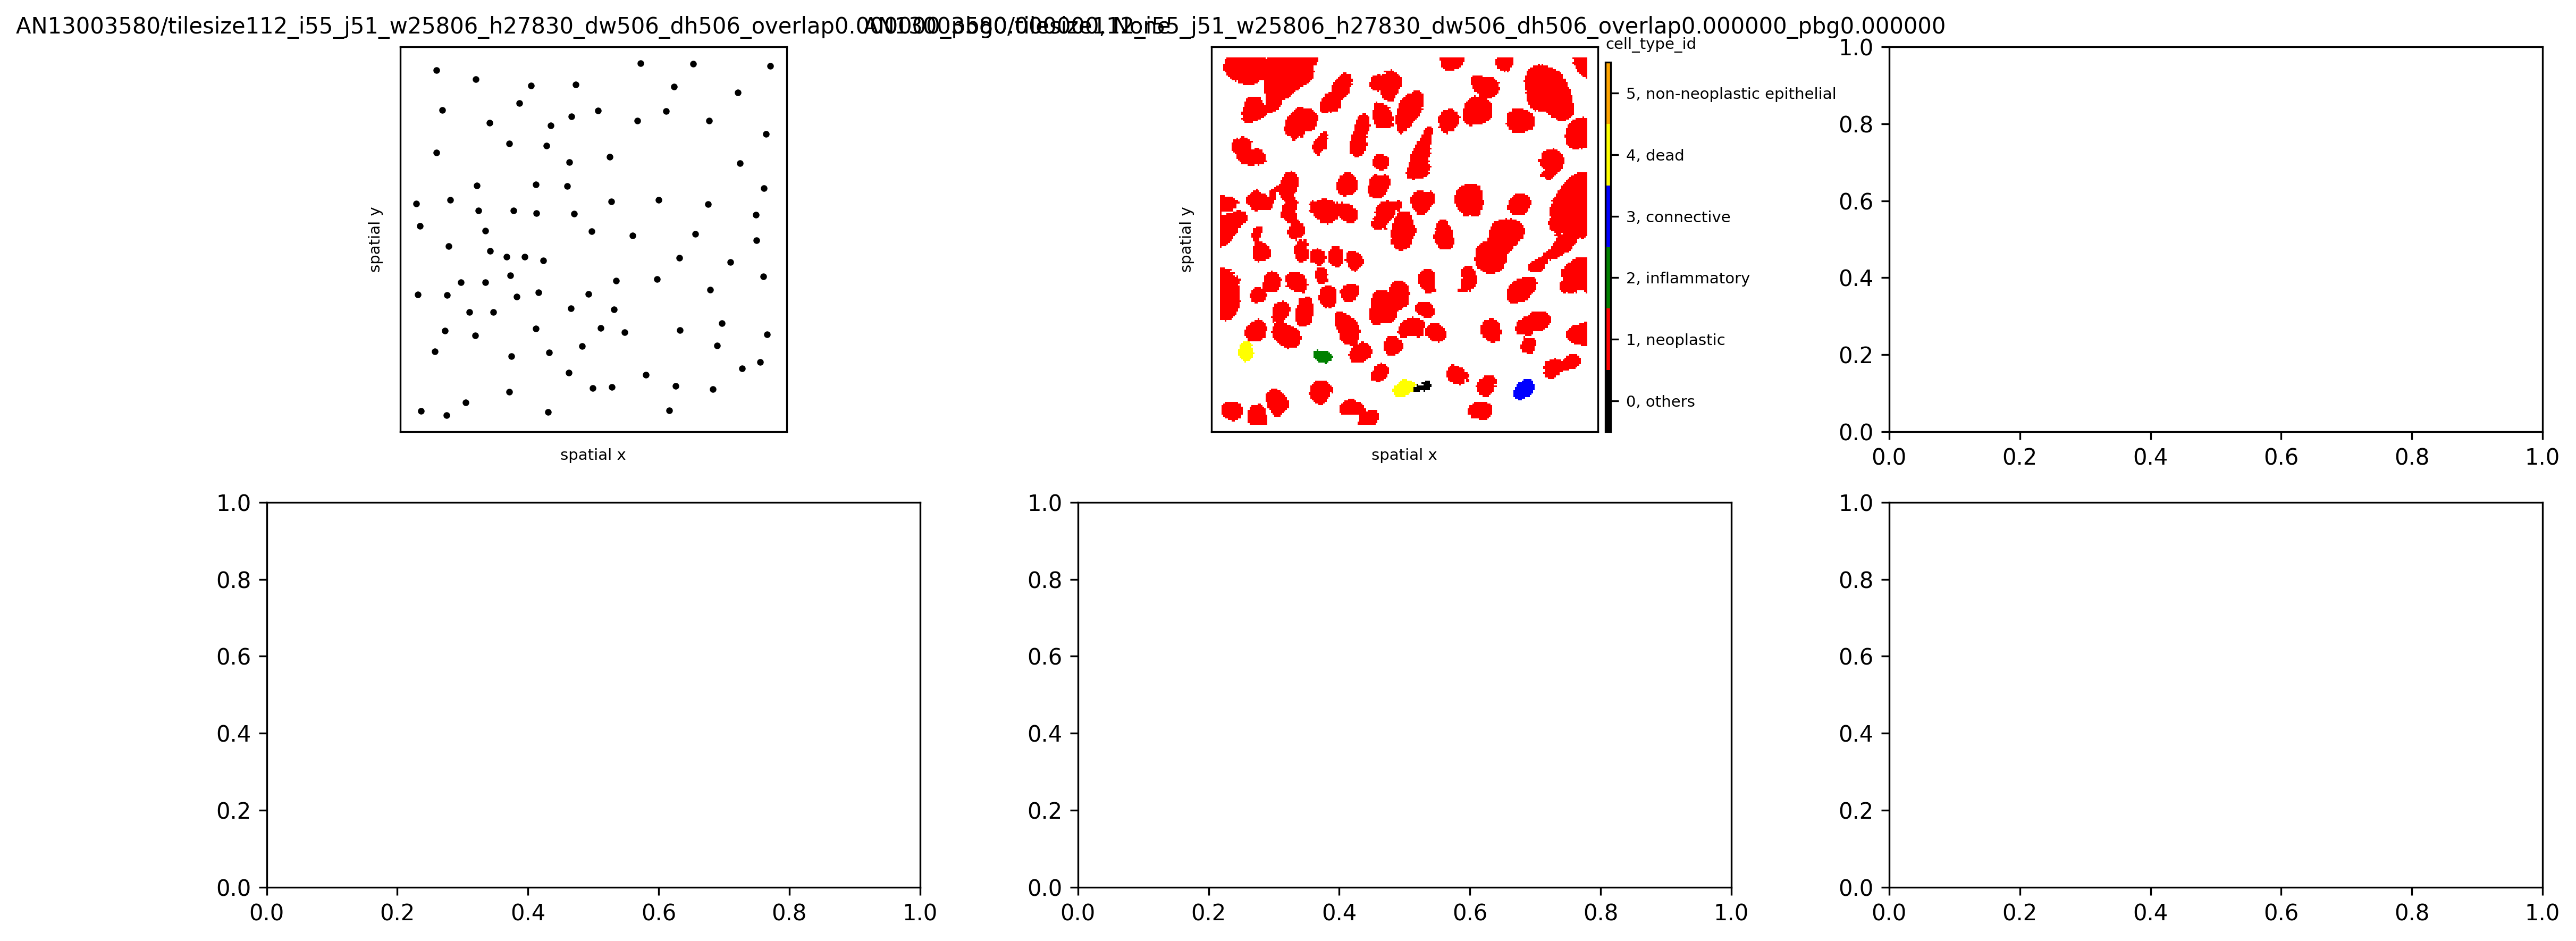

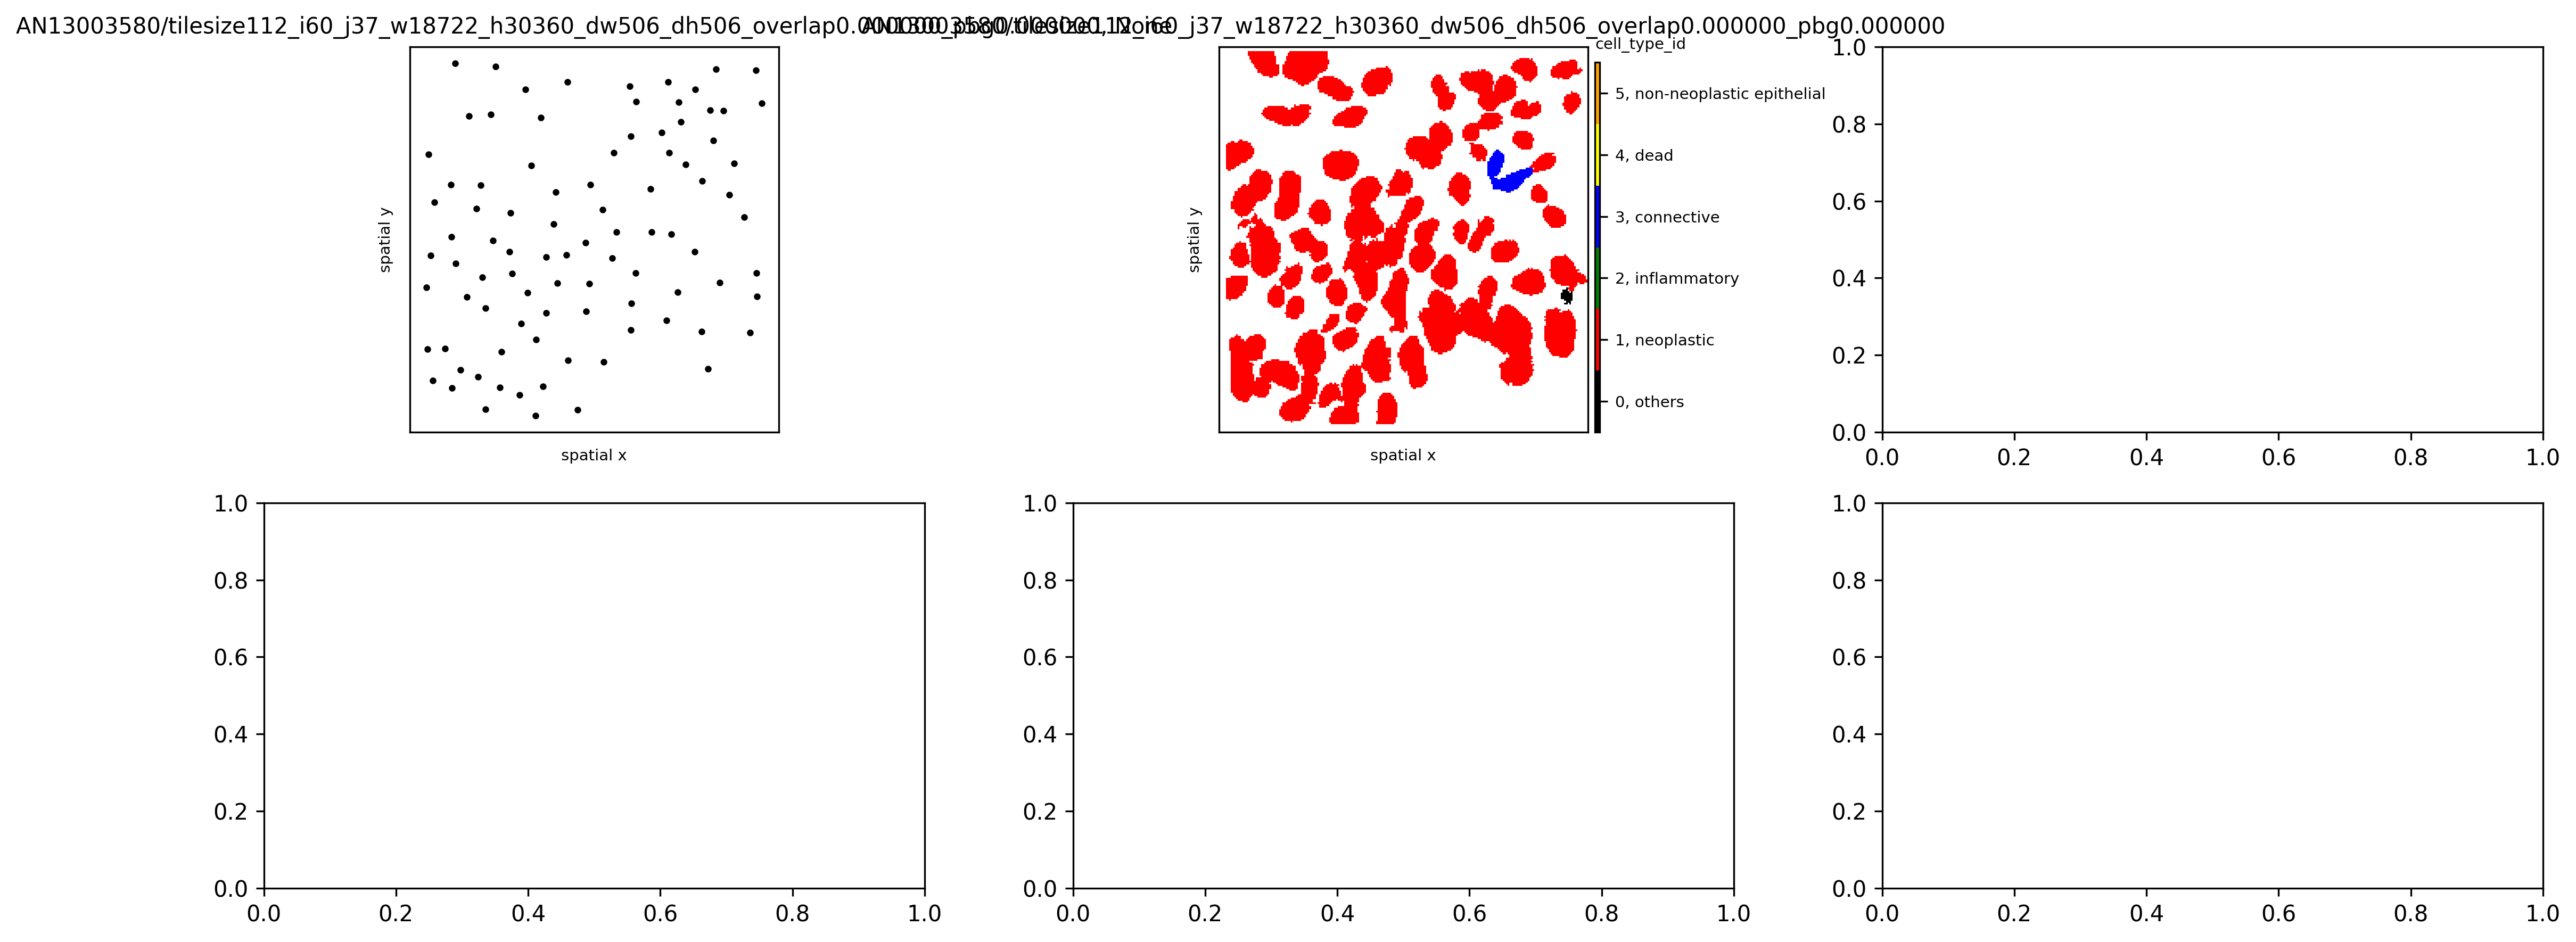

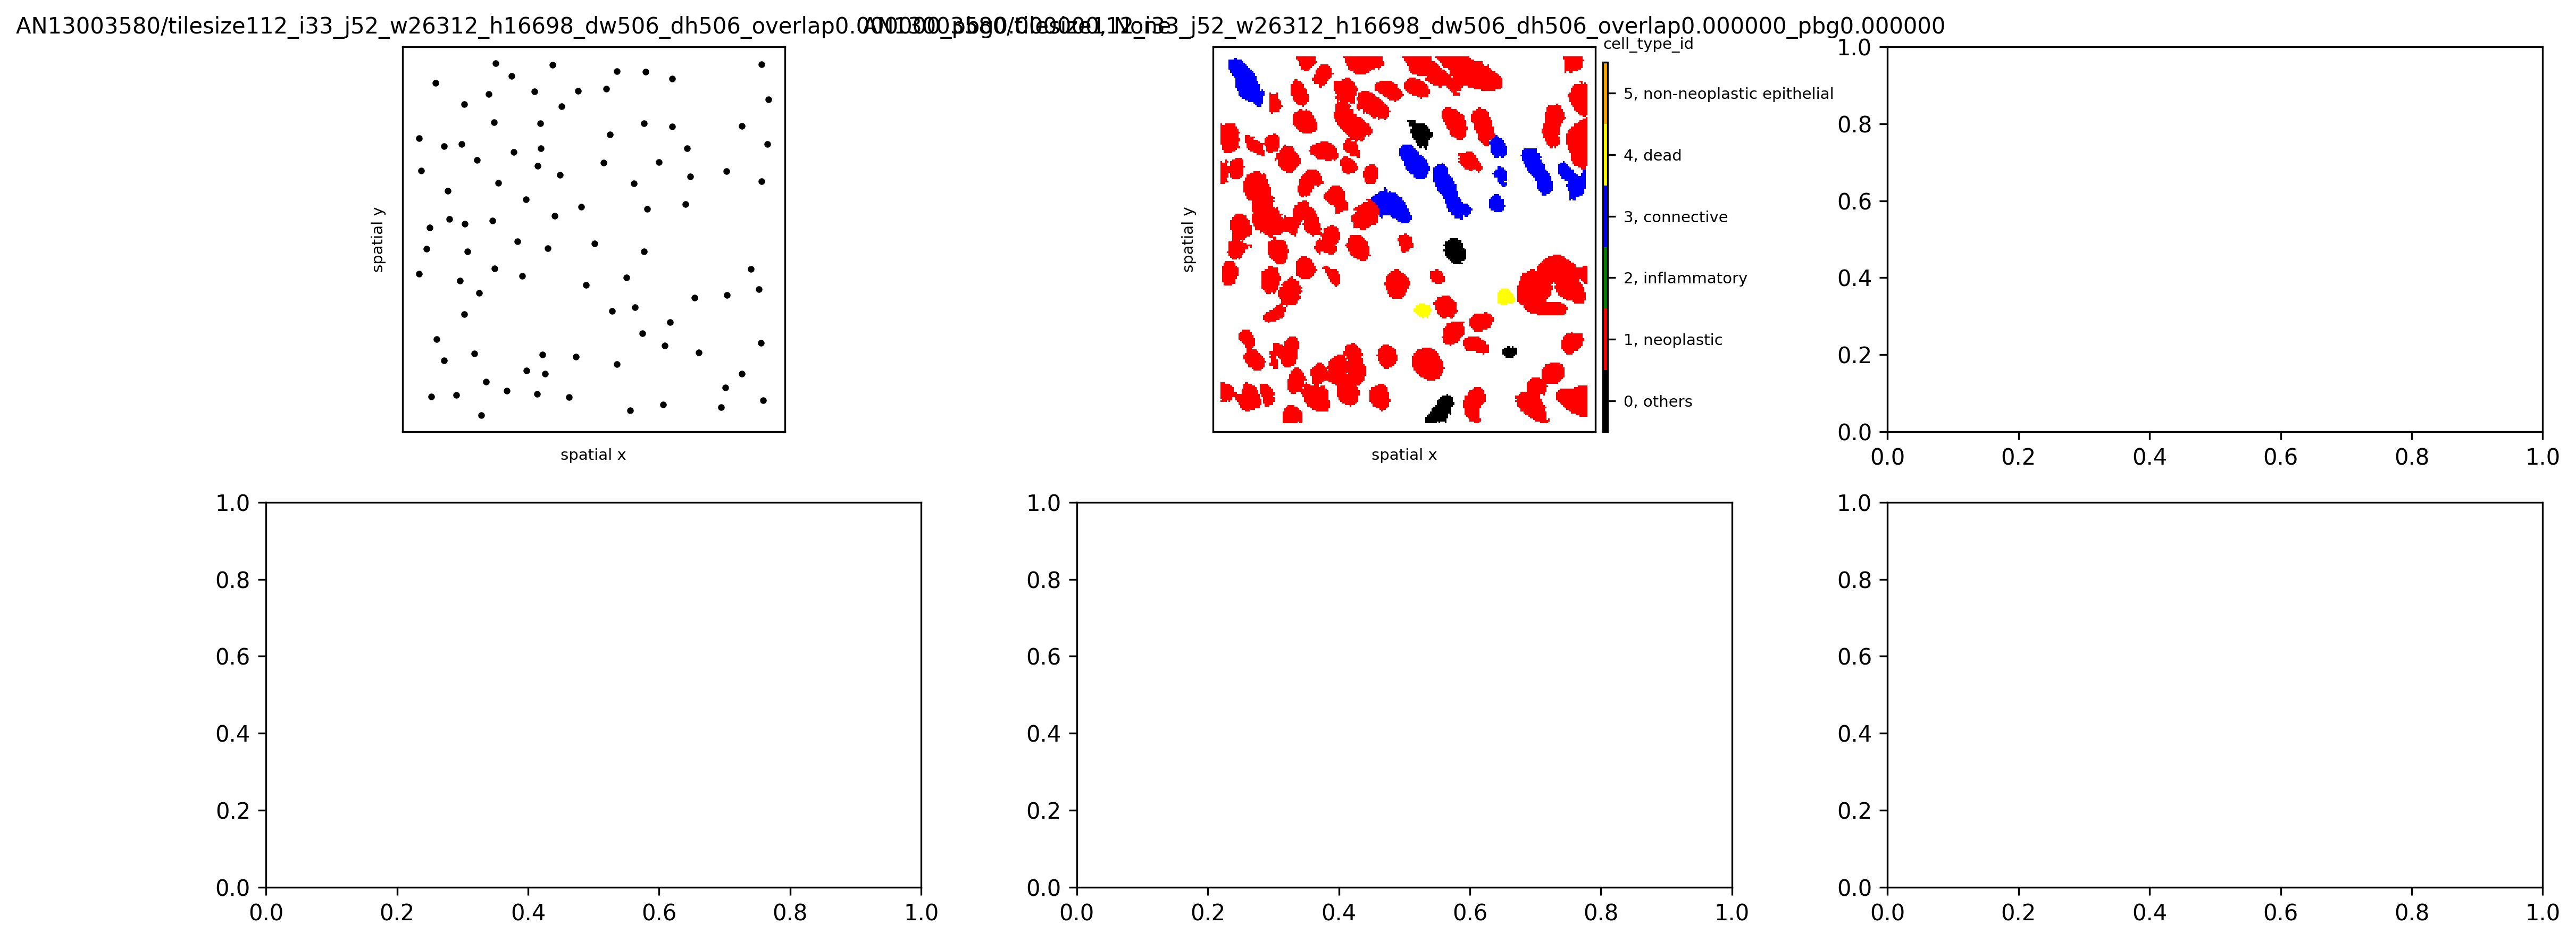

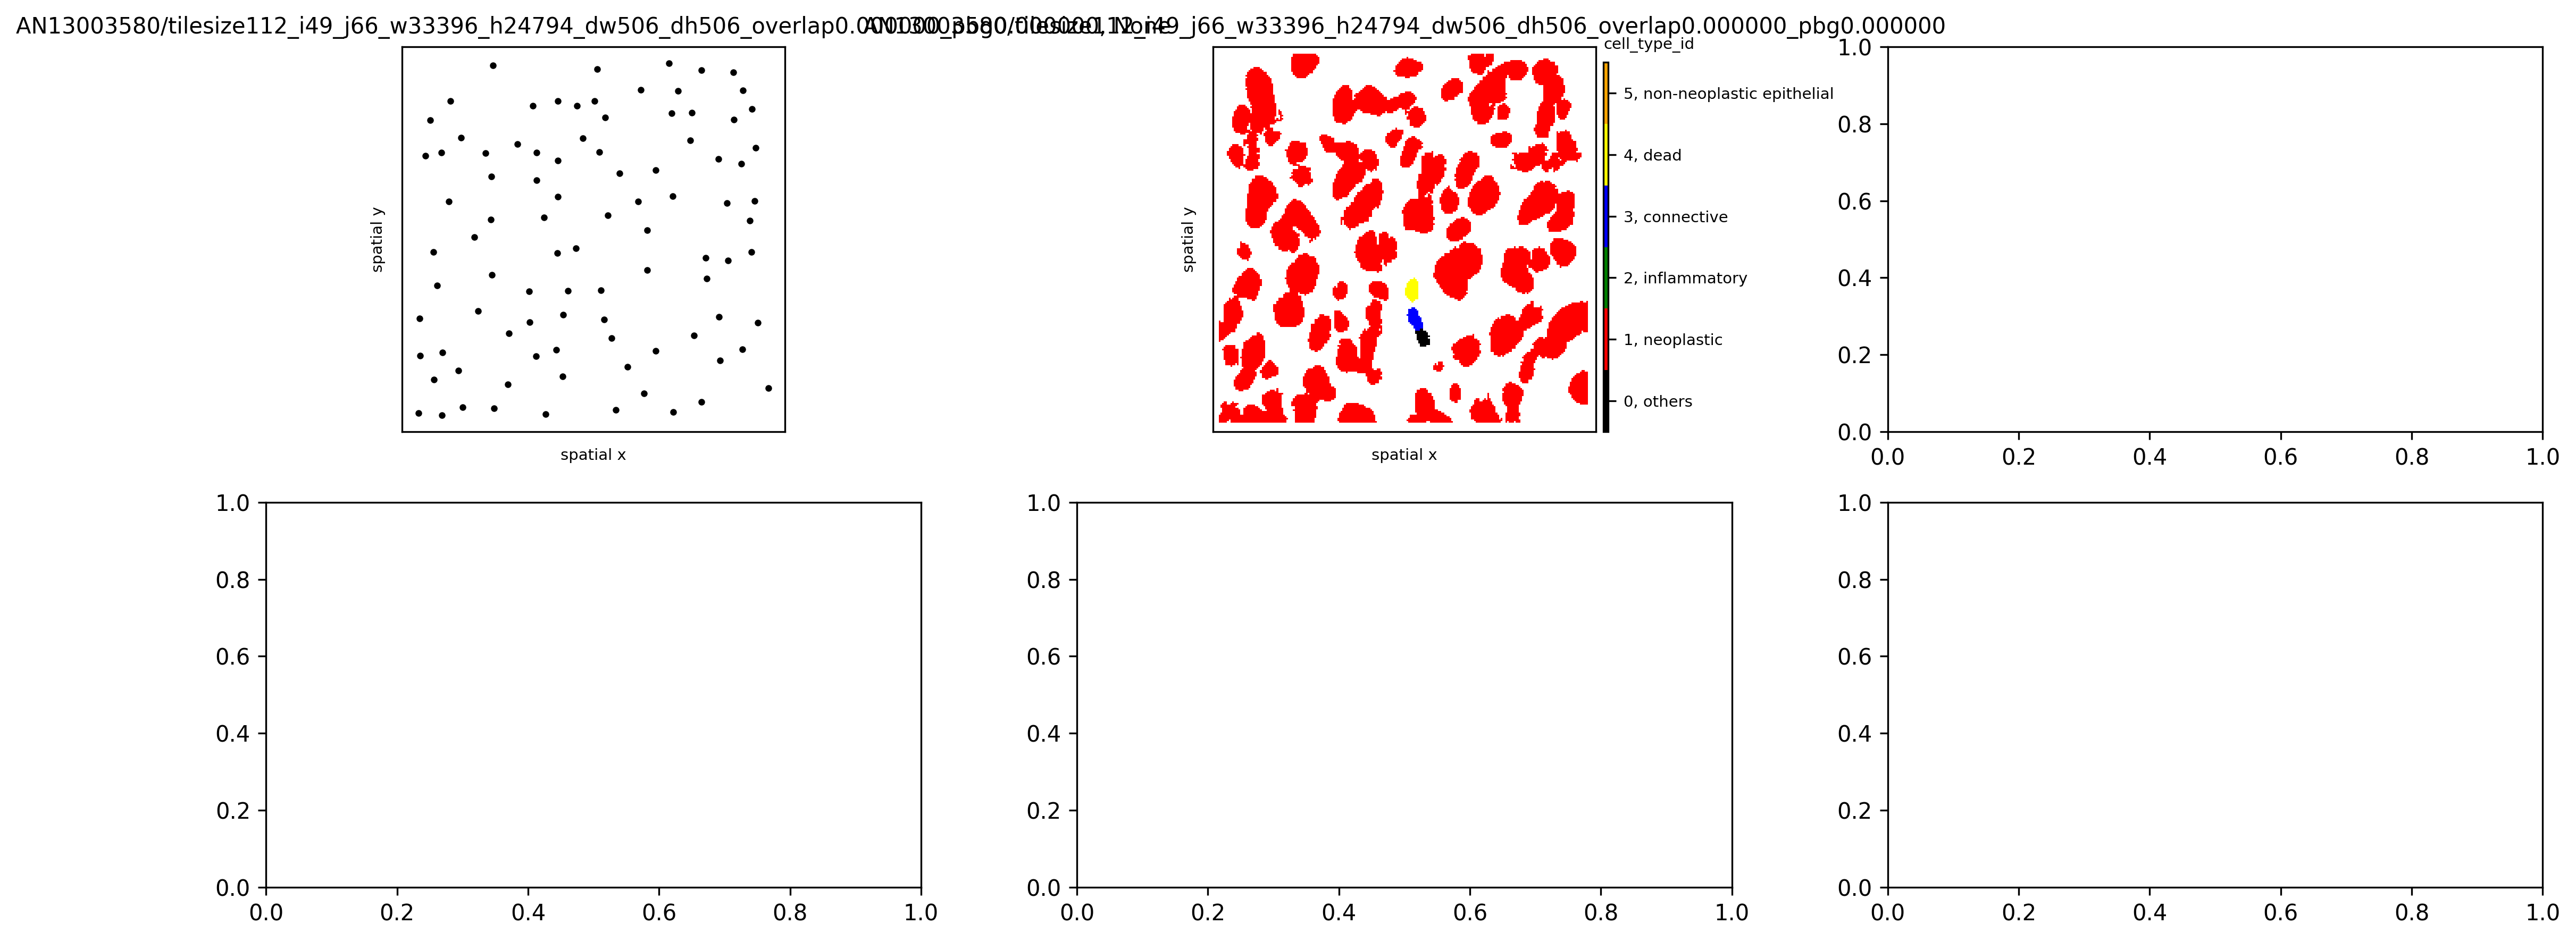

In [10]:
for spl in list(so.masks.keys())[:4]:
    print(spl)
    fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=300)
    sh.pl.spatial(so, spl, None, ax=axs.flat[0])
    sh.pl.spatial(so, spl, 'cell_type_id', mode='mask', ax=axs.flat[1])


# Graph construction

In [15]:
from skimage.morphology import square, diamond, disk

DILATION_KERNELS = {
    'disk': disk,
    'square': square,
    'diamon': diamond
}

EDGE_WEIGHT = 'weight'

GRAPH_BUILDER_DEFAULT_PARAMS = {
    'knn': {'builder_params': {'n_neighbors': 6, 'mode':'connectivity', 'metric':'minkowski', 'p':2, 'metric_params':None, 'include_self':True, 'n_jobs':-1}},
    'contact': {'builder_params': {'dilation_kernel': 'disk', 'radius': 40, 'include_self':True}},
    'radius': {'builder_params': {'radius': 36, 'mode':'connectivity', 'metric':'minkowski', 'p':2, 'metric_params':None, 'include_self':True, 'n_jobs':-1}}
}

In [16]:
import abc

import networkx as nx
import numpy as np
import pandas as pd
from spatialHeterogeneity.utils.tools.graph import df2node_attr
from abc import ABC

class BaseGraphBuilder(ABC):

    def __init__(self, config: dict):
        """Base-Graph Builder constructor

        Args:
            config: Dictionary containing a dict called `builder_params` that provides function call arguments to the build_topology function
        """

        self.config = config
        self.ndata = None
        self.edata = None
        self.graph = nx.Graph()


    def __call__(self, ndata: pd.DataFrame, edata: pd.DataFrame = None, topo_data: dict = None) -> nx.Graph:
        """Builds graph

        Args:
            ndata: dataframe with node data, index is the node
            edata: dataframe with edge data, index specifies edges, i.e. (node1, node2)
            topo_data: dict with additional data for graph construction (necessary for contact graph)

        Returns:
            nx.Graph
        """
        self.ndata = ndata
        self.edata = edata

        self._add_nodes()
        self._add_nodes_attr()

        if edata is None:
            self._build_topology(topo_data=topo_data)
        else:
            self._add_edges()
            self._add_edges_attr()

        return self.graph

    def _add_nodes(self):
        """Adds nodes in ndata to graph

        Returns:

        """
        self.graph.add_nodes_from(self.ndata.index)

    def _add_nodes_attr(self) -> None:
        """Adds node attributes in ndata to graph

        Returns:

        """
        attr = df2node_attr(self.ndata)
        nx.set_node_attributes(self.graph, attr)

    def _add_edges(self) -> None:
        """Adds edges in edata to graph

        Returns:

        """
        self.graph.add_edges_from(self.edata.index)

    def _add_edges_attr(self) -> None:
        """Adds edge attributes in edata to graph

        Returns:

        """
        attr = df2node_attr(self.edata)
        nx.set_edge_attributes(self.graph, attr)

    @abc.abstractmethod
    def _build_topology(self, **kwargs) -> None:
        """Builds graph topology. Implemented in subclasses.

        Args:
            **kwargs:

        Returns:

        """
        raise NotImplementedError('Implemented in subclasses.')

    # Convenient method to build graph from cellmask
    @classmethod
    def from_mask(cls, config: dict, mask: np.ndarray) -> nx.Graph:
        """Construct graph topology from segmentation masks.

        Args:
            config: config: Dictionary containing a dict called `builder_params` that provides function call arguments to the build_topology function
            mask: image file that provides the image segmentation

        Returns:
            nx.Graph
        """

        # load required dependencies
        try:
            import numpy as np
            from skimage.io import imread
            from skimage.measure import regionprops_table
        except ImportError:
            raise ImportError(
                'Please install the skimage: `conda install -c anaconda scikit-image`.')

        instance = cls(config)
       # print("bouh", mask.shape)

        # extract location
        ndata = regionprops_table(mask, properties=['label', 'centroid'])

        ndata = pd.DataFrame.from_dict(ndata)
        ndata.columns = ['cell_id', 'y', 'x']  # NOTE: axis 0 is y and axis 1 is x
        ndata.set_index('cell_id', inplace=True)
        ndata.sort_index(axis=0, ascending=True, inplace=True)
        #print('len ndata', len(ndata))
        #print(ndata.head())
        

        return instance(ndata, topo_data={'mask': mask})

In [17]:
import networkx as nx
import numpy as np

from skimage.morphology import binary_dilation

#from spatialHeterogeneity.graph_builder.base_graph_builder import BaseGraphBuilder
#from spatialHeterogeneity.graph_builder.constants import EDGE_WEIGHT
#from spatialHeterogeneity.graph_builder.constants import DILATION_KERNELS

from tqdm import tqdm


# %%
def dilation(args) -> list:
    """Compute dilation of a given object in a segmentation mask
    Args:
        args: masks, obj and dilation kernel
    Returns:
    """
    mask, obj, kernel = args
    dilated_img = binary_dilation(mask == obj, kernel)
    cells = np.unique(mask[dilated_img])
    cells = cells[cells != obj]  # remove object itself
    cells = cells[cells != 0]  # remove background
    return [(obj, cell, {EDGE_WEIGHT: 1}) for cell in cells]


# %%
class ContactGraphBuilder(BaseGraphBuilder):
    '''Contact-Graph class.
    Build contact graph based on pixel expansion of cell masks.
    '''

    def __init__(self, config: dict):
        """Base-Graph Builder constructor
        Args:
            config: Dictionary containing a dict called `builder_params` that provides function call arguments to the build_topology function
        """
        super().__init__(config)

    def _build_topology(self, topo_data: dict, **kwargs) -> None:
        """Build topology using pixel expansion of segmentation masks provided by topo_data['mask']. Masks that overlap after expansion are connected in the graph.
        Args:
            topo_data: dict providing the segmentation mask under key 'mask'
        Returns:
        """

        # type hints
        self.graph: nx.Graph
        #print("td", topo_data)
        params = self.config['builder_params']

        mask = topo_data['mask']

        if params['dilation_kernel'] in DILATION_KERNELS:
            kernel = DILATION_KERNELS[params['dilation_kernel']](params['radius'])
        else:
            raise ValueError(
                f'Specified dilate kernel not available. Please use one of {{{", ".join(DILATION_KERNELS)}}}.')

        # get object ids, 0 is background.
        objs = np.unique(mask)
        objs = objs[objs != 0]
       # print('objs', objs)
       # print('spl', spl)
       # print(len(so.obs[spl]))

        # compute neighbours
        edges = []
        for obj in tqdm(objs):
            #print("obj", obj)
            dilated_img = binary_dilation(mask == obj, kernel)
            cells = np.unique(mask[dilated_img])
            cells = cells[cells != obj]  # remove object itself
            cells = cells[cells != 0]  # remove background
            #print('bouh')
            edges.extend([(obj, cell, {EDGE_WEIGHT: 1}) for cell in cells])

        self.graph.add_edges_from(edges)

In [18]:
#from spatialHeterogeneity.graph_builder.contact_graph_builder import ContactGraphBuilder
from spatialHeterogeneity.graph_builder.knn_graph_builder import KNNGraphBuilder
from spatialHeterogeneity.graph_builder.radius_graph_builder import RadiusGraphBuilder 

GRAPH_BUILDERS = {
    'knn': KNNGraphBuilder,
    'contact': ContactGraphBuilder,
    'radius': RadiusGraphBuilder
}

In [19]:
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#from spatialHeterogeneity.graph_builder.mappings import GRAPH_BUILDERS
import networkx as nx
from pandas import DataFrame

def build_graph(so, spl: str, builder_type = 'knn', mask_key = 'cellmasks', key_added=None, config = None, inplace=True):
    """Build graph representation for a sample
    Args:
        so:
        spl:
        builder_type: graph type to construct {knn, radius, contact}
        mask_key: key in so.masks[spl] to use as segmentation masks
        key_added:
        config: dict containing a dict 'builder_params' that specifies the graph construction parameters
        inplace: whether to return a new SpatialOmics instance
    Returns:
        None or SpatialOmics if inplace = False
    """
    if builder_type not in GRAPH_BUILDERS:
        raise ValueError(f'invalid type {builder_type}. Available types are {GRAPH_BUILDERS.keys()}')
    if config is None:
        config = GRAPH_BUILDER_DEFAULT_PARAMS[builder_type].copy()
    if key_added is None:
        key_added = builder_type

    if mask_key is None:
        ndat = so.obs[spl][['x','y']]
        builder = GRAPH_BUILDERS[builder_type](config)
        g = builder(ndata=ndat)
    else:
        mask = so.masks[spl][mask_key] #so.get_mask(spl,mask_key)
        #print("shape mask", mask.shape)
        #print('builder type', builder_type)
        #print("config", config)
        g = GRAPH_BUILDERS[builder_type].from_mask(config, mask)
        #print('g', g)

    if 'include_self' in config['builder_params'] and config['builder_params']['include_self'] and builder_type == 'contact':
        edge_list = [(i,i) for i in g.nodes]
        g.add_edges_from(edge_list)

    so = so if inplace else so.copy()
    if spl in so.G:
        so.G[spl].update({key_added: g})
    else:
        so.G[spl] = {key_added:g}

In [20]:
# import default graph builder parameters
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#print("spl", spl)
i = 0
for spl in list(so.masks.keys())[:300] :
    if i != 0 and i%300==0 :
        print('on stocke à i = ', i)
        pickle.dump(so, open('so_50_med_graph_300.pkl', 'wb'))
        print('objet stocké')
    if spl not in so.G.keys() :
        print(i)

        # kNN graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
        config['builder_params']['n_neighbors'] = 5# set parameter k
        build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config) #sh.graph.

        # radius graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
        config['builder_params']['radius'] = 50 # set radius
        build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

        # contact graph - this takes some time
        build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

        # the results are saved back into `.G`:
        so.G[spl]

        i+= 1
    else :
        print(i)
        print(spl, 'est deja dans so.G')
        i+=1
        pass
pickle.dump(so, open('so_50_med_graph_300.pkl', 'wb'))

0


100%|███████████████████████████████████████████| 95/95 [00:43<00:00,  2.16it/s]


1


100%|███████████████████████████████████████████| 91/91 [00:40<00:00,  2.22it/s]


2


100%|███████████████████████████████████████████| 95/95 [00:42<00:00,  2.24it/s]


3


100%|███████████████████████████████████████████| 93/93 [00:41<00:00,  2.25it/s]


4


100%|███████████████████████████████████████████| 84/84 [00:34<00:00,  2.42it/s]


5


100%|███████████████████████████████████████████| 89/89 [00:36<00:00,  2.45it/s]


6


100%|███████████████████████████████████████████| 80/80 [00:32<00:00,  2.44it/s]


7


100%|███████████████████████████████████████████| 77/77 [00:31<00:00,  2.45it/s]


8


100%|███████████████████████████████████████████| 92/92 [00:37<00:00,  2.45it/s]


9


100%|███████████████████████████████████████████| 83/83 [00:33<00:00,  2.45it/s]


10


100%|███████████████████████████████████████████| 88/88 [00:35<00:00,  2.45it/s]


11


100%|███████████████████████████████████████████| 86/86 [00:36<00:00,  2.37it/s]


12


100%|███████████████████████████████████████████| 81/81 [00:34<00:00,  2.32it/s]


13


100%|███████████████████████████████████████████| 77/77 [00:33<00:00,  2.31it/s]


14


100%|███████████████████████████████████████████| 84/84 [00:35<00:00,  2.34it/s]


15


100%|███████████████████████████████████████████| 71/71 [00:29<00:00,  2.37it/s]


16


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.61it/s]


17


100%|███████████████████████████████████████████| 86/86 [00:30<00:00,  2.78it/s]


18


100%|███████████████████████████████████████████| 90/90 [00:36<00:00,  2.48it/s]


19


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.64it/s]


20


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.71it/s]


21


100%|███████████████████████████████████████████| 89/89 [00:33<00:00,  2.69it/s]


22


100%|███████████████████████████████████████████| 78/78 [00:28<00:00,  2.75it/s]


23


100%|███████████████████████████████████████████| 74/74 [00:26<00:00,  2.84it/s]


24


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.60it/s]


25


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.70it/s]


26


100%|███████████████████████████████████████████| 79/79 [00:30<00:00,  2.61it/s]


27


100%|███████████████████████████████████████████| 79/79 [00:31<00:00,  2.52it/s]


28


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.74it/s]


29


100%|███████████████████████████████████████████| 85/85 [00:33<00:00,  2.57it/s]


30


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.65it/s]


31


100%|███████████████████████████████████████████| 87/87 [00:31<00:00,  2.78it/s]


32


100%|███████████████████████████████████████████| 79/79 [00:30<00:00,  2.62it/s]


33


100%|███████████████████████████████████████████| 90/90 [00:33<00:00,  2.66it/s]


34


100%|███████████████████████████████████████████| 86/86 [00:34<00:00,  2.49it/s]


35


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.59it/s]


36


100%|███████████████████████████████████████████| 81/81 [00:32<00:00,  2.48it/s]


37


100%|███████████████████████████████████████████| 78/78 [00:31<00:00,  2.51it/s]


38


100%|███████████████████████████████████████████| 73/73 [00:27<00:00,  2.64it/s]


39


100%|███████████████████████████████████████████| 78/78 [00:30<00:00,  2.53it/s]


40


100%|███████████████████████████████████████████| 82/82 [00:32<00:00,  2.56it/s]


41


100%|███████████████████████████████████████████| 73/73 [00:27<00:00,  2.67it/s]


42


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.63it/s]


43


100%|███████████████████████████████████████████| 83/83 [00:33<00:00,  2.51it/s]


44


100%|███████████████████████████████████████████| 74/74 [00:29<00:00,  2.50it/s]


45


100%|███████████████████████████████████████████| 90/90 [00:34<00:00,  2.58it/s]


46


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.65it/s]


47


100%|███████████████████████████████████████████| 86/86 [00:32<00:00,  2.63it/s]


48


100%|███████████████████████████████████████████| 83/83 [00:32<00:00,  2.52it/s]


49


100%|███████████████████████████████████████████| 68/68 [00:28<00:00,  2.43it/s]


50


100%|███████████████████████████████████████████| 82/82 [00:33<00:00,  2.43it/s]


51


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.55it/s]


52


100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.80it/s]


53


100%|███████████████████████████████████████████| 70/70 [00:27<00:00,  2.54it/s]


54


100%|███████████████████████████████████████████| 78/78 [00:28<00:00,  2.73it/s]


55


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.65it/s]


56


100%|███████████████████████████████████████████| 71/71 [00:25<00:00,  2.79it/s]


57


100%|███████████████████████████████████████████| 74/74 [00:26<00:00,  2.75it/s]


58


100%|███████████████████████████████████████████| 78/78 [00:30<00:00,  2.57it/s]


59


100%|███████████████████████████████████████████| 78/78 [00:28<00:00,  2.76it/s]


60


100%|███████████████████████████████████████████| 68/68 [00:26<00:00,  2.56it/s]


61


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.69it/s]


62


100%|███████████████████████████████████████████| 68/68 [00:25<00:00,  2.69it/s]


63


100%|███████████████████████████████████████████| 71/71 [00:28<00:00,  2.52it/s]


64


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.65it/s]


65


100%|███████████████████████████████████████████| 80/80 [00:27<00:00,  2.87it/s]


66


100%|███████████████████████████████████████████| 64/64 [00:24<00:00,  2.66it/s]


67


100%|███████████████████████████████████████████| 84/84 [00:33<00:00,  2.49it/s]


68


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.56it/s]


69


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.63it/s]


70


100%|███████████████████████████████████████████| 74/74 [00:29<00:00,  2.51it/s]


71


100%|███████████████████████████████████████████| 71/71 [00:29<00:00,  2.44it/s]


72


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.60it/s]


73


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.61it/s]


74


100%|███████████████████████████████████████████| 63/63 [00:23<00:00,  2.71it/s]


75


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.50it/s]


76


100%|███████████████████████████████████████████| 77/77 [00:27<00:00,  2.79it/s]


77


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


78


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.73it/s]


79


100%|███████████████████████████████████████████| 81/81 [00:33<00:00,  2.43it/s]


80


100%|███████████████████████████████████████████| 75/75 [00:30<00:00,  2.48it/s]


81


100%|███████████████████████████████████████████| 84/84 [00:30<00:00,  2.72it/s]


82


100%|█████████████████████████████████████████| 192/192 [01:11<00:00,  2.70it/s]


83


100%|█████████████████████████████████████████| 150/150 [00:56<00:00,  2.66it/s]


84


100%|█████████████████████████████████████████| 147/147 [00:55<00:00,  2.67it/s]


85


100%|█████████████████████████████████████████| 144/144 [00:52<00:00,  2.74it/s]


86


100%|█████████████████████████████████████████| 146/146 [00:58<00:00,  2.50it/s]


87


100%|█████████████████████████████████████████| 150/150 [00:58<00:00,  2.54it/s]


88


100%|█████████████████████████████████████████| 135/135 [00:50<00:00,  2.68it/s]


89


100%|█████████████████████████████████████████| 137/137 [00:49<00:00,  2.75it/s]


90


100%|█████████████████████████████████████████| 141/141 [00:53<00:00,  2.63it/s]


91


100%|█████████████████████████████████████████| 133/133 [00:52<00:00,  2.52it/s]


92


100%|█████████████████████████████████████████| 134/134 [00:50<00:00,  2.64it/s]


93


100%|█████████████████████████████████████████| 131/131 [00:50<00:00,  2.60it/s]


94


100%|█████████████████████████████████████████| 133/133 [00:53<00:00,  2.49it/s]


95


100%|█████████████████████████████████████████| 133/133 [00:53<00:00,  2.50it/s]


96


100%|█████████████████████████████████████████| 130/130 [00:50<00:00,  2.57it/s]


97


100%|█████████████████████████████████████████| 145/145 [00:54<00:00,  2.66it/s]


98


100%|█████████████████████████████████████████| 144/144 [00:55<00:00,  2.60it/s]


99


100%|█████████████████████████████████████████| 123/123 [00:44<00:00,  2.74it/s]


100


100%|█████████████████████████████████████████| 142/142 [00:52<00:00,  2.70it/s]


101


100%|█████████████████████████████████████████| 130/130 [00:51<00:00,  2.52it/s]


102


100%|█████████████████████████████████████████| 124/124 [00:44<00:00,  2.76it/s]


103


100%|█████████████████████████████████████████| 117/117 [00:43<00:00,  2.71it/s]


104


100%|█████████████████████████████████████████| 115/115 [00:45<00:00,  2.53it/s]


105


100%|█████████████████████████████████████████| 123/123 [00:45<00:00,  2.72it/s]


106


100%|█████████████████████████████████████████| 136/136 [00:53<00:00,  2.54it/s]


107


100%|█████████████████████████████████████████| 135/135 [00:51<00:00,  2.63it/s]


108


100%|█████████████████████████████████████████| 127/127 [00:47<00:00,  2.65it/s]


109


100%|█████████████████████████████████████████| 122/122 [00:45<00:00,  2.68it/s]


110


100%|█████████████████████████████████████████| 115/115 [00:44<00:00,  2.60it/s]


111


100%|█████████████████████████████████████████| 116/116 [00:43<00:00,  2.64it/s]


112


100%|█████████████████████████████████████████| 150/150 [00:55<00:00,  2.69it/s]


113


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.73it/s]


114


100%|█████████████████████████████████████████| 133/133 [00:46<00:00,  2.87it/s]


115


100%|█████████████████████████████████████████| 139/139 [00:52<00:00,  2.66it/s]


116


100%|█████████████████████████████████████████| 134/134 [00:50<00:00,  2.64it/s]


117


100%|█████████████████████████████████████████| 132/132 [00:47<00:00,  2.79it/s]


118


100%|█████████████████████████████████████████| 133/133 [00:54<00:00,  2.44it/s]


119


100%|█████████████████████████████████████████| 141/141 [00:49<00:00,  2.87it/s]


120


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.76it/s]


121


100%|█████████████████████████████████████████| 112/112 [00:43<00:00,  2.59it/s]


122


100%|█████████████████████████████████████████| 113/113 [00:41<00:00,  2.70it/s]


123


100%|█████████████████████████████████████████| 114/114 [00:43<00:00,  2.65it/s]


124


100%|█████████████████████████████████████████| 113/113 [00:42<00:00,  2.65it/s]


125


100%|█████████████████████████████████████████| 142/142 [00:55<00:00,  2.56it/s]


126


100%|█████████████████████████████████████████| 129/129 [00:49<00:00,  2.62it/s]


127


100%|█████████████████████████████████████████| 135/135 [00:49<00:00,  2.73it/s]


128


100%|█████████████████████████████████████████| 129/129 [00:46<00:00,  2.75it/s]


129


100%|█████████████████████████████████████████| 123/123 [00:45<00:00,  2.68it/s]


130


100%|█████████████████████████████████████████| 121/121 [00:46<00:00,  2.62it/s]


131


100%|█████████████████████████████████████████| 124/124 [00:47<00:00,  2.62it/s]


132


100%|█████████████████████████████████████████| 136/136 [00:54<00:00,  2.51it/s]


133


100%|█████████████████████████████████████████| 130/130 [00:51<00:00,  2.55it/s]


134


100%|█████████████████████████████████████████| 129/129 [00:47<00:00,  2.71it/s]


135


100%|█████████████████████████████████████████| 132/132 [00:48<00:00,  2.71it/s]


136


100%|█████████████████████████████████████████| 124/124 [00:46<00:00,  2.67it/s]


137


100%|█████████████████████████████████████████| 124/124 [00:44<00:00,  2.77it/s]


138


100%|█████████████████████████████████████████| 126/126 [00:47<00:00,  2.68it/s]


139


100%|█████████████████████████████████████████| 127/127 [00:46<00:00,  2.73it/s]


140


100%|█████████████████████████████████████████| 120/120 [00:45<00:00,  2.63it/s]


141


100%|█████████████████████████████████████████| 110/110 [00:40<00:00,  2.70it/s]


142


100%|█████████████████████████████████████████| 124/124 [00:44<00:00,  2.78it/s]


143


100%|█████████████████████████████████████████| 119/119 [00:42<00:00,  2.77it/s]


144


100%|█████████████████████████████████████████| 122/122 [00:47<00:00,  2.58it/s]


145


100%|█████████████████████████████████████████| 125/125 [00:51<00:00,  2.43it/s]


146


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.76it/s]


147


100%|█████████████████████████████████████████| 122/122 [00:47<00:00,  2.59it/s]


148


100%|█████████████████████████████████████████| 125/125 [00:44<00:00,  2.79it/s]


149


100%|█████████████████████████████████████████| 127/127 [00:48<00:00,  2.62it/s]


150


100%|█████████████████████████████████████████| 123/123 [00:45<00:00,  2.72it/s]


151


100%|█████████████████████████████████████████| 124/124 [00:45<00:00,  2.73it/s]


152


100%|█████████████████████████████████████████| 112/112 [00:41<00:00,  2.67it/s]


153


100%|█████████████████████████████████████████| 107/107 [00:40<00:00,  2.62it/s]


154


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.74it/s]


155


100%|█████████████████████████████████████████| 118/118 [00:45<00:00,  2.61it/s]


156


100%|█████████████████████████████████████████| 116/116 [00:45<00:00,  2.54it/s]


157


100%|█████████████████████████████████████████| 128/128 [00:48<00:00,  2.62it/s]


158


100%|█████████████████████████████████████████| 119/119 [00:44<00:00,  2.68it/s]


159


100%|█████████████████████████████████████████| 126/126 [00:45<00:00,  2.78it/s]


160


100%|█████████████████████████████████████████| 125/125 [00:48<00:00,  2.60it/s]


161


100%|█████████████████████████████████████████| 120/120 [00:45<00:00,  2.64it/s]


162


100%|█████████████████████████████████████████| 115/115 [00:43<00:00,  2.65it/s]


163


100%|█████████████████████████████████████████| 133/133 [00:50<00:00,  2.62it/s]


164


100%|█████████████████████████████████████████| 122/122 [00:45<00:00,  2.70it/s]


165


100%|█████████████████████████████████████████| 117/117 [00:45<00:00,  2.59it/s]


166


100%|█████████████████████████████████████████| 115/115 [00:41<00:00,  2.76it/s]


167


100%|█████████████████████████████████████████| 122/122 [00:49<00:00,  2.45it/s]


168


100%|█████████████████████████████████████████| 124/124 [00:46<00:00,  2.68it/s]


169


100%|█████████████████████████████████████████| 125/125 [00:49<00:00,  2.55it/s]


170


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.70it/s]


171


100%|█████████████████████████████████████████| 121/121 [00:47<00:00,  2.56it/s]


172


100%|█████████████████████████████████████████| 112/112 [00:41<00:00,  2.69it/s]


173


100%|█████████████████████████████████████████| 161/161 [00:59<00:00,  2.68it/s]


174


100%|█████████████████████████████████████████| 160/160 [00:57<00:00,  2.79it/s]


175


100%|█████████████████████████████████████████| 154/154 [01:00<00:00,  2.56it/s]


176


100%|█████████████████████████████████████████| 158/158 [01:00<00:00,  2.63it/s]


177


100%|█████████████████████████████████████████| 158/158 [01:00<00:00,  2.61it/s]


178


100%|█████████████████████████████████████████| 162/162 [01:00<00:00,  2.69it/s]


179


100%|█████████████████████████████████████████| 154/154 [01:01<00:00,  2.52it/s]


180


100%|█████████████████████████████████████████| 154/154 [00:57<00:00,  2.66it/s]


181


100%|█████████████████████████████████████████| 156/156 [00:58<00:00,  2.67it/s]


182


100%|█████████████████████████████████████████| 154/154 [00:57<00:00,  2.68it/s]


183


100%|█████████████████████████████████████████| 149/149 [00:57<00:00,  2.57it/s]


184


100%|█████████████████████████████████████████| 157/157 [00:57<00:00,  2.74it/s]


185


100%|█████████████████████████████████████████| 146/146 [00:54<00:00,  2.70it/s]


186


100%|█████████████████████████████████████████| 161/161 [00:59<00:00,  2.71it/s]


187


100%|█████████████████████████████████████████| 155/155 [00:58<00:00,  2.63it/s]


188


100%|█████████████████████████████████████████| 146/146 [00:53<00:00,  2.73it/s]


189


100%|█████████████████████████████████████████| 152/152 [00:58<00:00,  2.60it/s]


190


100%|█████████████████████████████████████████| 151/151 [01:00<00:00,  2.51it/s]


191


100%|█████████████████████████████████████████| 154/154 [00:55<00:00,  2.77it/s]


192


100%|█████████████████████████████████████████| 142/142 [00:52<00:00,  2.68it/s]


193


100%|█████████████████████████████████████████| 151/151 [00:55<00:00,  2.70it/s]


194


100%|█████████████████████████████████████████| 151/151 [00:56<00:00,  2.66it/s]


195


100%|█████████████████████████████████████████| 143/143 [00:54<00:00,  2.65it/s]


196


100%|█████████████████████████████████████████| 146/146 [00:53<00:00,  2.71it/s]


197


100%|█████████████████████████████████████████| 152/152 [00:53<00:00,  2.83it/s]


198


100%|█████████████████████████████████████████| 141/141 [00:53<00:00,  2.65it/s]


199


100%|█████████████████████████████████████████| 143/143 [00:53<00:00,  2.67it/s]


200


100%|█████████████████████████████████████████| 144/144 [00:53<00:00,  2.70it/s]


201


100%|█████████████████████████████████████████| 152/152 [00:59<00:00,  2.57it/s]


202


100%|█████████████████████████████████████████| 139/139 [00:51<00:00,  2.68it/s]


203


100%|█████████████████████████████████████████| 143/143 [00:53<00:00,  2.66it/s]


204


100%|█████████████████████████████████████████| 144/144 [00:52<00:00,  2.75it/s]


205


100%|█████████████████████████████████████████| 146/146 [00:55<00:00,  2.64it/s]


206


100%|█████████████████████████████████████████| 147/147 [00:55<00:00,  2.65it/s]


207


100%|█████████████████████████████████████████| 137/137 [00:52<00:00,  2.61it/s]


208


100%|█████████████████████████████████████████| 146/146 [00:56<00:00,  2.59it/s]


209


100%|█████████████████████████████████████████| 142/142 [00:52<00:00,  2.69it/s]


210


100%|█████████████████████████████████████████| 144/144 [00:53<00:00,  2.70it/s]


211


100%|█████████████████████████████████████████| 147/147 [00:52<00:00,  2.79it/s]


212


100%|█████████████████████████████████████████| 151/151 [00:57<00:00,  2.62it/s]


213


100%|█████████████████████████████████████████| 142/142 [00:53<00:00,  2.63it/s]


214


100%|█████████████████████████████████████████| 133/133 [00:51<00:00,  2.57it/s]


215


100%|█████████████████████████████████████████| 140/140 [00:53<00:00,  2.61it/s]


216


100%|█████████████████████████████████████████| 140/140 [00:52<00:00,  2.65it/s]


217


100%|█████████████████████████████████████████| 139/139 [00:50<00:00,  2.76it/s]


218


100%|█████████████████████████████████████████| 134/134 [00:48<00:00,  2.75it/s]


219


100%|█████████████████████████████████████████| 143/143 [00:54<00:00,  2.61it/s]


220


100%|█████████████████████████████████████████| 132/132 [00:54<00:00,  2.44it/s]


221


100%|█████████████████████████████████████████| 132/132 [00:52<00:00,  2.54it/s]


222


100%|█████████████████████████████████████████| 129/129 [00:49<00:00,  2.62it/s]


223


100%|█████████████████████████████████████████| 140/140 [00:57<00:00,  2.45it/s]


224


100%|█████████████████████████████████████████| 128/128 [00:49<00:00,  2.58it/s]


225


100%|█████████████████████████████████████████| 132/132 [00:48<00:00,  2.74it/s]


226


100%|█████████████████████████████████████████| 132/132 [00:49<00:00,  2.64it/s]


227


100%|█████████████████████████████████████████| 135/135 [00:49<00:00,  2.70it/s]


228


100%|█████████████████████████████████████████| 133/133 [00:49<00:00,  2.67it/s]


229


100%|█████████████████████████████████████████| 131/131 [00:48<00:00,  2.73it/s]


230


100%|█████████████████████████████████████████| 132/132 [00:49<00:00,  2.69it/s]


231


100%|█████████████████████████████████████████| 132/132 [00:52<00:00,  2.52it/s]


232


100%|█████████████████████████████████████████| 130/130 [00:51<00:00,  2.52it/s]


233


100%|█████████████████████████████████████████| 127/127 [00:47<00:00,  2.69it/s]


234


100%|█████████████████████████████████████████| 130/130 [00:50<00:00,  2.57it/s]


235


100%|█████████████████████████████████████████| 127/127 [00:49<00:00,  2.59it/s]


236


100%|█████████████████████████████████████████| 123/123 [00:45<00:00,  2.68it/s]


237


100%|█████████████████████████████████████████| 127/127 [00:46<00:00,  2.71it/s]


238


100%|█████████████████████████████████████████| 130/130 [00:48<00:00,  2.69it/s]


239


100%|█████████████████████████████████████████| 129/129 [00:48<00:00,  2.64it/s]


240


100%|█████████████████████████████████████████| 147/147 [00:54<00:00,  2.71it/s]


241


100%|█████████████████████████████████████████| 137/137 [00:53<00:00,  2.54it/s]


242


100%|█████████████████████████████████████████| 133/133 [00:49<00:00,  2.69it/s]


243


100%|█████████████████████████████████████████| 126/126 [00:48<00:00,  2.59it/s]


244


100%|█████████████████████████████████████████| 121/121 [00:47<00:00,  2.56it/s]


245


100%|█████████████████████████████████████████| 131/131 [00:48<00:00,  2.68it/s]


246


100%|█████████████████████████████████████████| 129/129 [00:49<00:00,  2.63it/s]


247


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.73it/s]


248


100%|█████████████████████████████████████████| 123/123 [00:46<00:00,  2.63it/s]


249


100%|█████████████████████████████████████████| 127/127 [00:47<00:00,  2.68it/s]


250


100%|█████████████████████████████████████████| 130/130 [00:50<00:00,  2.55it/s]


251


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.73it/s]


252


100%|█████████████████████████████████████████| 125/125 [00:48<00:00,  2.55it/s]


253


100%|█████████████████████████████████████████| 130/130 [00:51<00:00,  2.53it/s]


254


100%|█████████████████████████████████████████| 124/124 [00:48<00:00,  2.56it/s]


255


100%|█████████████████████████████████████████| 152/152 [00:57<00:00,  2.63it/s]


256


100%|█████████████████████████████████████████| 126/126 [00:46<00:00,  2.69it/s]


257


100%|█████████████████████████████████████████| 123/123 [00:44<00:00,  2.75it/s]


258


100%|█████████████████████████████████████████| 126/126 [00:46<00:00,  2.70it/s]


259


100%|█████████████████████████████████████████| 140/140 [00:51<00:00,  2.74it/s]


260


100%|█████████████████████████████████████████| 127/127 [00:47<00:00,  2.70it/s]


261


100%|█████████████████████████████████████████| 124/124 [00:48<00:00,  2.58it/s]


262


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.77it/s]


263


100%|█████████████████████████████████████████| 119/119 [00:43<00:00,  2.76it/s]


264


100%|█████████████████████████████████████████| 114/114 [00:42<00:00,  2.65it/s]


265


100%|█████████████████████████████████████████| 124/124 [00:44<00:00,  2.78it/s]


266


100%|█████████████████████████████████████████| 115/115 [00:43<00:00,  2.67it/s]


267


100%|█████████████████████████████████████████| 117/117 [00:47<00:00,  2.49it/s]


268


100%|█████████████████████████████████████████| 108/108 [00:41<00:00,  2.59it/s]


269


100%|█████████████████████████████████████████| 117/117 [00:43<00:00,  2.67it/s]


270


100%|█████████████████████████████████████████| 111/111 [00:41<00:00,  2.67it/s]


271


100%|█████████████████████████████████████████| 111/111 [00:41<00:00,  2.65it/s]


272


100%|█████████████████████████████████████████| 107/107 [00:40<00:00,  2.64it/s]


273


100%|█████████████████████████████████████████| 110/110 [00:42<00:00,  2.56it/s]


274


100%|█████████████████████████████████████████| 107/107 [00:39<00:00,  2.69it/s]


275


100%|█████████████████████████████████████████| 110/110 [00:44<00:00,  2.50it/s]


276


100%|█████████████████████████████████████████| 109/109 [00:43<00:00,  2.50it/s]


277


100%|█████████████████████████████████████████| 105/105 [00:39<00:00,  2.69it/s]


278


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.60it/s]


279


100%|█████████████████████████████████████████| 108/108 [00:41<00:00,  2.58it/s]


280


100%|█████████████████████████████████████████| 127/127 [00:48<00:00,  2.61it/s]


281


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.68it/s]


282


100%|█████████████████████████████████████████| 105/105 [00:37<00:00,  2.77it/s]


283


100%|█████████████████████████████████████████| 110/110 [00:42<00:00,  2.61it/s]


284


100%|█████████████████████████████████████████| 112/112 [00:42<00:00,  2.62it/s]


285


100%|█████████████████████████████████████████| 107/107 [00:40<00:00,  2.61it/s]


286


100%|█████████████████████████████████████████| 112/112 [00:42<00:00,  2.65it/s]


287


100%|█████████████████████████████████████████| 106/106 [00:37<00:00,  2.80it/s]


288


100%|█████████████████████████████████████████| 102/102 [00:39<00:00,  2.60it/s]


289


100%|█████████████████████████████████████████| 108/108 [00:38<00:00,  2.78it/s]


290


100%|█████████████████████████████████████████| 106/106 [00:40<00:00,  2.64it/s]


291


100%|█████████████████████████████████████████| 108/108 [00:40<00:00,  2.67it/s]


292


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.75it/s]


293


100%|█████████████████████████████████████████| 102/102 [00:36<00:00,  2.82it/s]


294


100%|█████████████████████████████████████████| 113/113 [00:45<00:00,  2.51it/s]


295


100%|█████████████████████████████████████████| 119/119 [00:43<00:00,  2.71it/s]


296


100%|█████████████████████████████████████████| 110/110 [00:41<00:00,  2.65it/s]


297


100%|███████████████████████████████████████████| 99/99 [00:37<00:00,  2.65it/s]


298


100%|█████████████████████████████████████████| 109/109 [00:42<00:00,  2.57it/s]


299


100%|█████████████████████████████████████████| 111/111 [00:43<00:00,  2.57it/s]


In [21]:
so = pickle.load(open('so_50_med.pkl', 'rb'))


In [22]:
# import default graph builder parameters
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#print("spl", spl)
i = 300
for spl in list(so.masks.keys())[300:600] :
    if i != 0 and i%300==0 :
        print('on stocke à i = ', i)
        pickle.dump(so, open('so_50_med_graph_600.pkl', 'wb'))
        print('objet stocké')
    if spl not in so.G.keys() :
        print(i)

        # kNN graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
        config['builder_params']['n_neighbors'] = 5# set parameter k
        build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config) #sh.graph.

        # radius graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
        config['builder_params']['radius'] = 50 # set radius
        build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

        # contact graph - this takes some time
        build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

        # the results are saved back into `.G`:
        so.G[spl]

        i+= 1
    else :
        print(i)
        print(spl, 'est deja dans so.G')
        i+=1
        pass
pickle.dump(so, open('so_50_med_graph_600.pkl', 'wb'))

on stocke à i =  300
objet stocké
300


100%|█████████████████████████████████████████| 119/119 [00:44<00:00,  2.70it/s]


301


100%|█████████████████████████████████████████| 109/109 [00:43<00:00,  2.48it/s]


302


100%|█████████████████████████████████████████| 101/101 [00:37<00:00,  2.70it/s]


303


100%|█████████████████████████████████████████| 107/107 [00:42<00:00,  2.53it/s]


304


100%|█████████████████████████████████████████| 101/101 [00:40<00:00,  2.52it/s]


305


100%|███████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


306


100%|███████████████████████████████████████████| 61/61 [00:21<00:00,  2.79it/s]


307


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.79it/s]


308


100%|███████████████████████████████████████████| 60/60 [00:22<00:00,  2.61it/s]


309


100%|███████████████████████████████████████████| 59/59 [00:20<00:00,  2.83it/s]


310


100%|███████████████████████████████████████████| 51/51 [00:18<00:00,  2.73it/s]


311


100%|███████████████████████████████████████████| 54/54 [00:20<00:00,  2.65it/s]


312


100%|███████████████████████████████████████████| 61/61 [00:21<00:00,  2.84it/s]


313


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.79it/s]


314


100%|███████████████████████████████████████████| 53/53 [00:18<00:00,  2.87it/s]


315


100%|███████████████████████████████████████████| 63/63 [00:23<00:00,  2.69it/s]


316


100%|███████████████████████████████████████████| 53/53 [00:21<00:00,  2.48it/s]


317


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


318


100%|███████████████████████████████████████████| 45/45 [00:18<00:00,  2.43it/s]


319


100%|███████████████████████████████████████████| 51/51 [00:20<00:00,  2.43it/s]


320


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.73it/s]


321


100%|███████████████████████████████████████████| 46/46 [00:16<00:00,  2.82it/s]


322


100%|███████████████████████████████████████████| 52/52 [00:19<00:00,  2.67it/s]


323


100%|███████████████████████████████████████████| 50/50 [00:19<00:00,  2.54it/s]


324


100%|███████████████████████████████████████████| 49/49 [00:17<00:00,  2.75it/s]


325


100%|███████████████████████████████████████████| 48/48 [00:17<00:00,  2.73it/s]


326


100%|███████████████████████████████████████████| 44/44 [00:17<00:00,  2.51it/s]


327


100%|███████████████████████████████████████████| 42/42 [00:16<00:00,  2.52it/s]


328


100%|███████████████████████████████████████████| 46/46 [00:17<00:00,  2.69it/s]


329


100%|███████████████████████████████████████████| 54/54 [00:20<00:00,  2.60it/s]


330


100%|███████████████████████████████████████████| 46/46 [00:17<00:00,  2.67it/s]


331


100%|███████████████████████████████████████████| 43/43 [00:16<00:00,  2.60it/s]


332


100%|███████████████████████████████████████████| 49/49 [00:19<00:00,  2.57it/s]


333


100%|███████████████████████████████████████████| 53/53 [00:20<00:00,  2.54it/s]


334


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.73it/s]


335


100%|███████████████████████████████████████████| 37/37 [00:12<00:00,  2.86it/s]


336


100%|███████████████████████████████████████████| 44/44 [00:16<00:00,  2.61it/s]


337


100%|███████████████████████████████████████████| 42/42 [00:15<00:00,  2.75it/s]


338


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.74it/s]


339


100%|███████████████████████████████████████████| 36/36 [00:13<00:00,  2.67it/s]


340


100%|███████████████████████████████████████████| 41/41 [00:15<00:00,  2.59it/s]


341


100%|███████████████████████████████████████████| 39/39 [00:15<00:00,  2.46it/s]


342


100%|███████████████████████████████████████████| 38/38 [00:15<00:00,  2.44it/s]


343


100%|███████████████████████████████████████████| 38/38 [00:15<00:00,  2.44it/s]


344


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.67it/s]


345


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.69it/s]


346


100%|███████████████████████████████████████████| 47/47 [00:17<00:00,  2.62it/s]


347


100%|███████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s]


348


100%|███████████████████████████████████████████| 39/39 [00:15<00:00,  2.45it/s]


349


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.75it/s]


350


100%|███████████████████████████████████████████| 36/36 [00:12<00:00,  2.79it/s]


351


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.70it/s]


352


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.70it/s]


353


100%|███████████████████████████████████████████| 49/49 [00:16<00:00,  2.88it/s]


354


100%|███████████████████████████████████████████| 39/39 [00:15<00:00,  2.59it/s]


355


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.68it/s]


356


100%|███████████████████████████████████████████| 37/37 [00:12<00:00,  2.90it/s]


357


100%|███████████████████████████████████████████| 42/42 [00:14<00:00,  2.89it/s]


358


100%|███████████████████████████████████████████| 43/43 [00:16<00:00,  2.65it/s]


359


100%|███████████████████████████████████████████| 41/41 [00:15<00:00,  2.67it/s]


360


100%|███████████████████████████████████████████| 44/44 [00:15<00:00,  2.80it/s]


361


100%|███████████████████████████████████████████| 36/36 [00:12<00:00,  2.87it/s]


362


100%|███████████████████████████████████████████| 44/44 [00:16<00:00,  2.72it/s]


363


100%|███████████████████████████████████████████| 34/34 [00:12<00:00,  2.66it/s]


364


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.76it/s]


365


100%|███████████████████████████████████████████| 41/41 [00:16<00:00,  2.47it/s]


366


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.65it/s]


367


100%|███████████████████████████████████████████| 45/45 [00:17<00:00,  2.60it/s]


368


100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.56it/s]


369


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.72it/s]


370


100%|███████████████████████████████████████████| 38/38 [00:14<00:00,  2.70it/s]


371


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


372


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.64it/s]


373


100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.90it/s]


374


100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.87it/s]


375


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.62it/s]


376


100%|███████████████████████████████████████████| 33/33 [00:13<00:00,  2.47it/s]


377


100%|███████████████████████████████████████████| 33/33 [00:12<00:00,  2.66it/s]


378


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.71it/s]


379


100%|███████████████████████████████████████████| 43/43 [00:17<00:00,  2.51it/s]


380


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.68it/s]


381


100%|███████████████████████████████████████████| 34/34 [00:12<00:00,  2.75it/s]


382


100%|███████████████████████████████████████████| 36/36 [00:14<00:00,  2.51it/s]


383


100%|███████████████████████████████████████████| 33/33 [00:12<00:00,  2.62it/s]


384


100%|███████████████████████████████████████████| 33/33 [00:13<00:00,  2.44it/s]


385


100%|███████████████████████████████████████████| 37/37 [00:14<00:00,  2.64it/s]


386


100%|███████████████████████████████████████████| 42/42 [00:15<00:00,  2.79it/s]


387


100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.57it/s]


388


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


389


100%|███████████████████████████████████████████| 44/44 [00:15<00:00,  2.81it/s]


390


100%|███████████████████████████████████████████| 43/43 [00:16<00:00,  2.57it/s]


391


100%|███████████████████████████████████████████| 46/46 [00:17<00:00,  2.66it/s]


392


100%|███████████████████████████████████████████| 36/36 [00:14<00:00,  2.45it/s]


393


100%|███████████████████████████████████████████| 39/39 [00:15<00:00,  2.45it/s]


394


100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.66it/s]


395


100%|███████████████████████████████████████████| 33/33 [00:12<00:00,  2.66it/s]


396


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.77it/s]


397


100%|███████████████████████████████████████████| 36/36 [00:14<00:00,  2.44it/s]


398


100%|███████████████████████████████████████████| 35/35 [00:14<00:00,  2.45it/s]


399


100%|███████████████████████████████████████████| 36/36 [00:13<00:00,  2.73it/s]


400


100%|███████████████████████████████████████████| 35/35 [00:14<00:00,  2.44it/s]


401


100%|███████████████████████████████████████████| 28/28 [00:10<00:00,  2.62it/s]


402


100%|███████████████████████████████████████████| 35/35 [00:14<00:00,  2.44it/s]


403


100%|███████████████████████████████████████████| 41/41 [00:16<00:00,  2.56it/s]


404


100%|███████████████████████████████████████████| 32/32 [00:11<00:00,  2.76it/s]


405


100%|███████████████████████████████████████████| 38/38 [00:15<00:00,  2.45it/s]


406


100%|███████████████████████████████████████████| 38/38 [00:15<00:00,  2.45it/s]


407


100%|███████████████████████████████████████████| 36/36 [00:12<00:00,  2.89it/s]


408


100%|███████████████████████████████████████████| 40/40 [00:15<00:00,  2.61it/s]


409


100%|███████████████████████████████████████████| 32/32 [00:11<00:00,  2.85it/s]


410


100%|███████████████████████████████████████████| 38/38 [00:14<00:00,  2.66it/s]


411


100%|███████████████████████████████████████████| 36/36 [00:12<00:00,  2.90it/s]


412


100%|███████████████████████████████████████████| 39/39 [00:13<00:00,  2.88it/s]


413


100%|███████████████████████████████████████████| 33/33 [00:13<00:00,  2.50it/s]


414


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.82it/s]


415


100%|███████████████████████████████████████████| 31/31 [00:10<00:00,  2.88it/s]


416


100%|███████████████████████████████████████████| 33/33 [00:12<00:00,  2.58it/s]


417


100%|███████████████████████████████████████████| 39/39 [00:13<00:00,  2.80it/s]


418


100%|███████████████████████████████████████████| 36/36 [00:12<00:00,  2.80it/s]


419


100%|███████████████████████████████████████████| 34/34 [00:12<00:00,  2.82it/s]


420


100%|███████████████████████████████████████████| 31/31 [00:12<00:00,  2.43it/s]


421


100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.55it/s]


422


100%|███████████████████████████████████████████| 34/34 [00:12<00:00,  2.81it/s]


423


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.68it/s]


424


100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.53it/s]


425


100%|███████████████████████████████████████████| 37/37 [00:13<00:00,  2.77it/s]


426


100%|███████████████████████████████████████████| 39/39 [00:13<00:00,  2.89it/s]


427


100%|███████████████████████████████████████████| 32/32 [00:12<00:00,  2.65it/s]


428


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


429


100%|███████████████████████████████████████████| 27/27 [00:09<00:00,  2.88it/s]


430


100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.81it/s]


431


100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.65it/s]


432


100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.64it/s]


433


100%|███████████████████████████████████████████| 28/28 [00:11<00:00,  2.38it/s]


434


100%|███████████████████████████████████████████| 25/25 [00:08<00:00,  2.84it/s]


435


100%|███████████████████████████████████████████| 33/33 [00:11<00:00,  2.86it/s]


436


100%|███████████████████████████████████████████| 31/31 [00:10<00:00,  2.84it/s]


437


100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.83it/s]


438


100%|███████████████████████████████████████████| 33/33 [00:13<00:00,  2.45it/s]


439


100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.63it/s]


440


100%|███████████████████████████████████████████| 33/33 [00:12<00:00,  2.66it/s]


441


100%|███████████████████████████████████████████| 37/37 [00:15<00:00,  2.44it/s]


442


100%|███████████████████████████████████████████| 27/27 [00:09<00:00,  2.73it/s]


443


100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.58it/s]


444


100%|███████████████████████████████████████████| 43/43 [00:15<00:00,  2.77it/s]


445


100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]


446


100%|███████████████████████████████████████████| 39/39 [00:14<00:00,  2.60it/s]


447


100%|███████████████████████████████████████████| 34/34 [00:12<00:00,  2.70it/s]


448


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


449


100%|███████████████████████████████████████████| 33/33 [00:11<00:00,  2.86it/s]


450


100%|███████████████████████████████████████████| 34/34 [00:13<00:00,  2.53it/s]


451


100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]


452


100%|███████████████████████████████████████████| 28/28 [00:11<00:00,  2.44it/s]


453


100%|███████████████████████████████████████████| 30/30 [00:12<00:00,  2.44it/s]


454


100%|███████████████████████████████████████████| 30/30 [00:12<00:00,  2.44it/s]


455


100%|███████████████████████████████████████████| 31/31 [00:12<00:00,  2.46it/s]


456


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


457


100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.76it/s]


458


100%|███████████████████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


459


100%|███████████████████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


460


100%|███████████████████████████████████████████| 39/39 [00:13<00:00,  2.79it/s]


461


100%|███████████████████████████████████████████| 44/44 [00:16<00:00,  2.70it/s]


462


100%|███████████████████████████████████████████| 27/27 [00:11<00:00,  2.43it/s]


463


100%|███████████████████████████████████████████| 28/28 [00:11<00:00,  2.50it/s]


464


100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.71it/s]


465


100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.88it/s]


466


100%|███████████████████████████████████████████| 31/31 [00:10<00:00,  2.82it/s]


467


100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.72it/s]


468


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.87it/s]


469


100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.79it/s]


470


100%|███████████████████████████████████████████| 33/33 [00:12<00:00,  2.68it/s]


471


100%|███████████████████████████████████████████| 25/25 [00:10<00:00,  2.47it/s]


472


100%|███████████████████████████████████████████| 32/32 [00:12<00:00,  2.59it/s]


473


100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.51it/s]


474


100%|███████████████████████████████████████████| 32/32 [00:12<00:00,  2.66it/s]


475


100%|███████████████████████████████████████████| 32/32 [00:11<00:00,  2.67it/s]


476


100%|███████████████████████████████████████████| 27/27 [00:10<00:00,  2.69it/s]


477


100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.72it/s]


478


100%|███████████████████████████████████████████| 30/30 [00:12<00:00,  2.45it/s]


479


100%|███████████████████████████████████████████| 26/26 [00:09<00:00,  2.87it/s]


480


100%|███████████████████████████████████████████| 31/31 [00:11<00:00,  2.70it/s]


481


100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.86it/s]


482


100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.85it/s]


483


100%|███████████████████████████████████████████| 28/28 [00:10<00:00,  2.57it/s]


484


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


485


100%|███████████████████████████████████████████| 22/22 [00:09<00:00,  2.43it/s]


486


100%|███████████████████████████████████████████| 40/40 [00:16<00:00,  2.45it/s]


487


100%|███████████████████████████████████████████| 23/23 [00:08<00:00,  2.85it/s]


488


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


489


100%|███████████████████████████████████████████| 24/24 [00:10<00:00,  2.40it/s]


490


100%|█████████████████████████████████████████| 112/112 [00:45<00:00,  2.48it/s]


491


100%|█████████████████████████████████████████| 120/120 [00:48<00:00,  2.46it/s]


492


100%|█████████████████████████████████████████| 119/119 [00:47<00:00,  2.52it/s]


493


100%|█████████████████████████████████████████| 122/122 [00:45<00:00,  2.70it/s]


494


100%|█████████████████████████████████████████| 121/121 [00:46<00:00,  2.58it/s]


495


100%|█████████████████████████████████████████| 126/126 [00:46<00:00,  2.70it/s]


496


100%|█████████████████████████████████████████| 118/118 [00:41<00:00,  2.83it/s]


497


100%|█████████████████████████████████████████| 108/108 [00:40<00:00,  2.67it/s]


498


100%|█████████████████████████████████████████| 108/108 [00:39<00:00,  2.74it/s]


499


100%|█████████████████████████████████████████| 104/104 [00:38<00:00,  2.70it/s]


500


100%|█████████████████████████████████████████| 111/111 [00:41<00:00,  2.65it/s]


501


100%|█████████████████████████████████████████| 114/114 [00:43<00:00,  2.64it/s]


502


100%|█████████████████████████████████████████| 106/106 [00:41<00:00,  2.57it/s]


503


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.77it/s]


504


100%|█████████████████████████████████████████| 108/108 [00:39<00:00,  2.75it/s]


505


100%|█████████████████████████████████████████| 107/107 [00:40<00:00,  2.66it/s]


506


100%|█████████████████████████████████████████| 111/111 [00:42<00:00,  2.63it/s]


507


100%|█████████████████████████████████████████| 118/118 [00:43<00:00,  2.70it/s]


508


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.79it/s]


509


100%|█████████████████████████████████████████| 103/103 [00:37<00:00,  2.73it/s]


510


100%|█████████████████████████████████████████| 111/111 [00:43<00:00,  2.57it/s]


511


100%|███████████████████████████████████████████| 96/96 [00:36<00:00,  2.61it/s]


512


100%|█████████████████████████████████████████| 101/101 [00:36<00:00,  2.77it/s]


513


100%|███████████████████████████████████████████| 97/97 [00:37<00:00,  2.60it/s]


514


100%|███████████████████████████████████████████| 98/98 [00:38<00:00,  2.56it/s]


515


100%|███████████████████████████████████████████| 97/97 [00:39<00:00,  2.49it/s]


516


100%|███████████████████████████████████████████| 99/99 [00:35<00:00,  2.79it/s]


517


100%|█████████████████████████████████████████| 109/109 [00:39<00:00,  2.74it/s]


518


100%|███████████████████████████████████████████| 96/96 [00:36<00:00,  2.64it/s]


519


100%|█████████████████████████████████████████| 101/101 [00:38<00:00,  2.66it/s]


520


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.68it/s]


521


100%|█████████████████████████████████████████| 101/101 [00:38<00:00,  2.61it/s]


522


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.73it/s]


523


100%|█████████████████████████████████████████| 103/103 [00:38<00:00,  2.65it/s]


524


100%|█████████████████████████████████████████| 113/113 [00:41<00:00,  2.71it/s]


525


100%|█████████████████████████████████████████| 114/114 [00:42<00:00,  2.71it/s]


526


100%|█████████████████████████████████████████| 102/102 [00:36<00:00,  2.83it/s]


527


100%|███████████████████████████████████████████| 95/95 [00:37<00:00,  2.51it/s]


528


100%|███████████████████████████████████████████| 96/96 [00:38<00:00,  2.52it/s]


529


100%|█████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


530


100%|█████████████████████████████████████████| 101/101 [00:38<00:00,  2.64it/s]


531


100%|█████████████████████████████████████████| 104/104 [00:40<00:00,  2.54it/s]


532


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.69it/s]


533


100%|███████████████████████████████████████████| 97/97 [00:36<00:00,  2.68it/s]


534


100%|███████████████████████████████████████████| 98/98 [00:38<00:00,  2.52it/s]


535


100%|███████████████████████████████████████████| 98/98 [00:36<00:00,  2.66it/s]


536


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.72it/s]


537


100%|█████████████████████████████████████████| 118/118 [00:44<00:00,  2.65it/s]


538


100%|█████████████████████████████████████████| 113/113 [00:41<00:00,  2.70it/s]


539


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.68it/s]


540


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.68it/s]


541


100%|█████████████████████████████████████████| 111/111 [00:41<00:00,  2.65it/s]


542


100%|███████████████████████████████████████████| 99/99 [00:40<00:00,  2.46it/s]


543


100%|███████████████████████████████████████████| 99/99 [00:39<00:00,  2.54it/s]


544


100%|█████████████████████████████████████████| 101/101 [00:38<00:00,  2.63it/s]


545


100%|█████████████████████████████████████████| 101/101 [00:39<00:00,  2.59it/s]


546


100%|█████████████████████████████████████████| 101/101 [00:37<00:00,  2.66it/s]


547


100%|█████████████████████████████████████████| 107/107 [00:39<00:00,  2.69it/s]


548


100%|███████████████████████████████████████████| 91/91 [00:35<00:00,  2.53it/s]


549


100%|███████████████████████████████████████████| 85/85 [00:33<00:00,  2.58it/s]


550


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.68it/s]


551


100%|███████████████████████████████████████████| 70/70 [00:26<00:00,  2.60it/s]


552


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.69it/s]


553


100%|███████████████████████████████████████████| 68/68 [00:24<00:00,  2.78it/s]


554


100%|███████████████████████████████████████████| 64/64 [00:22<00:00,  2.80it/s]


555


100%|███████████████████████████████████████████| 72/72 [00:27<00:00,  2.61it/s]


556


100%|███████████████████████████████████████████| 72/72 [00:29<00:00,  2.47it/s]


557


100%|███████████████████████████████████████████| 62/62 [00:23<00:00,  2.65it/s]


558


100%|███████████████████████████████████████████| 82/82 [00:32<00:00,  2.53it/s]


559


100%|███████████████████████████████████████████| 84/84 [00:33<00:00,  2.51it/s]


560


100%|███████████████████████████████████████████| 86/86 [00:32<00:00,  2.67it/s]


561


100%|███████████████████████████████████████████| 79/79 [00:28<00:00,  2.75it/s]


562


100%|███████████████████████████████████████████| 69/69 [00:26<00:00,  2.63it/s]


563


100%|███████████████████████████████████████████| 71/71 [00:27<00:00,  2.57it/s]


564


100%|███████████████████████████████████████████| 69/69 [00:24<00:00,  2.82it/s]


565


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.67it/s]


566


100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.72it/s]


567


100%|███████████████████████████████████████████| 89/89 [00:33<00:00,  2.63it/s]


568


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.80it/s]


569


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.78it/s]


570


100%|███████████████████████████████████████████| 62/62 [00:23<00:00,  2.62it/s]


571


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


572


100%|███████████████████████████████████████████| 58/58 [00:20<00:00,  2.83it/s]


573


100%|███████████████████████████████████████████| 77/77 [00:29<00:00,  2.62it/s]


574


100%|███████████████████████████████████████████| 80/80 [00:28<00:00,  2.79it/s]


575


100%|███████████████████████████████████████████| 62/62 [00:22<00:00,  2.78it/s]


576


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.60it/s]


577


100%|███████████████████████████████████████████| 66/66 [00:26<00:00,  2.46it/s]


578


100%|███████████████████████████████████████████| 59/59 [00:22<00:00,  2.66it/s]


579


100%|███████████████████████████████████████████| 71/71 [00:25<00:00,  2.78it/s]


580


100%|███████████████████████████████████████████| 73/73 [00:27<00:00,  2.62it/s]


581


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.69it/s]


582


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.68it/s]


583


100%|███████████████████████████████████████████| 64/64 [00:25<00:00,  2.49it/s]


584


100%|███████████████████████████████████████████| 86/86 [00:32<00:00,  2.62it/s]


585


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.81it/s]


586


100%|███████████████████████████████████████████| 82/82 [00:28<00:00,  2.87it/s]


587


100%|███████████████████████████████████████████| 59/59 [00:21<00:00,  2.68it/s]


588


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.68it/s]


589


100%|███████████████████████████████████████████| 63/63 [00:23<00:00,  2.67it/s]


590


100%|███████████████████████████████████████████| 80/80 [00:29<00:00,  2.74it/s]


591


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.75it/s]


592


100%|███████████████████████████████████████████| 70/70 [00:25<00:00,  2.75it/s]


593


100%|███████████████████████████████████████████| 78/78 [00:29<00:00,  2.62it/s]


594


100%|███████████████████████████████████████████| 69/69 [00:24<00:00,  2.79it/s]


595


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.58it/s]


596


100%|███████████████████████████████████████████| 66/66 [00:24<00:00,  2.74it/s]


597


100%|███████████████████████████████████████████| 60/60 [00:23<00:00,  2.59it/s]


598


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.70it/s]


599


100%|███████████████████████████████████████████| 55/55 [00:21<00:00,  2.61it/s]


In [23]:
so = pickle.load(open('so_50_med.pkl', 'rb'))


In [24]:
# import default graph builder parameters
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#print("spl", spl)
i = 600
for spl in list(so.masks.keys())[600:900] :
    if i != 0 and i%300==0 :
        print('on stocke à i = ', i)
        pickle.dump(so, open('so_50_med_graph_900.pkl', 'wb'))
        print('objet stocké')
    if spl not in so.G.keys() :
        print(i)

        # kNN graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
        config['builder_params']['n_neighbors'] = 5# set parameter k
        build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config) #sh.graph.

        # radius graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
        config['builder_params']['radius'] = 50 # set radius
        build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

        # contact graph - this takes some time
        build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

        # the results are saved back into `.G`:
        so.G[spl]

        i+= 1
    else :
        print(i)
        print(spl, 'est deja dans so.G')
        i+=1
        pass
pickle.dump(so, open('so_50_med_graph_900.pkl', 'wb'))

on stocke à i =  600
objet stocké
600


100%|███████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


601


100%|███████████████████████████████████████████| 58/58 [00:21<00:00,  2.68it/s]


602


100%|███████████████████████████████████████████| 71/71 [00:27<00:00,  2.54it/s]


603


100%|███████████████████████████████████████████| 77/77 [00:29<00:00,  2.65it/s]


604


100%|███████████████████████████████████████████| 77/77 [00:30<00:00,  2.53it/s]


605


100%|███████████████████████████████████████████| 71/71 [00:26<00:00,  2.67it/s]


606


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.80it/s]


607


100%|███████████████████████████████████████████| 58/58 [00:21<00:00,  2.73it/s]


608


100%|███████████████████████████████████████████| 65/65 [00:26<00:00,  2.47it/s]


609


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.69it/s]


610


100%|███████████████████████████████████████████| 68/68 [00:24<00:00,  2.76it/s]


611


100%|███████████████████████████████████████████| 71/71 [00:26<00:00,  2.70it/s]


612


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.73it/s]


613


100%|███████████████████████████████████████████| 71/71 [00:25<00:00,  2.77it/s]


614


100%|███████████████████████████████████████████| 71/71 [00:26<00:00,  2.70it/s]


615


100%|███████████████████████████████████████████| 51/51 [00:20<00:00,  2.46it/s]


616


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.62it/s]


617


100%|███████████████████████████████████████████| 70/70 [00:24<00:00,  2.81it/s]


618


100%|███████████████████████████████████████████| 53/53 [00:20<00:00,  2.64it/s]


619


100%|███████████████████████████████████████████| 52/52 [00:18<00:00,  2.77it/s]


620


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.88it/s]


621


100%|███████████████████████████████████████████| 88/88 [00:35<00:00,  2.51it/s]


622


100%|███████████████████████████████████████████| 68/68 [00:24<00:00,  2.74it/s]


623


100%|███████████████████████████████████████████| 67/67 [00:23<00:00,  2.82it/s]


624


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.75it/s]


625


100%|███████████████████████████████████████████| 58/58 [00:20<00:00,  2.76it/s]


626


100%|███████████████████████████████████████████| 66/66 [00:24<00:00,  2.67it/s]


627


100%|███████████████████████████████████████████| 80/80 [00:28<00:00,  2.83it/s]


628


100%|███████████████████████████████████████████| 63/63 [00:22<00:00,  2.77it/s]


629


100%|███████████████████████████████████████████| 61/61 [00:22<00:00,  2.76it/s]


630


100%|███████████████████████████████████████████| 65/65 [00:23<00:00,  2.76it/s]


631


100%|███████████████████████████████████████████| 71/71 [00:25<00:00,  2.76it/s]


632


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.76it/s]


633


100%|███████████████████████████████████████████| 65/65 [00:23<00:00,  2.77it/s]


634


100%|███████████████████████████████████████████| 70/70 [00:26<00:00,  2.60it/s]


635


100%|███████████████████████████████████████████| 62/62 [00:23<00:00,  2.64it/s]


636


100%|███████████████████████████████████████████| 64/64 [00:26<00:00,  2.45it/s]


637


100%|███████████████████████████████████████████| 65/65 [00:23<00:00,  2.76it/s]


638


100%|███████████████████████████████████████████| 54/54 [00:19<00:00,  2.78it/s]


639


100%|███████████████████████████████████████████| 68/68 [00:26<00:00,  2.56it/s]


640


100%|███████████████████████████████████████████| 65/65 [00:26<00:00,  2.45it/s]


641


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.53it/s]


642


100%|███████████████████████████████████████████| 72/72 [00:25<00:00,  2.79it/s]


643


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.75it/s]


644


100%|███████████████████████████████████████████| 61/61 [00:23<00:00,  2.62it/s]


645


100%|███████████████████████████████████████████| 49/49 [00:19<00:00,  2.49it/s]


646


100%|███████████████████████████████████████████| 65/65 [00:24<00:00,  2.70it/s]


647


100%|█████████████████████████████████████████| 148/148 [00:54<00:00,  2.73it/s]


648


100%|█████████████████████████████████████████| 150/150 [00:55<00:00,  2.68it/s]


649


100%|█████████████████████████████████████████| 144/144 [00:50<00:00,  2.84it/s]


650


100%|█████████████████████████████████████████| 143/143 [00:56<00:00,  2.51it/s]


651


100%|█████████████████████████████████████████| 146/146 [00:55<00:00,  2.63it/s]


652


100%|█████████████████████████████████████████| 135/135 [00:50<00:00,  2.69it/s]


653


100%|█████████████████████████████████████████| 138/138 [00:51<00:00,  2.70it/s]


654


100%|█████████████████████████████████████████| 133/133 [00:49<00:00,  2.68it/s]


655


100%|█████████████████████████████████████████| 138/138 [00:52<00:00,  2.64it/s]


656


100%|█████████████████████████████████████████| 130/130 [00:48<00:00,  2.70it/s]


657


100%|█████████████████████████████████████████| 125/125 [00:46<00:00,  2.70it/s]


658


100%|█████████████████████████████████████████| 125/125 [00:45<00:00,  2.77it/s]


659


100%|█████████████████████████████████████████| 125/125 [00:45<00:00,  2.75it/s]


660


100%|█████████████████████████████████████████| 130/130 [00:48<00:00,  2.67it/s]


661


100%|█████████████████████████████████████████| 125/125 [00:47<00:00,  2.64it/s]


662


100%|█████████████████████████████████████████| 133/133 [00:49<00:00,  2.67it/s]


663


100%|█████████████████████████████████████████| 138/138 [00:54<00:00,  2.55it/s]


664


100%|█████████████████████████████████████████| 129/129 [00:47<00:00,  2.74it/s]


665


100%|█████████████████████████████████████████| 130/130 [00:49<00:00,  2.65it/s]


666


100%|█████████████████████████████████████████| 127/127 [00:48<00:00,  2.62it/s]


667


100%|█████████████████████████████████████████| 134/134 [00:51<00:00,  2.61it/s]


668


100%|█████████████████████████████████████████| 125/125 [00:46<00:00,  2.72it/s]


669


100%|█████████████████████████████████████████| 133/133 [00:48<00:00,  2.73it/s]


670


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.69it/s]


671


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.61it/s]


672


100%|█████████████████████████████████████████| 130/130 [00:47<00:00,  2.73it/s]


673


100%|█████████████████████████████████████████| 128/128 [00:46<00:00,  2.74it/s]


674


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.69it/s]


675


100%|█████████████████████████████████████████| 123/123 [00:47<00:00,  2.61it/s]


676


100%|█████████████████████████████████████████| 131/131 [00:47<00:00,  2.73it/s]


677


100%|█████████████████████████████████████████| 130/130 [00:49<00:00,  2.65it/s]


678


100%|█████████████████████████████████████████| 128/128 [00:46<00:00,  2.73it/s]


679


100%|█████████████████████████████████████████| 122/122 [00:42<00:00,  2.85it/s]


680


100%|█████████████████████████████████████████| 121/121 [00:43<00:00,  2.76it/s]


681


100%|█████████████████████████████████████████| 120/120 [00:44<00:00,  2.67it/s]


682


100%|█████████████████████████████████████████| 126/126 [00:47<00:00,  2.66it/s]


683


100%|█████████████████████████████████████████| 126/126 [00:46<00:00,  2.72it/s]


684


100%|█████████████████████████████████████████| 136/136 [00:49<00:00,  2.75it/s]


685


100%|█████████████████████████████████████████| 124/124 [00:45<00:00,  2.75it/s]


686


100%|█████████████████████████████████████████| 124/124 [00:45<00:00,  2.74it/s]


687


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.58it/s]


688


100%|█████████████████████████████████████████| 122/122 [00:48<00:00,  2.53it/s]


689


100%|█████████████████████████████████████████| 140/140 [00:55<00:00,  2.50it/s]


690


100%|█████████████████████████████████████████| 115/115 [00:44<00:00,  2.57it/s]


691


100%|█████████████████████████████████████████| 124/124 [00:46<00:00,  2.68it/s]


692


100%|█████████████████████████████████████████| 127/127 [00:44<00:00,  2.86it/s]


693


100%|█████████████████████████████████████████| 127/127 [00:45<00:00,  2.79it/s]


694


100%|█████████████████████████████████████████| 196/196 [01:13<00:00,  2.67it/s]


695


100%|█████████████████████████████████████████| 183/183 [01:07<00:00,  2.71it/s]


696


100%|█████████████████████████████████████████| 182/182 [01:08<00:00,  2.66it/s]


697


100%|█████████████████████████████████████████| 189/189 [01:11<00:00,  2.64it/s]


698


100%|█████████████████████████████████████████| 179/179 [01:05<00:00,  2.71it/s]


699


100%|█████████████████████████████████████████| 167/167 [01:03<00:00,  2.61it/s]


700


100%|█████████████████████████████████████████| 168/168 [01:02<00:00,  2.71it/s]


701


100%|█████████████████████████████████████████| 170/170 [01:03<00:00,  2.66it/s]


702


100%|█████████████████████████████████████████| 181/181 [01:05<00:00,  2.76it/s]


703


100%|█████████████████████████████████████████| 168/168 [01:03<00:00,  2.65it/s]


704


100%|█████████████████████████████████████████| 168/168 [01:03<00:00,  2.65it/s]


705


100%|█████████████████████████████████████████| 162/162 [01:03<00:00,  2.54it/s]


706


100%|█████████████████████████████████████████| 160/160 [01:01<00:00,  2.61it/s]


707


100%|█████████████████████████████████████████| 160/160 [01:02<00:00,  2.57it/s]


708


100%|█████████████████████████████████████████| 155/155 [00:59<00:00,  2.60it/s]


709


100%|█████████████████████████████████████████| 153/153 [00:56<00:00,  2.69it/s]


710


100%|█████████████████████████████████████████| 153/153 [00:57<00:00,  2.66it/s]


711


100%|█████████████████████████████████████████| 146/146 [00:54<00:00,  2.66it/s]


712


100%|█████████████████████████████████████████| 146/146 [00:58<00:00,  2.50it/s]


713


100%|█████████████████████████████████████████| 138/138 [00:53<00:00,  2.60it/s]


714


100%|█████████████████████████████████████████| 137/137 [00:52<00:00,  2.61it/s]


715


100%|█████████████████████████████████████████| 141/141 [00:51<00:00,  2.72it/s]


716


100%|█████████████████████████████████████████| 137/137 [00:52<00:00,  2.59it/s]


717


100%|█████████████████████████████████████████| 138/138 [00:55<00:00,  2.50it/s]


718


100%|█████████████████████████████████████████| 143/143 [00:54<00:00,  2.64it/s]


719


100%|█████████████████████████████████████████| 139/139 [00:55<00:00,  2.52it/s]


720


100%|█████████████████████████████████████████| 132/132 [00:49<00:00,  2.64it/s]


721


100%|█████████████████████████████████████████| 129/129 [00:46<00:00,  2.75it/s]


722


100%|█████████████████████████████████████████| 138/138 [00:52<00:00,  2.63it/s]


723


100%|█████████████████████████████████████████| 134/134 [00:49<00:00,  2.72it/s]


724


100%|█████████████████████████████████████████| 128/128 [00:50<00:00,  2.56it/s]


725


100%|█████████████████████████████████████████| 123/123 [00:45<00:00,  2.69it/s]


726


100%|█████████████████████████████████████████| 132/132 [00:51<00:00,  2.57it/s]


727


100%|█████████████████████████████████████████| 126/126 [00:49<00:00,  2.56it/s]


728


100%|█████████████████████████████████████████| 120/120 [00:44<00:00,  2.69it/s]


729


100%|█████████████████████████████████████████| 129/129 [00:49<00:00,  2.63it/s]


730


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.74it/s]


731


100%|█████████████████████████████████████████| 166/166 [01:02<00:00,  2.65it/s]


732


100%|█████████████████████████████████████████| 158/158 [00:59<00:00,  2.68it/s]


733


100%|█████████████████████████████████████████| 167/167 [01:03<00:00,  2.63it/s]


734


100%|█████████████████████████████████████████| 151/151 [00:55<00:00,  2.74it/s]


735


100%|█████████████████████████████████████████| 154/154 [01:00<00:00,  2.57it/s]


736


100%|█████████████████████████████████████████| 155/155 [00:56<00:00,  2.76it/s]


737


100%|█████████████████████████████████████████| 155/155 [00:56<00:00,  2.76it/s]


738


100%|█████████████████████████████████████████| 156/156 [00:57<00:00,  2.70it/s]


739


100%|█████████████████████████████████████████| 151/151 [00:57<00:00,  2.64it/s]


740


100%|█████████████████████████████████████████| 162/162 [01:01<00:00,  2.64it/s]


741


100%|█████████████████████████████████████████| 156/156 [01:01<00:00,  2.55it/s]


742


100%|█████████████████████████████████████████| 141/141 [00:53<00:00,  2.63it/s]


743


100%|█████████████████████████████████████████| 157/157 [01:01<00:00,  2.56it/s]


744


100%|█████████████████████████████████████████| 155/155 [00:58<00:00,  2.67it/s]


745


100%|█████████████████████████████████████████| 139/139 [00:53<00:00,  2.62it/s]


746


100%|█████████████████████████████████████████| 147/147 [00:56<00:00,  2.62it/s]


747


100%|█████████████████████████████████████████| 140/140 [00:51<00:00,  2.69it/s]


748


100%|█████████████████████████████████████████| 154/154 [00:59<00:00,  2.60it/s]


749


100%|█████████████████████████████████████████| 147/147 [00:56<00:00,  2.61it/s]


750


100%|█████████████████████████████████████████| 149/149 [00:57<00:00,  2.58it/s]


751


100%|█████████████████████████████████████████| 155/155 [00:57<00:00,  2.70it/s]


752


100%|█████████████████████████████████████████| 141/141 [00:54<00:00,  2.59it/s]


753


100%|█████████████████████████████████████████| 139/139 [00:52<00:00,  2.67it/s]


754


100%|█████████████████████████████████████████| 146/146 [00:55<00:00,  2.62it/s]


755


100%|█████████████████████████████████████████| 144/144 [00:55<00:00,  2.61it/s]


756


100%|█████████████████████████████████████████| 148/148 [00:56<00:00,  2.63it/s]


757


100%|█████████████████████████████████████████| 141/141 [00:52<00:00,  2.67it/s]


758


100%|█████████████████████████████████████████| 154/154 [00:57<00:00,  2.68it/s]


759


100%|█████████████████████████████████████████| 141/141 [00:55<00:00,  2.55it/s]


760


100%|█████████████████████████████████████████| 146/146 [00:55<00:00,  2.63it/s]


761


100%|█████████████████████████████████████████| 148/148 [00:54<00:00,  2.73it/s]


762


100%|█████████████████████████████████████████| 142/142 [00:53<00:00,  2.64it/s]


763


100%|█████████████████████████████████████████| 137/137 [00:51<00:00,  2.66it/s]


764


100%|█████████████████████████████████████████| 134/134 [00:49<00:00,  2.69it/s]


765


100%|█████████████████████████████████████████| 139/139 [00:54<00:00,  2.57it/s]


766


100%|█████████████████████████████████████████| 146/146 [00:55<00:00,  2.64it/s]


767


100%|█████████████████████████████████████████| 132/132 [00:48<00:00,  2.72it/s]


768


100%|█████████████████████████████████████████| 150/150 [00:58<00:00,  2.57it/s]


769


100%|█████████████████████████████████████████| 147/147 [00:56<00:00,  2.60it/s]


770


100%|█████████████████████████████████████████| 145/145 [00:55<00:00,  2.62it/s]


771


100%|█████████████████████████████████████████| 152/152 [01:00<00:00,  2.53it/s]


772


100%|█████████████████████████████████████████| 141/141 [00:53<00:00,  2.61it/s]


773


100%|█████████████████████████████████████████| 147/147 [00:53<00:00,  2.75it/s]


774


100%|█████████████████████████████████████████| 121/121 [00:45<00:00,  2.65it/s]


775


100%|█████████████████████████████████████████| 109/109 [00:42<00:00,  2.58it/s]


776


100%|█████████████████████████████████████████| 101/101 [00:38<00:00,  2.62it/s]


777


100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s]


778


100%|███████████████████████████████████████████| 97/97 [00:38<00:00,  2.52it/s]


779


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.72it/s]


780


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.68it/s]


781


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.61it/s]


782


100%|███████████████████████████████████████████| 87/87 [00:32<00:00,  2.68it/s]


783


100%|███████████████████████████████████████████| 88/88 [00:33<00:00,  2.67it/s]


784


100%|███████████████████████████████████████████| 86/86 [00:31<00:00,  2.72it/s]


785


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.75it/s]


786


100%|███████████████████████████████████████████| 82/82 [00:32<00:00,  2.52it/s]


787


100%|███████████████████████████████████████████| 88/88 [00:31<00:00,  2.78it/s]


788


100%|███████████████████████████████████████████| 82/82 [00:32<00:00,  2.50it/s]


789


100%|███████████████████████████████████████████| 79/79 [00:27<00:00,  2.84it/s]


790


100%|███████████████████████████████████████████| 81/81 [00:29<00:00,  2.73it/s]


791


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.81it/s]


792


100%|███████████████████████████████████████████| 76/76 [00:30<00:00,  2.49it/s]


793


100%|███████████████████████████████████████████| 88/88 [00:31<00:00,  2.81it/s]


794


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.75it/s]


795


100%|███████████████████████████████████████████| 86/86 [00:30<00:00,  2.84it/s]


796


100%|███████████████████████████████████████████| 84/84 [00:28<00:00,  2.94it/s]


797


100%|███████████████████████████████████████████| 84/84 [00:31<00:00,  2.64it/s]


798


100%|███████████████████████████████████████████| 85/85 [00:30<00:00,  2.79it/s]


799


100%|███████████████████████████████████████████| 84/84 [00:30<00:00,  2.72it/s]


800


100%|███████████████████████████████████████████| 74/74 [00:26<00:00,  2.76it/s]


801


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.79it/s]


802


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.73it/s]


803


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.78it/s]


804


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.77it/s]


805


100%|███████████████████████████████████████████| 75/75 [00:27<00:00,  2.74it/s]


806


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.74it/s]


807


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.57it/s]


808


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.76it/s]


809


100%|███████████████████████████████████████████| 67/67 [00:22<00:00,  2.94it/s]


810


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.74it/s]


811


100%|███████████████████████████████████████████| 82/82 [00:28<00:00,  2.85it/s]


812


100%|███████████████████████████████████████████| 68/68 [00:24<00:00,  2.79it/s]


813


100%|███████████████████████████████████████████| 72/72 [00:27<00:00,  2.66it/s]


814


100%|███████████████████████████████████████████| 75/75 [00:27<00:00,  2.68it/s]


815


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.79it/s]


816


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.68it/s]


817


100%|███████████████████████████████████████████| 68/68 [00:23<00:00,  2.90it/s]


818


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.78it/s]


819


100%|███████████████████████████████████████████| 66/66 [00:24<00:00,  2.72it/s]


820


100%|███████████████████████████████████████████| 70/70 [00:24<00:00,  2.88it/s]


821


100%|███████████████████████████████████████████| 79/79 [00:30<00:00,  2.63it/s]


822


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.63it/s]


823


100%|███████████████████████████████████████████| 81/81 [00:29<00:00,  2.70it/s]


824


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.64it/s]


825


100%|███████████████████████████████████████████| 71/71 [00:24<00:00,  2.87it/s]


826


100%|███████████████████████████████████████████| 75/75 [00:27<00:00,  2.72it/s]


827


100%|███████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


828


100%|███████████████████████████████████████████| 67/67 [00:23<00:00,  2.87it/s]


829


100%|███████████████████████████████████████████| 62/62 [00:21<00:00,  2.85it/s]


830


100%|███████████████████████████████████████████| 68/68 [00:25<00:00,  2.70it/s]


831


100%|███████████████████████████████████████████| 70/70 [00:28<00:00,  2.42it/s]


832


100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.78it/s]


833


100%|███████████████████████████████████████████| 62/62 [00:23<00:00,  2.60it/s]


834


100%|███████████████████████████████████████████| 77/77 [00:29<00:00,  2.60it/s]


835


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.77it/s]


836


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.71it/s]


837


100%|███████████████████████████████████████████| 63/63 [00:24<00:00,  2.62it/s]


838


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.66it/s]


839


100%|███████████████████████████████████████████| 64/64 [00:23<00:00,  2.74it/s]


840


100%|███████████████████████████████████████████| 65/65 [00:24<00:00,  2.66it/s]


841


100%|███████████████████████████████████████████| 77/77 [00:29<00:00,  2.61it/s]


842


100%|███████████████████████████████████████████| 67/67 [00:25<00:00,  2.67it/s]


843


100%|█████████████████████████████████████████| 116/116 [00:40<00:00,  2.86it/s]


844


100%|███████████████████████████████████████████| 99/99 [00:38<00:00,  2.56it/s]


845


100%|███████████████████████████████████████████| 99/99 [00:34<00:00,  2.83it/s]


846


100%|███████████████████████████████████████████| 97/97 [00:35<00:00,  2.71it/s]


847


100%|███████████████████████████████████████████| 96/96 [00:35<00:00,  2.67it/s]


848


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.73it/s]


849


100%|███████████████████████████████████████████| 94/94 [00:34<00:00,  2.74it/s]


850


100%|█████████████████████████████████████████| 105/105 [00:38<00:00,  2.75it/s]


851


100%|███████████████████████████████████████████| 97/97 [00:33<00:00,  2.87it/s]


852


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.83it/s]


853


100%|███████████████████████████████████████████| 86/86 [00:29<00:00,  2.89it/s]


854


100%|███████████████████████████████████████████| 96/96 [00:33<00:00,  2.85it/s]


855


100%|███████████████████████████████████████████| 91/91 [00:36<00:00,  2.53it/s]


856


100%|███████████████████████████████████████████| 90/90 [00:34<00:00,  2.60it/s]


857


100%|███████████████████████████████████████████| 83/83 [00:29<00:00,  2.82it/s]


858


100%|███████████████████████████████████████████| 86/86 [00:29<00:00,  2.89it/s]


859


100%|███████████████████████████████████████████| 81/81 [00:29<00:00,  2.79it/s]


860


100%|███████████████████████████████████████████| 89/89 [00:33<00:00,  2.65it/s]


861


100%|███████████████████████████████████████████| 84/84 [00:29<00:00,  2.82it/s]


862


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]


863


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.74it/s]


864


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.66it/s]


865


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.66it/s]


866


100%|███████████████████████████████████████████| 81/81 [00:29<00:00,  2.72it/s]


867


100%|███████████████████████████████████████████| 78/78 [00:27<00:00,  2.82it/s]


868


100%|███████████████████████████████████████████| 83/83 [00:30<00:00,  2.73it/s]


869


100%|███████████████████████████████████████████| 83/83 [00:29<00:00,  2.77it/s]


870


100%|███████████████████████████████████████████| 85/85 [00:30<00:00,  2.76it/s]


871


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.61it/s]


872


100%|███████████████████████████████████████████| 84/84 [00:29<00:00,  2.89it/s]


873


100%|███████████████████████████████████████████| 77/77 [00:26<00:00,  2.93it/s]


874


100%|███████████████████████████████████████████| 77/77 [00:27<00:00,  2.76it/s]


875


100%|███████████████████████████████████████████| 79/79 [00:27<00:00,  2.90it/s]


876


100%|███████████████████████████████████████████| 78/78 [00:29<00:00,  2.67it/s]


877


100%|███████████████████████████████████████████| 87/87 [00:32<00:00,  2.67it/s]


878


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.65it/s]


879


100%|███████████████████████████████████████████| 72/72 [00:25<00:00,  2.83it/s]


880


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.69it/s]


881


100%|███████████████████████████████████████████| 70/70 [00:24<00:00,  2.83it/s]


882


100%|███████████████████████████████████████████| 77/77 [00:28<00:00,  2.67it/s]


883


100%|███████████████████████████████████████████| 71/71 [00:24<00:00,  2.95it/s]


884


100%|███████████████████████████████████████████| 78/78 [00:29<00:00,  2.65it/s]


885


100%|███████████████████████████████████████████| 77/77 [00:26<00:00,  2.86it/s]


886


100%|███████████████████████████████████████████| 84/84 [00:30<00:00,  2.79it/s]


887


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.72it/s]


888


100%|███████████████████████████████████████████| 78/78 [00:28<00:00,  2.69it/s]


889


100%|███████████████████████████████████████████| 73/73 [00:27<00:00,  2.68it/s]


890


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


891


100%|███████████████████████████████████████████| 78/78 [00:28<00:00,  2.74it/s]


892


100%|███████████████████████████████████████████| 72/72 [00:27<00:00,  2.58it/s]


893


100%|███████████████████████████████████████████| 74/74 [00:26<00:00,  2.77it/s]


894


100%|███████████████████████████████████████████| 87/87 [00:31<00:00,  2.75it/s]


895


100%|███████████████████████████████████████████| 83/83 [00:28<00:00,  2.91it/s]


896


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.88it/s]


897


100%|███████████████████████████████████████████| 84/84 [00:30<00:00,  2.72it/s]


898


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.63it/s]


899


100%|███████████████████████████████████████████| 75/75 [00:26<00:00,  2.79it/s]


In [25]:
so = pickle.load(open('so_50_med.pkl', 'rb'))


In [26]:
# import default graph builder parameters
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#print("spl", spl)
i = 900
for spl in list(so.masks.keys())[900:1200] :
    if i != 0 and i%300==0 :
        print('on stocke à i = ', i)
        pickle.dump(so, open('so_50_med_graph_1200.pkl', 'wb'))
        print('objet stocké')
    if spl not in so.G.keys() :
        print(i)

        # kNN graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
        config['builder_params']['n_neighbors'] = 5# set parameter k
        build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config) #sh.graph.

        # radius graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
        config['builder_params']['radius'] = 50 # set radius
        build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

        # contact graph - this takes some time
        build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

        # the results are saved back into `.G`:
        so.G[spl]

        i+= 1
    else :
        print(i)
        print(spl, 'est deja dans so.G')
        i+=1
        pass
pickle.dump(so, open('so_50_med_graph_1200.pkl', 'wb'))

on stocke à i =  900
objet stocké
900


100%|███████████████████████████████████████████| 77/77 [00:28<00:00,  2.74it/s]


901


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.61it/s]


902


100%|███████████████████████████████████████████| 72/72 [00:25<00:00,  2.78it/s]


903


100%|███████████████████████████████████████████| 75/75 [00:27<00:00,  2.68it/s]


904


100%|███████████████████████████████████████████| 76/76 [00:27<00:00,  2.74it/s]


905


100%|███████████████████████████████████████████| 79/79 [00:28<00:00,  2.76it/s]


906


100%|███████████████████████████████████████████| 70/70 [00:27<00:00,  2.57it/s]


907


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.66it/s]


908


100%|███████████████████████████████████████████| 76/76 [00:26<00:00,  2.85it/s]


909


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.56it/s]


910


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.66it/s]


911


100%|███████████████████████████████████████████| 73/73 [00:27<00:00,  2.64it/s]


912


100%|███████████████████████████████████████████| 70/70 [00:27<00:00,  2.58it/s]


913


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.72it/s]


914


100%|███████████████████████████████████████████| 70/70 [00:27<00:00,  2.54it/s]


915


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


916


100%|███████████████████████████████████████████| 73/73 [00:25<00:00,  2.91it/s]


917


100%|███████████████████████████████████████████| 72/72 [00:27<00:00,  2.63it/s]


918


100%|█████████████████████████████████████████| 127/127 [00:46<00:00,  2.72it/s]


919


100%|█████████████████████████████████████████| 126/126 [00:45<00:00,  2.76it/s]


920


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.82it/s]


921


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.72it/s]


922


100%|█████████████████████████████████████████| 115/115 [00:41<00:00,  2.78it/s]


923


100%|█████████████████████████████████████████| 120/120 [00:42<00:00,  2.83it/s]


924


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.75it/s]


925


100%|█████████████████████████████████████████| 104/104 [00:36<00:00,  2.85it/s]


926


100%|█████████████████████████████████████████| 115/115 [00:42<00:00,  2.69it/s]


927


100%|█████████████████████████████████████████| 115/115 [00:42<00:00,  2.73it/s]


928


100%|█████████████████████████████████████████| 108/108 [00:38<00:00,  2.83it/s]


929


100%|█████████████████████████████████████████| 108/108 [00:41<00:00,  2.60it/s]


930


100%|█████████████████████████████████████████| 114/114 [00:42<00:00,  2.68it/s]


931


100%|█████████████████████████████████████████| 108/108 [00:38<00:00,  2.77it/s]


932


100%|█████████████████████████████████████████| 102/102 [00:40<00:00,  2.52it/s]


933


100%|█████████████████████████████████████████| 112/112 [00:40<00:00,  2.75it/s]


934


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.66it/s]


935


100%|█████████████████████████████████████████| 110/110 [00:39<00:00,  2.79it/s]


936


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.80it/s]


937


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.80it/s]


938


100%|█████████████████████████████████████████| 108/108 [00:43<00:00,  2.46it/s]


939


100%|█████████████████████████████████████████| 113/113 [00:42<00:00,  2.64it/s]


940


100%|█████████████████████████████████████████| 102/102 [00:38<00:00,  2.66it/s]


941


100%|█████████████████████████████████████████| 109/109 [00:41<00:00,  2.63it/s]


942


100%|█████████████████████████████████████████| 105/105 [00:39<00:00,  2.67it/s]


943


100%|█████████████████████████████████████████| 102/102 [00:37<00:00,  2.75it/s]


944


100%|███████████████████████████████████████████| 99/99 [00:37<00:00,  2.63it/s]


945


100%|█████████████████████████████████████████| 108/108 [00:37<00:00,  2.86it/s]


946


100%|█████████████████████████████████████████| 103/103 [00:39<00:00,  2.58it/s]


947


100%|█████████████████████████████████████████| 103/103 [00:35<00:00,  2.90it/s]


948


100%|█████████████████████████████████████████| 100/100 [00:36<00:00,  2.72it/s]


949


100%|█████████████████████████████████████████| 106/106 [00:38<00:00,  2.73it/s]


950


100%|█████████████████████████████████████████| 105/105 [00:38<00:00,  2.76it/s]


951


100%|█████████████████████████████████████████| 104/104 [00:37<00:00,  2.78it/s]


952


100%|█████████████████████████████████████████| 102/102 [00:37<00:00,  2.74it/s]


953


100%|███████████████████████████████████████████| 96/96 [00:36<00:00,  2.62it/s]


954


100%|███████████████████████████████████████████| 97/97 [00:34<00:00,  2.80it/s]


955


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.85it/s]


956


100%|███████████████████████████████████████████| 91/91 [00:32<00:00,  2.76it/s]


957


100%|███████████████████████████████████████████| 96/96 [00:34<00:00,  2.77it/s]


958


100%|███████████████████████████████████████████| 97/97 [00:38<00:00,  2.51it/s]


959


100%|█████████████████████████████████████████| 104/104 [00:37<00:00,  2.76it/s]


960


100%|███████████████████████████████████████████| 94/94 [00:33<00:00,  2.84it/s]


961


100%|█████████████████████████████████████████| 101/101 [00:36<00:00,  2.75it/s]


962


100%|███████████████████████████████████████████| 96/96 [00:34<00:00,  2.82it/s]


963


100%|███████████████████████████████████████████| 97/97 [00:37<00:00,  2.62it/s]


964


100%|███████████████████████████████████████████| 95/95 [00:34<00:00,  2.74it/s]


965


100%|███████████████████████████████████████████| 93/93 [00:34<00:00,  2.70it/s]


966


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.82it/s]


967


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.74it/s]


968


100%|███████████████████████████████████████████| 98/98 [00:36<00:00,  2.67it/s]


969


100%|█████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


970


100%|███████████████████████████████████████████| 96/96 [00:37<00:00,  2.54it/s]


971


100%|███████████████████████████████████████████| 91/91 [00:30<00:00,  2.94it/s]


972


100%|███████████████████████████████████████████| 91/91 [00:34<00:00,  2.62it/s]


973


100%|█████████████████████████████████████████| 163/163 [00:59<00:00,  2.74it/s]


974


100%|█████████████████████████████████████████| 160/160 [00:56<00:00,  2.81it/s]


975


100%|█████████████████████████████████████████| 164/164 [01:02<00:00,  2.60it/s]


976


100%|█████████████████████████████████████████| 145/145 [00:54<00:00,  2.67it/s]


977


100%|█████████████████████████████████████████| 147/147 [00:54<00:00,  2.71it/s]


978


100%|█████████████████████████████████████████| 156/156 [00:59<00:00,  2.64it/s]


979


100%|█████████████████████████████████████████| 149/149 [00:53<00:00,  2.78it/s]


980


100%|█████████████████████████████████████████| 158/158 [00:56<00:00,  2.80it/s]


981


100%|█████████████████████████████████████████| 139/139 [00:51<00:00,  2.69it/s]


982


100%|█████████████████████████████████████████| 141/141 [00:54<00:00,  2.57it/s]


983


100%|█████████████████████████████████████████| 151/151 [00:55<00:00,  2.74it/s]


984


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.60it/s]


985


100%|█████████████████████████████████████████| 144/144 [00:54<00:00,  2.62it/s]


986


100%|█████████████████████████████████████████| 141/141 [00:50<00:00,  2.81it/s]


987


100%|█████████████████████████████████████████| 134/134 [00:49<00:00,  2.73it/s]


988


100%|█████████████████████████████████████████| 134/134 [00:48<00:00,  2.74it/s]


989


100%|█████████████████████████████████████████| 143/143 [00:52<00:00,  2.72it/s]


990


100%|█████████████████████████████████████████| 141/141 [00:49<00:00,  2.84it/s]


991


100%|█████████████████████████████████████████| 128/128 [00:49<00:00,  2.61it/s]


992


100%|█████████████████████████████████████████| 144/144 [00:53<00:00,  2.70it/s]


993


100%|█████████████████████████████████████████| 129/129 [00:46<00:00,  2.78it/s]


994


100%|█████████████████████████████████████████| 136/136 [00:52<00:00,  2.59it/s]


995


100%|█████████████████████████████████████████| 132/132 [00:47<00:00,  2.78it/s]


996


100%|█████████████████████████████████████████| 144/144 [00:54<00:00,  2.63it/s]


997


100%|█████████████████████████████████████████| 129/129 [00:46<00:00,  2.78it/s]


998


100%|█████████████████████████████████████████| 135/135 [00:48<00:00,  2.77it/s]


999


100%|█████████████████████████████████████████| 130/130 [00:48<00:00,  2.68it/s]


1000


100%|█████████████████████████████████████████| 131/131 [00:48<00:00,  2.71it/s]


1001


100%|█████████████████████████████████████████| 132/132 [00:48<00:00,  2.70it/s]


1002


100%|█████████████████████████████████████████| 127/127 [00:46<00:00,  2.75it/s]


1003


100%|█████████████████████████████████████████| 126/126 [00:47<00:00,  2.64it/s]


1004


100%|█████████████████████████████████████████| 124/124 [00:45<00:00,  2.70it/s]


1005


100%|█████████████████████████████████████████| 128/128 [00:48<00:00,  2.63it/s]


1006


100%|█████████████████████████████████████████| 146/146 [00:52<00:00,  2.80it/s]


1007


100%|█████████████████████████████████████████| 133/133 [00:53<00:00,  2.48it/s]


1008


100%|█████████████████████████████████████████| 130/130 [00:45<00:00,  2.87it/s]


1009


100%|█████████████████████████████████████████| 161/161 [00:58<00:00,  2.77it/s]


1010


100%|█████████████████████████████████████████| 142/142 [00:53<00:00,  2.65it/s]


1011


100%|█████████████████████████████████████████| 139/139 [00:51<00:00,  2.69it/s]


1012


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.77it/s]


1013


100%|█████████████████████████████████████████| 137/137 [00:49<00:00,  2.74it/s]


1014


100%|█████████████████████████████████████████| 121/121 [00:50<00:00,  2.40it/s]


1015


100%|█████████████████████████████████████████| 140/140 [00:58<00:00,  2.41it/s]


1016


100%|█████████████████████████████████████████| 129/129 [00:53<00:00,  2.40it/s]


1017


100%|█████████████████████████████████████████| 101/101 [00:41<00:00,  2.41it/s]


1018


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.40it/s]


1019


100%|███████████████████████████████████████████| 80/80 [00:33<00:00,  2.41it/s]


1020


100%|███████████████████████████████████████████| 88/88 [00:37<00:00,  2.37it/s]


1021


100%|███████████████████████████████████████████| 89/89 [00:37<00:00,  2.39it/s]


1022


100%|███████████████████████████████████████████| 92/92 [00:38<00:00,  2.38it/s]


1023


100%|███████████████████████████████████████████| 92/92 [00:38<00:00,  2.39it/s]


1024


100%|███████████████████████████████████████████| 95/95 [00:39<00:00,  2.39it/s]


1025


100%|███████████████████████████████████████████| 84/84 [00:34<00:00,  2.41it/s]


1026


100%|███████████████████████████████████████████| 85/85 [00:35<00:00,  2.40it/s]


1027


100%|███████████████████████████████████████████| 84/84 [00:35<00:00,  2.40it/s]


1028


100%|███████████████████████████████████████████| 92/92 [00:39<00:00,  2.36it/s]


1029


100%|███████████████████████████████████████████| 71/71 [00:29<00:00,  2.38it/s]


1030


100%|███████████████████████████████████████████| 84/84 [00:35<00:00,  2.38it/s]


1031


100%|███████████████████████████████████████████| 83/83 [00:34<00:00,  2.38it/s]


1032


100%|███████████████████████████████████████████| 71/71 [00:30<00:00,  2.36it/s]


1033


100%|███████████████████████████████████████████| 71/71 [00:29<00:00,  2.39it/s]


1034


100%|███████████████████████████████████████████| 77/77 [00:32<00:00,  2.40it/s]


1035


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.63it/s]


1036


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


1037


100%|███████████████████████████████████████████| 90/90 [00:32<00:00,  2.74it/s]


1038


100%|███████████████████████████████████████████| 81/81 [00:32<00:00,  2.53it/s]


1039


100%|███████████████████████████████████████████| 88/88 [00:35<00:00,  2.49it/s]


1040


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.69it/s]


1041


100%|███████████████████████████████████████████| 84/84 [00:32<00:00,  2.55it/s]


1042


100%|███████████████████████████████████████████| 89/89 [00:31<00:00,  2.80it/s]


1043


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.50it/s]


1044


100%|███████████████████████████████████████████| 77/77 [00:27<00:00,  2.75it/s]


1045


100%|███████████████████████████████████████████| 78/78 [00:30<00:00,  2.58it/s]


1046


100%|███████████████████████████████████████████| 78/78 [00:28<00:00,  2.76it/s]


1047


100%|███████████████████████████████████████████| 77/77 [00:29<00:00,  2.62it/s]


1048


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.59it/s]


1049


100%|███████████████████████████████████████████| 76/76 [00:30<00:00,  2.48it/s]


1050


100%|███████████████████████████████████████████| 68/68 [00:25<00:00,  2.68it/s]


1051


100%|███████████████████████████████████████████| 72/72 [00:27<00:00,  2.64it/s]


1052


100%|███████████████████████████████████████████| 77/77 [00:29<00:00,  2.64it/s]


1053


100%|███████████████████████████████████████████| 82/82 [00:28<00:00,  2.89it/s]


1054


100%|███████████████████████████████████████████| 68/68 [00:23<00:00,  2.85it/s]


1055


100%|███████████████████████████████████████████| 83/83 [00:29<00:00,  2.79it/s]


1056


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.65it/s]


1057


100%|███████████████████████████████████████████| 78/78 [00:27<00:00,  2.82it/s]


1058


100%|███████████████████████████████████████████| 82/82 [00:29<00:00,  2.74it/s]


1059


100%|███████████████████████████████████████████| 78/78 [00:29<00:00,  2.61it/s]


1060


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.73it/s]


1061


100%|███████████████████████████████████████████| 85/85 [00:31<00:00,  2.67it/s]


1062


100%|███████████████████████████████████████████| 70/70 [00:25<00:00,  2.74it/s]


1063


100%|███████████████████████████████████████████| 75/75 [00:27<00:00,  2.70it/s]


1064


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.70it/s]


1065


100%|███████████████████████████████████████████| 76/76 [00:29<00:00,  2.60it/s]


1066


100%|███████████████████████████████████████████| 74/74 [00:26<00:00,  2.76it/s]


1067


100%|███████████████████████████████████████████| 92/92 [00:34<00:00,  2.65it/s]


1068


100%|███████████████████████████████████████████| 87/87 [00:31<00:00,  2.79it/s]


1069


100%|███████████████████████████████████████████| 69/69 [00:26<00:00,  2.65it/s]


1070


100%|███████████████████████████████████████████| 77/77 [00:28<00:00,  2.73it/s]


1071


100%|███████████████████████████████████████████| 86/86 [00:29<00:00,  2.87it/s]


1072


100%|███████████████████████████████████████████| 90/90 [00:32<00:00,  2.74it/s]


1073


100%|███████████████████████████████████████████| 75/75 [00:29<00:00,  2.55it/s]


1074


100%|███████████████████████████████████████████| 60/60 [00:22<00:00,  2.61it/s]


1075


100%|███████████████████████████████████████████| 71/71 [00:25<00:00,  2.81it/s]


1076


100%|███████████████████████████████████████████| 71/71 [00:25<00:00,  2.77it/s]


1077


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]


1078


100%|███████████████████████████████████████████| 83/83 [00:30<00:00,  2.69it/s]


1079


100%|███████████████████████████████████████████| 75/75 [00:27<00:00,  2.74it/s]


1080


100%|███████████████████████████████████████████| 75/75 [00:29<00:00,  2.55it/s]


1081


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.75it/s]


1082


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.70it/s]


1083


100%|███████████████████████████████████████████| 73/73 [00:28<00:00,  2.54it/s]


1084


100%|███████████████████████████████████████████| 83/83 [00:31<00:00,  2.65it/s]


1085


100%|███████████████████████████████████████████| 84/84 [00:30<00:00,  2.79it/s]


1086


100%|███████████████████████████████████████████| 70/70 [00:24<00:00,  2.89it/s]


1087


100%|███████████████████████████████████████████| 58/58 [00:20<00:00,  2.79it/s]


1088


100%|███████████████████████████████████████████| 84/84 [00:32<00:00,  2.58it/s]


1089


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.74it/s]


1090


100%|███████████████████████████████████████████| 78/78 [00:29<00:00,  2.62it/s]


1091


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.65it/s]


1092


100%|███████████████████████████████████████████| 83/83 [00:32<00:00,  2.53it/s]


1093


100%|███████████████████████████████████████████| 85/85 [00:30<00:00,  2.80it/s]


1094


100%|███████████████████████████████████████████| 82/82 [00:28<00:00,  2.83it/s]


1095


100%|███████████████████████████████████████████| 73/73 [00:28<00:00,  2.59it/s]


1096


100%|███████████████████████████████████████████| 73/73 [00:28<00:00,  2.57it/s]


1097


100%|███████████████████████████████████████████| 86/86 [00:32<00:00,  2.63it/s]


1098


100%|███████████████████████████████████████████| 61/61 [00:23<00:00,  2.62it/s]


1099


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.69it/s]


1100


100%|█████████████████████████████████████████| 142/142 [00:54<00:00,  2.63it/s]


1101


100%|█████████████████████████████████████████| 141/141 [00:52<00:00,  2.68it/s]


1102


100%|█████████████████████████████████████████| 106/106 [00:37<00:00,  2.83it/s]


1103


100%|███████████████████████████████████████████| 95/95 [00:32<00:00,  2.89it/s]


1104


100%|███████████████████████████████████████████| 91/91 [00:34<00:00,  2.64it/s]


1105


100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.76it/s]


1106


100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.75it/s]


1107


100%|███████████████████████████████████████████| 88/88 [00:34<00:00,  2.54it/s]


1108


100%|███████████████████████████████████████████| 91/91 [00:35<00:00,  2.60it/s]


1109


100%|███████████████████████████████████████████| 92/92 [00:32<00:00,  2.80it/s]


1110


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.60it/s]


1111


100%|███████████████████████████████████████████| 91/91 [00:33<00:00,  2.75it/s]


1112


100%|███████████████████████████████████████████| 80/80 [00:29<00:00,  2.74it/s]


1113


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.69it/s]


1114


100%|███████████████████████████████████████████| 80/80 [00:29<00:00,  2.67it/s]


1115


100%|███████████████████████████████████████████| 92/92 [00:33<00:00,  2.71it/s]


1116


100%|███████████████████████████████████████████| 83/83 [00:30<00:00,  2.69it/s]


1117


100%|███████████████████████████████████████████| 76/76 [00:28<00:00,  2.64it/s]


1118


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.55it/s]


1119


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.57it/s]


1120


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.76it/s]


1121


100%|███████████████████████████████████████████| 73/73 [00:25<00:00,  2.86it/s]


1122


100%|███████████████████████████████████████████| 66/66 [00:24<00:00,  2.66it/s]


1123


100%|███████████████████████████████████████████| 72/72 [00:25<00:00,  2.80it/s]


1124


100%|███████████████████████████████████████████| 73/73 [00:28<00:00,  2.56it/s]


1125


100%|███████████████████████████████████████████| 84/84 [00:31<00:00,  2.69it/s]


1126


100%|███████████████████████████████████████████| 67/67 [00:26<00:00,  2.57it/s]


1127


100%|███████████████████████████████████████████| 87/87 [00:30<00:00,  2.81it/s]


1128


100%|███████████████████████████████████████████| 68/68 [00:26<00:00,  2.59it/s]


1129


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.72it/s]


1130


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.55it/s]


1131


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.74it/s]


1132


100%|███████████████████████████████████████████| 63/63 [00:23<00:00,  2.67it/s]


1133


100%|███████████████████████████████████████████| 62/62 [00:23<00:00,  2.64it/s]


1134


100%|███████████████████████████████████████████| 71/71 [00:27<00:00,  2.60it/s]


1135


100%|███████████████████████████████████████████| 67/67 [00:24<00:00,  2.72it/s]


1136


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.63it/s]


1137


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.58it/s]


1138


100%|███████████████████████████████████████████| 84/84 [00:29<00:00,  2.86it/s]


1139


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


1140


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.71it/s]


1141


100%|███████████████████████████████████████████| 65/65 [00:25<00:00,  2.56it/s]


1142


100%|███████████████████████████████████████████| 65/65 [00:22<00:00,  2.92it/s]


1143


100%|███████████████████████████████████████████| 67/67 [00:25<00:00,  2.61it/s]


1144


100%|███████████████████████████████████████████| 66/66 [00:25<00:00,  2.54it/s]


1145


100%|███████████████████████████████████████████| 61/61 [00:22<00:00,  2.69it/s]


1146


100%|███████████████████████████████████████████| 62/62 [00:21<00:00,  2.84it/s]


1147


100%|███████████████████████████████████████████| 61/61 [00:21<00:00,  2.85it/s]


1148


100%|███████████████████████████████████████████| 64/64 [00:23<00:00,  2.77it/s]


1149


100%|███████████████████████████████████████████| 64/64 [00:22<00:00,  2.80it/s]


1150


100%|███████████████████████████████████████████| 61/61 [00:24<00:00,  2.48it/s]


1151


100%|███████████████████████████████████████████| 93/93 [00:36<00:00,  2.56it/s]


1152


100%|███████████████████████████████████████████| 70/70 [00:26<00:00,  2.68it/s]


1153


100%|███████████████████████████████████████████| 59/59 [00:22<00:00,  2.68it/s]


1154


100%|███████████████████████████████████████████| 62/62 [00:23<00:00,  2.66it/s]


1155


100%|███████████████████████████████████████████| 57/57 [00:22<00:00,  2.52it/s]


1156


100%|███████████████████████████████████████████| 66/66 [00:23<00:00,  2.86it/s]


1157


100%|███████████████████████████████████████████| 61/61 [00:22<00:00,  2.67it/s]


1158


100%|███████████████████████████████████████████| 64/64 [00:25<00:00,  2.48it/s]


1159


100%|███████████████████████████████████████████| 72/72 [00:25<00:00,  2.83it/s]


1160


100%|███████████████████████████████████████████| 59/59 [00:20<00:00,  2.85it/s]


1161


100%|███████████████████████████████████████████| 69/69 [00:26<00:00,  2.65it/s]


1162


100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.72it/s]


1163


100%|███████████████████████████████████████████| 60/60 [00:22<00:00,  2.62it/s]


1164


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.59it/s]


1165


100%|███████████████████████████████████████████| 58/58 [00:21<00:00,  2.64it/s]


1166


100%|███████████████████████████████████████████| 64/64 [00:23<00:00,  2.77it/s]


1167


100%|███████████████████████████████████████████| 59/59 [00:21<00:00,  2.76it/s]


1168


100%|███████████████████████████████████████████| 60/60 [00:21<00:00,  2.78it/s]


1169


100%|███████████████████████████████████████████| 59/59 [00:22<00:00,  2.57it/s]


1170


100%|███████████████████████████████████████████| 59/59 [00:21<00:00,  2.75it/s]


1171


100%|███████████████████████████████████████████| 68/68 [00:25<00:00,  2.65it/s]


1172


100%|███████████████████████████████████████████| 57/57 [00:21<00:00,  2.67it/s]


1173


100%|███████████████████████████████████████████| 76/76 [00:29<00:00,  2.55it/s]


1174


100%|███████████████████████████████████████████| 59/59 [00:23<00:00,  2.54it/s]


1175


100%|███████████████████████████████████████████| 89/89 [00:33<00:00,  2.64it/s]


1176


100%|███████████████████████████████████████████| 62/62 [00:24<00:00,  2.49it/s]


1177


100%|███████████████████████████████████████████| 62/62 [00:22<00:00,  2.73it/s]


1178


100%|█████████████████████████████████████████| 137/137 [00:51<00:00,  2.64it/s]


1179


100%|█████████████████████████████████████████| 127/127 [00:48<00:00,  2.62it/s]


1180


100%|█████████████████████████████████████████| 126/126 [00:45<00:00,  2.77it/s]


1181


100%|█████████████████████████████████████████| 135/135 [00:50<00:00,  2.67it/s]


1182


100%|█████████████████████████████████████████| 127/127 [00:49<00:00,  2.58it/s]


1183


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.61it/s]


1184


100%|█████████████████████████████████████████| 130/130 [00:46<00:00,  2.82it/s]


1185


100%|█████████████████████████████████████████| 121/121 [00:42<00:00,  2.82it/s]


1186


100%|█████████████████████████████████████████| 119/119 [00:42<00:00,  2.81it/s]


1187


100%|█████████████████████████████████████████| 118/118 [00:41<00:00,  2.86it/s]


1188


100%|█████████████████████████████████████████| 122/122 [00:46<00:00,  2.63it/s]


1189


100%|█████████████████████████████████████████| 117/117 [00:43<00:00,  2.66it/s]


1190


100%|█████████████████████████████████████████| 126/126 [00:46<00:00,  2.72it/s]


1191


100%|█████████████████████████████████████████| 121/121 [00:42<00:00,  2.86it/s]


1192


100%|█████████████████████████████████████████| 119/119 [00:43<00:00,  2.75it/s]


1193


100%|█████████████████████████████████████████| 118/118 [00:44<00:00,  2.67it/s]


1194


100%|█████████████████████████████████████████| 115/115 [00:43<00:00,  2.64it/s]


1195


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.63it/s]


1196


100%|█████████████████████████████████████████| 113/113 [00:40<00:00,  2.80it/s]


1197


100%|█████████████████████████████████████████| 112/112 [00:40<00:00,  2.78it/s]


1198


100%|█████████████████████████████████████████| 119/119 [00:45<00:00,  2.62it/s]


1199


100%|█████████████████████████████████████████| 118/118 [00:42<00:00,  2.77it/s]


In [27]:
so = pickle.load(open('so_50_med.pkl', 'rb'))


In [28]:
# import default graph builder parameters
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#print("spl", spl)
i = 1200
for spl in list(so.masks.keys())[1200:1500] :
    if i != 0 and i%300==0 :
        print('on stocke à i = ', i)
        pickle.dump(so, open('so_50_med_graph_1500.pkl', 'wb'))
        print('objet stocké')
    if spl not in so.G.keys() :
        print(i)

        # kNN graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
        config['builder_params']['n_neighbors'] = 5# set parameter k
        build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config) #sh.graph.

        # radius graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
        config['builder_params']['radius'] = 50 # set radius
        build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

        # contact graph - this takes some time
        build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

        # the results are saved back into `.G`:
        so.G[spl]

        i+= 1
    else :
        print(i)
        print(spl, 'est deja dans so.G')
        i+=1
        pass
pickle.dump(so, open('so_50_med_graph_1500.pkl', 'wb'))

on stocke à i =  1200
objet stocké
1200


100%|█████████████████████████████████████████| 121/121 [00:46<00:00,  2.63it/s]


1201


100%|█████████████████████████████████████████| 119/119 [00:44<00:00,  2.70it/s]


1202


100%|█████████████████████████████████████████| 117/117 [00:43<00:00,  2.66it/s]


1203


100%|█████████████████████████████████████████| 114/114 [00:42<00:00,  2.69it/s]


1204


100%|█████████████████████████████████████████| 125/125 [00:42<00:00,  2.93it/s]


1205


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.74it/s]


1206


100%|█████████████████████████████████████████| 114/114 [00:41<00:00,  2.72it/s]


1207


100%|█████████████████████████████████████████| 117/117 [00:42<00:00,  2.73it/s]


1208


100%|█████████████████████████████████████████| 120/120 [00:44<00:00,  2.71it/s]


1209


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.78it/s]


1210


100%|█████████████████████████████████████████| 116/116 [00:43<00:00,  2.65it/s]


1211


100%|█████████████████████████████████████████| 115/115 [00:42<00:00,  2.73it/s]


1212


100%|█████████████████████████████████████████| 129/129 [00:45<00:00,  2.85it/s]


1213


100%|█████████████████████████████████████████| 119/119 [00:44<00:00,  2.65it/s]


1214


100%|█████████████████████████████████████████| 125/125 [00:45<00:00,  2.78it/s]


1215


100%|█████████████████████████████████████████| 118/118 [00:42<00:00,  2.77it/s]


1216


100%|█████████████████████████████████████████| 114/114 [00:42<00:00,  2.65it/s]


1217


100%|█████████████████████████████████████████| 119/119 [00:42<00:00,  2.83it/s]


1218


100%|█████████████████████████████████████████| 112/112 [00:40<00:00,  2.79it/s]


1219


100%|█████████████████████████████████████████| 123/123 [00:45<00:00,  2.69it/s]


1220


100%|█████████████████████████████████████████| 115/115 [00:42<00:00,  2.70it/s]


1221


100%|█████████████████████████████████████████| 116/116 [00:42<00:00,  2.76it/s]


1222


100%|█████████████████████████████████████████| 117/117 [00:43<00:00,  2.70it/s]


1223


100%|█████████████████████████████████████████| 115/115 [00:42<00:00,  2.71it/s]


1224


100%|█████████████████████████████████████████| 108/108 [00:36<00:00,  2.95it/s]


1225


100%|█████████████████████████████████████████| 120/120 [00:45<00:00,  2.64it/s]


1226


100%|█████████████████████████████████████████| 108/108 [00:38<00:00,  2.84it/s]


1227


100%|█████████████████████████████████████████| 113/113 [00:40<00:00,  2.78it/s]


1228


100%|█████████████████████████████████████████| 152/152 [00:56<00:00,  2.70it/s]


1229


100%|█████████████████████████████████████████| 130/130 [00:47<00:00,  2.74it/s]


1230


100%|█████████████████████████████████████████| 124/124 [00:46<00:00,  2.68it/s]


1231


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.75it/s]


1232


100%|█████████████████████████████████████████| 124/124 [00:43<00:00,  2.83it/s]


1233


100%|█████████████████████████████████████████| 121/121 [00:42<00:00,  2.88it/s]


1234


100%|█████████████████████████████████████████| 126/126 [00:47<00:00,  2.65it/s]


1235


100%|█████████████████████████████████████████| 123/123 [00:44<00:00,  2.75it/s]


1236


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.76it/s]


1237


100%|█████████████████████████████████████████| 113/113 [00:42<00:00,  2.68it/s]


1238


100%|█████████████████████████████████████████| 121/121 [00:44<00:00,  2.71it/s]


1239


100%|█████████████████████████████████████████| 112/112 [00:39<00:00,  2.82it/s]


1240


100%|█████████████████████████████████████████| 112/112 [00:41<00:00,  2.67it/s]


1241


100%|█████████████████████████████████████████| 112/112 [00:40<00:00,  2.74it/s]


1242


100%|█████████████████████████████████████████| 111/111 [00:39<00:00,  2.82it/s]


1243


100%|█████████████████████████████████████████| 112/112 [00:39<00:00,  2.82it/s]


1244


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.78it/s]


1245


100%|█████████████████████████████████████████| 109/109 [00:40<00:00,  2.66it/s]


1246


100%|█████████████████████████████████████████| 117/117 [00:41<00:00,  2.79it/s]


1247


100%|█████████████████████████████████████████| 111/111 [00:39<00:00,  2.79it/s]


1248


100%|█████████████████████████████████████████| 108/108 [00:40<00:00,  2.67it/s]


1249


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.71it/s]


1250


100%|█████████████████████████████████████████| 117/117 [00:44<00:00,  2.64it/s]


1251


100%|█████████████████████████████████████████| 108/108 [00:38<00:00,  2.84it/s]


1252


100%|█████████████████████████████████████████| 105/105 [00:39<00:00,  2.69it/s]


1253


100%|█████████████████████████████████████████| 117/117 [00:43<00:00,  2.66it/s]


1254


100%|█████████████████████████████████████████| 112/112 [00:41<00:00,  2.72it/s]


1255


100%|█████████████████████████████████████████| 107/107 [00:39<00:00,  2.70it/s]


1256


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.75it/s]


1257


100%|█████████████████████████████████████████| 105/105 [00:37<00:00,  2.77it/s]


1258


100%|█████████████████████████████████████████| 107/107 [00:37<00:00,  2.82it/s]


1259


100%|█████████████████████████████████████████| 108/108 [00:40<00:00,  2.68it/s]


1260


100%|█████████████████████████████████████████| 110/110 [00:40<00:00,  2.68it/s]


1261


100%|█████████████████████████████████████████| 107/107 [00:39<00:00,  2.74it/s]


1262


100%|█████████████████████████████████████████| 106/106 [00:38<00:00,  2.75it/s]


1263


100%|█████████████████████████████████████████| 108/108 [00:40<00:00,  2.67it/s]


1264


100%|█████████████████████████████████████████| 116/116 [00:41<00:00,  2.80it/s]


1265


100%|█████████████████████████████████████████| 101/101 [00:35<00:00,  2.83it/s]


1266


100%|█████████████████████████████████████████| 115/115 [00:42<00:00,  2.73it/s]


1267


100%|█████████████████████████████████████████| 112/112 [00:42<00:00,  2.66it/s]


1268


100%|█████████████████████████████████████████| 116/116 [00:43<00:00,  2.66it/s]


1269


100%|███████████████████████████████████████████| 99/99 [00:35<00:00,  2.78it/s]


1270


100%|█████████████████████████████████████████| 108/108 [00:41<00:00,  2.59it/s]


1271


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.62it/s]


1272


100%|█████████████████████████████████████████| 101/101 [00:37<00:00,  2.67it/s]


1273


100%|███████████████████████████████████████████| 98/98 [00:35<00:00,  2.79it/s]


1274


100%|█████████████████████████████████████████| 103/103 [00:38<00:00,  2.69it/s]


1275


100%|█████████████████████████████████████████| 108/108 [00:39<00:00,  2.72it/s]


1276


100%|█████████████████████████████████████████| 112/112 [00:40<00:00,  2.74it/s]


1277


100%|█████████████████████████████████████████| 107/107 [00:37<00:00,  2.83it/s]


1278


100%|███████████████████████████████████████████| 99/99 [00:37<00:00,  2.66it/s]


1279


100%|█████████████████████████████████████████| 118/118 [00:46<00:00,  2.55it/s]


1280


100%|█████████████████████████████████████████| 109/109 [00:41<00:00,  2.63it/s]


1281


100%|█████████████████████████████████████████| 112/112 [00:41<00:00,  2.71it/s]


1282


100%|███████████████████████████████████████████| 93/93 [00:32<00:00,  2.83it/s]


1283


100%|█████████████████████████████████████████| 101/101 [00:36<00:00,  2.73it/s]


1284


100%|███████████████████████████████████████████| 99/99 [00:35<00:00,  2.78it/s]


1285


100%|███████████████████████████████████████████| 92/92 [00:35<00:00,  2.61it/s]


1286


100%|█████████████████████████████████████████| 101/101 [00:36<00:00,  2.77it/s]


1287


100%|█████████████████████████████████████████| 116/116 [00:42<00:00,  2.75it/s]


1288


100%|███████████████████████████████████████████| 94/94 [00:32<00:00,  2.91it/s]


1289


100%|███████████████████████████████████████████| 98/98 [00:35<00:00,  2.80it/s]


1290


100%|███████████████████████████████████████████| 93/93 [00:32<00:00,  2.89it/s]


1291


100%|███████████████████████████████████████████| 91/91 [00:32<00:00,  2.79it/s]


1292


100%|█████████████████████████████████████████| 101/101 [00:38<00:00,  2.62it/s]


1293


100%|███████████████████████████████████████████| 98/98 [00:36<00:00,  2.72it/s]


1294


100%|███████████████████████████████████████████| 88/88 [00:31<00:00,  2.81it/s]


1295


100%|█████████████████████████████████████████| 105/105 [00:41<00:00,  2.56it/s]


1296


100%|█████████████████████████████████████████| 103/103 [00:39<00:00,  2.62it/s]


1297


100%|███████████████████████████████████████████| 98/98 [00:35<00:00,  2.77it/s]


1298


100%|███████████████████████████████████████████| 93/93 [00:34<00:00,  2.72it/s]


1299


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.62it/s]


1300


100%|███████████████████████████████████████████| 80/80 [00:28<00:00,  2.76it/s]


1301


100%|█████████████████████████████████████████| 105/105 [00:37<00:00,  2.77it/s]


1302


100%|█████████████████████████████████████████| 101/101 [00:39<00:00,  2.55it/s]


1303


100%|███████████████████████████████████████████| 96/96 [00:35<00:00,  2.73it/s]


1304


100%|█████████████████████████████████████████| 105/105 [00:40<00:00,  2.59it/s]


1305


100%|███████████████████████████████████████████| 97/97 [00:36<00:00,  2.69it/s]


1306


100%|███████████████████████████████████████████| 96/96 [00:34<00:00,  2.82it/s]


1307


100%|█████████████████████████████████████████| 101/101 [00:36<00:00,  2.78it/s]


1308


100%|███████████████████████████████████████████| 93/93 [00:33<00:00,  2.75it/s]


1309


100%|███████████████████████████████████████████| 91/91 [00:34<00:00,  2.62it/s]


1310


100%|███████████████████████████████████████████| 88/88 [00:33<00:00,  2.66it/s]


1311


100%|███████████████████████████████████████████| 94/94 [00:34<00:00,  2.75it/s]


1312


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.58it/s]


1313


100%|███████████████████████████████████████████| 88/88 [00:32<00:00,  2.72it/s]


1314


100%|███████████████████████████████████████████| 93/93 [00:33<00:00,  2.78it/s]


1315


100%|███████████████████████████████████████████| 95/95 [00:35<00:00,  2.66it/s]


1316


100%|█████████████████████████████████████████| 102/102 [00:37<00:00,  2.74it/s]


1317


100%|███████████████████████████████████████████| 91/91 [00:34<00:00,  2.60it/s]


1318


100%|█████████████████████████████████████████| 110/110 [00:38<00:00,  2.84it/s]


1319


100%|███████████████████████████████████████████| 88/88 [00:32<00:00,  2.75it/s]


1320


100%|███████████████████████████████████████████| 90/90 [00:33<00:00,  2.66it/s]


1321


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.59it/s]


1322


100%|███████████████████████████████████████████| 94/94 [00:34<00:00,  2.76it/s]


1323


100%|███████████████████████████████████████████| 79/79 [00:30<00:00,  2.59it/s]


1324


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.60it/s]


1325


100%|███████████████████████████████████████████| 89/89 [00:31<00:00,  2.83it/s]


1326


100%|███████████████████████████████████████████| 81/81 [00:29<00:00,  2.78it/s]


1327


100%|███████████████████████████████████████████| 95/95 [00:33<00:00,  2.86it/s]


1328


100%|███████████████████████████████████████████| 87/87 [00:34<00:00,  2.54it/s]


1329


100%|███████████████████████████████████████████| 82/82 [00:31<00:00,  2.63it/s]


1330


100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.72it/s]


1331


100%|███████████████████████████████████████████| 90/90 [00:33<00:00,  2.65it/s]


1332


100%|███████████████████████████████████████████| 82/82 [00:28<00:00,  2.84it/s]


1333


100%|█████████████████████████████████████████| 103/103 [00:36<00:00,  2.80it/s]


1334


100%|███████████████████████████████████████████| 86/86 [00:31<00:00,  2.74it/s]


1335


100%|███████████████████████████████████████████| 87/87 [00:31<00:00,  2.80it/s]


1336


100%|███████████████████████████████████████████| 93/93 [00:35<00:00,  2.64it/s]


1337


100%|███████████████████████████████████████████| 88/88 [00:32<00:00,  2.74it/s]


1338


100%|███████████████████████████████████████████| 75/75 [00:28<00:00,  2.61it/s]


1339


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.70it/s]


1340


100%|███████████████████████████████████████████| 83/83 [00:29<00:00,  2.80it/s]


1341


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.65it/s]


1342


100%|███████████████████████████████████████████| 80/80 [00:31<00:00,  2.57it/s]


1343


100%|███████████████████████████████████████████| 92/92 [00:34<00:00,  2.68it/s]


1344


100%|███████████████████████████████████████████| 77/77 [00:32<00:00,  2.36it/s]


1345


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.63it/s]


1346


100%|█████████████████████████████████████████| 127/127 [00:48<00:00,  2.61it/s]


1347


100%|█████████████████████████████████████████| 122/122 [00:44<00:00,  2.72it/s]


1348


100%|█████████████████████████████████████████| 128/128 [00:47<00:00,  2.72it/s]


1349


100%|█████████████████████████████████████████| 119/119 [00:44<00:00,  2.65it/s]


1350


100%|█████████████████████████████████████████| 122/122 [00:46<00:00,  2.62it/s]


1351


100%|█████████████████████████████████████████| 126/126 [00:53<00:00,  2.35it/s]


1352


100%|█████████████████████████████████████████| 136/136 [00:53<00:00,  2.54it/s]


1353


100%|█████████████████████████████████████████| 117/117 [00:46<00:00,  2.50it/s]


1354


100%|█████████████████████████████████████████| 115/115 [00:45<00:00,  2.50it/s]


1355


100%|█████████████████████████████████████████| 119/119 [00:45<00:00,  2.63it/s]


1356


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.63it/s]


1357


100%|█████████████████████████████████████████| 114/114 [00:44<00:00,  2.57it/s]


1358


100%|█████████████████████████████████████████| 117/117 [00:45<00:00,  2.57it/s]


1359


100%|█████████████████████████████████████████| 118/118 [00:47<00:00,  2.51it/s]


1360


100%|█████████████████████████████████████████| 120/120 [00:49<00:00,  2.43it/s]


1361


100%|█████████████████████████████████████████| 121/121 [00:45<00:00,  2.68it/s]


1362


100%|█████████████████████████████████████████| 122/122 [00:46<00:00,  2.62it/s]


1363


100%|█████████████████████████████████████████| 121/121 [00:49<00:00,  2.42it/s]


1364


100%|█████████████████████████████████████████| 115/115 [00:46<00:00,  2.47it/s]


1365


100%|█████████████████████████████████████████| 110/110 [00:44<00:00,  2.48it/s]


1366


100%|█████████████████████████████████████████| 117/117 [00:46<00:00,  2.53it/s]


1367


100%|█████████████████████████████████████████| 121/121 [00:50<00:00,  2.40it/s]


1368


100%|█████████████████████████████████████████| 119/119 [00:50<00:00,  2.34it/s]


1369


100%|█████████████████████████████████████████| 119/119 [00:53<00:00,  2.24it/s]


1370


100%|█████████████████████████████████████████| 111/111 [00:44<00:00,  2.51it/s]


1371


100%|█████████████████████████████████████████| 122/122 [00:47<00:00,  2.58it/s]


1372


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.61it/s]


1373


100%|█████████████████████████████████████████| 120/120 [00:49<00:00,  2.42it/s]


1374


100%|█████████████████████████████████████████| 120/120 [00:48<00:00,  2.47it/s]


1375


100%|█████████████████████████████████████████| 118/118 [00:44<00:00,  2.65it/s]


1376


100%|█████████████████████████████████████████| 112/112 [00:46<00:00,  2.41it/s]


1377


100%|█████████████████████████████████████████| 119/119 [00:47<00:00,  2.53it/s]


1378


100%|█████████████████████████████████████████| 112/112 [00:45<00:00,  2.45it/s]


1379


100%|█████████████████████████████████████████| 118/118 [00:47<00:00,  2.49it/s]


1380


100%|█████████████████████████████████████████| 117/117 [00:48<00:00,  2.42it/s]


1381


100%|█████████████████████████████████████████| 110/110 [00:45<00:00,  2.42it/s]


1382


100%|█████████████████████████████████████████| 120/120 [00:47<00:00,  2.51it/s]


1383


100%|█████████████████████████████████████████| 125/125 [00:49<00:00,  2.54it/s]


1384


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.61it/s]


1385


100%|█████████████████████████████████████████| 113/113 [00:44<00:00,  2.52it/s]


1386


100%|█████████████████████████████████████████| 116/116 [00:46<00:00,  2.51it/s]


1387


100%|█████████████████████████████████████████| 119/119 [00:48<00:00,  2.46it/s]


1388


100%|█████████████████████████████████████████| 112/112 [00:43<00:00,  2.55it/s]


1389


100%|█████████████████████████████████████████| 114/114 [00:47<00:00,  2.41it/s]


1390


100%|█████████████████████████████████████████| 117/117 [00:49<00:00,  2.37it/s]


1391


100%|█████████████████████████████████████████| 111/111 [00:47<00:00,  2.36it/s]


1392


100%|█████████████████████████████████████████| 127/127 [00:51<00:00,  2.47it/s]


1393


100%|█████████████████████████████████████████| 111/111 [00:43<00:00,  2.57it/s]


1394


100%|█████████████████████████████████████████| 161/161 [01:01<00:00,  2.60it/s]


1395


100%|█████████████████████████████████████████| 157/157 [01:04<00:00,  2.44it/s]


1396


100%|█████████████████████████████████████████| 147/147 [00:56<00:00,  2.61it/s]


1397


100%|█████████████████████████████████████████| 149/149 [00:59<00:00,  2.49it/s]


1398


100%|█████████████████████████████████████████| 143/143 [00:59<00:00,  2.41it/s]


1399


100%|█████████████████████████████████████████| 145/145 [01:03<00:00,  2.27it/s]


1400


100%|█████████████████████████████████████████| 152/152 [01:07<00:00,  2.27it/s]


1401


100%|█████████████████████████████████████████| 151/151 [01:06<00:00,  2.25it/s]


1402


100%|█████████████████████████████████████████| 143/143 [00:59<00:00,  2.39it/s]


1403


100%|█████████████████████████████████████████| 151/151 [01:04<00:00,  2.34it/s]


1404


100%|█████████████████████████████████████████| 151/151 [01:02<00:00,  2.43it/s]


1405


100%|█████████████████████████████████████████| 143/143 [00:58<00:00,  2.46it/s]


1406


100%|█████████████████████████████████████████| 138/138 [00:53<00:00,  2.59it/s]


1407


100%|█████████████████████████████████████████| 134/134 [00:52<00:00,  2.57it/s]


1408


100%|█████████████████████████████████████████| 141/141 [00:55<00:00,  2.55it/s]


1409


100%|█████████████████████████████████████████| 142/142 [00:57<00:00,  2.48it/s]


1410


100%|█████████████████████████████████████████| 146/146 [00:56<00:00,  2.57it/s]


1411


100%|█████████████████████████████████████████| 123/123 [00:51<00:00,  2.40it/s]


1412


100%|█████████████████████████████████████████| 143/143 [00:57<00:00,  2.49it/s]


1413


100%|█████████████████████████████████████████| 137/137 [00:54<00:00,  2.53it/s]


1414


100%|█████████████████████████████████████████| 144/144 [00:56<00:00,  2.53it/s]


1415


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.59it/s]


1416


100%|█████████████████████████████████████████| 136/136 [00:53<00:00,  2.53it/s]


1417


100%|█████████████████████████████████████████| 130/130 [00:49<00:00,  2.60it/s]


1418


100%|█████████████████████████████████████████| 135/135 [00:53<00:00,  2.50it/s]


1419


100%|█████████████████████████████████████████| 124/124 [00:50<00:00,  2.43it/s]


1420


100%|█████████████████████████████████████████| 134/134 [00:53<00:00,  2.52it/s]


1421


100%|█████████████████████████████████████████| 136/136 [00:53<00:00,  2.53it/s]


1422


100%|█████████████████████████████████████████| 142/142 [00:52<00:00,  2.68it/s]


1423


100%|█████████████████████████████████████████| 139/139 [00:54<00:00,  2.54it/s]


1424


100%|█████████████████████████████████████████| 136/136 [00:51<00:00,  2.64it/s]


1425


100%|█████████████████████████████████████████| 135/135 [00:56<00:00,  2.39it/s]


1426


100%|█████████████████████████████████████████| 124/124 [00:54<00:00,  2.26it/s]


1427


100%|█████████████████████████████████████████| 137/137 [00:57<00:00,  2.39it/s]


1428


100%|█████████████████████████████████████████| 126/126 [00:48<00:00,  2.60it/s]


1429


100%|█████████████████████████████████████████| 128/128 [00:50<00:00,  2.54it/s]


1430


100%|█████████████████████████████████████████| 129/129 [00:52<00:00,  2.48it/s]


1431


100%|█████████████████████████████████████████| 129/129 [00:50<00:00,  2.58it/s]


1432


100%|█████████████████████████████████████████| 128/128 [00:55<00:00,  2.31it/s]


1433


100%|█████████████████████████████████████████| 129/129 [00:55<00:00,  2.32it/s]


1434


100%|█████████████████████████████████████████| 132/132 [00:52<00:00,  2.52it/s]


1435


100%|█████████████████████████████████████████| 137/137 [00:53<00:00,  2.55it/s]


1436


100%|█████████████████████████████████████████| 128/128 [00:52<00:00,  2.44it/s]


1437


100%|█████████████████████████████████████████| 131/131 [00:54<00:00,  2.40it/s]


1438


100%|█████████████████████████████████████████| 178/178 [01:12<00:00,  2.47it/s]


1439


100%|█████████████████████████████████████████| 136/136 [00:54<00:00,  2.48it/s]


1440


100%|█████████████████████████████████████████| 137/137 [00:57<00:00,  2.38it/s]


1441


100%|█████████████████████████████████████████| 122/122 [00:47<00:00,  2.56it/s]


1442


100%|█████████████████████████████████████████| 134/134 [00:51<00:00,  2.62it/s]


1443


100%|█████████████████████████████████████████| 125/125 [00:47<00:00,  2.65it/s]


1444


100%|█████████████████████████████████████████| 117/117 [00:44<00:00,  2.61it/s]


1445


100%|█████████████████████████████████████████| 127/127 [00:52<00:00,  2.40it/s]


1446


100%|█████████████████████████████████████████| 120/120 [00:48<00:00,  2.48it/s]


1447


100%|█████████████████████████████████████████| 119/119 [00:48<00:00,  2.47it/s]


1448


100%|█████████████████████████████████████████| 115/115 [00:44<00:00,  2.58it/s]


1449


100%|█████████████████████████████████████████| 117/117 [00:45<00:00,  2.60it/s]


1450


100%|█████████████████████████████████████████| 112/112 [00:45<00:00,  2.48it/s]


1451


100%|█████████████████████████████████████████| 113/113 [00:44<00:00,  2.52it/s]


1452


100%|█████████████████████████████████████████| 114/114 [00:43<00:00,  2.61it/s]


1453


100%|█████████████████████████████████████████| 115/115 [00:45<00:00,  2.53it/s]


1454


100%|█████████████████████████████████████████| 110/110 [00:42<00:00,  2.57it/s]


1455


100%|█████████████████████████████████████████| 101/101 [00:40<00:00,  2.52it/s]


1456


100%|█████████████████████████████████████████| 107/107 [00:38<00:00,  2.75it/s]


1457


100%|█████████████████████████████████████████| 111/111 [00:43<00:00,  2.58it/s]


1458


100%|█████████████████████████████████████████| 102/102 [00:39<00:00,  2.56it/s]


1459


100%|█████████████████████████████████████████| 110/110 [00:41<00:00,  2.67it/s]


1460


100%|█████████████████████████████████████████| 110/110 [00:45<00:00,  2.42it/s]


1461


100%|█████████████████████████████████████████| 112/112 [00:44<00:00,  2.51it/s]


1462


100%|█████████████████████████████████████████| 110/110 [00:43<00:00,  2.55it/s]


1463


100%|█████████████████████████████████████████| 111/111 [00:40<00:00,  2.76it/s]


1464


100%|█████████████████████████████████████████| 112/112 [00:41<00:00,  2.70it/s]


1465


100%|█████████████████████████████████████████| 109/109 [00:41<00:00,  2.65it/s]


1466


100%|█████████████████████████████████████████| 103/103 [00:41<00:00,  2.51it/s]


1467


100%|█████████████████████████████████████████| 108/108 [00:42<00:00,  2.53it/s]


1468


100%|█████████████████████████████████████████| 104/104 [00:39<00:00,  2.61it/s]


1469


100%|█████████████████████████████████████████| 106/106 [00:44<00:00,  2.39it/s]


1470


100%|█████████████████████████████████████████| 102/102 [00:42<00:00,  2.43it/s]


1471


100%|█████████████████████████████████████████| 106/106 [00:42<00:00,  2.49it/s]


1472


100%|█████████████████████████████████████████| 103/103 [00:39<00:00,  2.58it/s]


1473


100%|█████████████████████████████████████████| 107/107 [00:40<00:00,  2.62it/s]


1474


100%|█████████████████████████████████████████| 111/111 [00:44<00:00,  2.50it/s]


1475


100%|█████████████████████████████████████████| 106/106 [00:41<00:00,  2.53it/s]


1476


100%|█████████████████████████████████████████| 102/102 [00:39<00:00,  2.57it/s]


1477


100%|█████████████████████████████████████████| 106/106 [00:41<00:00,  2.54it/s]


1478


100%|█████████████████████████████████████████| 111/111 [00:44<00:00,  2.48it/s]


1479


100%|█████████████████████████████████████████| 105/105 [00:43<00:00,  2.41it/s]


1480


100%|█████████████████████████████████████████| 111/111 [00:44<00:00,  2.50it/s]


1481


100%|█████████████████████████████████████████| 105/105 [00:43<00:00,  2.40it/s]


1482


100%|█████████████████████████████████████████| 109/109 [00:47<00:00,  2.27it/s]


1483


100%|███████████████████████████████████████████| 97/97 [00:39<00:00,  2.45it/s]


1484


100%|█████████████████████████████████████████| 109/109 [00:47<00:00,  2.30it/s]


1485


100%|█████████████████████████████████████████| 101/101 [00:45<00:00,  2.23it/s]


1486


100%|███████████████████████████████████████████| 98/98 [00:45<00:00,  2.15it/s]


1487


100%|█████████████████████████████████████████| 104/104 [00:46<00:00,  2.24it/s]


1488


100%|███████████████████████████████████████████| 99/99 [00:43<00:00,  2.25it/s]


1489


100%|███████████████████████████████████████████| 95/95 [00:37<00:00,  2.56it/s]


1490


100%|█████████████████████████████████████████| 104/104 [00:40<00:00,  2.59it/s]


1491


100%|███████████████████████████████████████████| 95/95 [00:38<00:00,  2.44it/s]


1492


100%|███████████████████████████████████████████| 98/98 [00:42<00:00,  2.29it/s]


1493


100%|███████████████████████████████████████████| 91/91 [00:36<00:00,  2.50it/s]


1494


100%|███████████████████████████████████████████| 90/90 [00:35<00:00,  2.55it/s]


1495


100%|███████████████████████████████████████████| 90/90 [00:35<00:00,  2.51it/s]


1496


100%|███████████████████████████████████████████| 93/93 [00:40<00:00,  2.28it/s]


1497


100%|███████████████████████████████████████████| 91/91 [00:38<00:00,  2.35it/s]


1498


100%|███████████████████████████████████████████| 85/85 [00:37<00:00,  2.24it/s]


1499


100%|███████████████████████████████████████████| 85/85 [00:35<00:00,  2.41it/s]


In [29]:
so = pickle.load(open('so_50_med.pkl', 'rb'))


In [30]:
# import default graph builder parameters
#from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
#print("spl", spl)
i = 1500
for spl in list(so.masks.keys())[1500:] :
    if i != 0 and i%300==0 :
        print('on stocke à i = ', i)
        pickle.dump(so, open('so_50_med_graph_end.pkl', 'wb'))
        print('objet stocké')
    if spl not in so.G.keys() :
        print(i)

        # kNN graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
        config['builder_params']['n_neighbors'] = 5# set parameter k
        build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config) #sh.graph.

        # radius graph
        config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
        config['builder_params']['radius'] = 50 # set radius
        build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

        # contact graph - this takes some time
        build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

        # the results are saved back into `.G`:
        so.G[spl]

        i+= 1
    else :
        print(i)
        print(spl, 'est deja dans so.G')
        i+=1
        pass
pickle.dump(so, open('so_50_med_graph_end.pkl', 'wb'))

on stocke à i =  1500
objet stocké
1500


100%|███████████████████████████████████████████| 84/84 [00:38<00:00,  2.16it/s]


1501


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.61it/s]


1502


100%|███████████████████████████████████████████| 93/93 [00:37<00:00,  2.50it/s]


1503


100%|███████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


1504


100%|███████████████████████████████████████████| 89/89 [00:36<00:00,  2.46it/s]


1505


100%|███████████████████████████████████████████| 89/89 [00:37<00:00,  2.39it/s]


1506


100%|███████████████████████████████████████████| 83/83 [00:34<00:00,  2.41it/s]


1507


100%|███████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


1508


100%|███████████████████████████████████████████| 76/76 [00:30<00:00,  2.51it/s]


1509


100%|███████████████████████████████████████████| 82/82 [00:32<00:00,  2.56it/s]


1510


100%|███████████████████████████████████████████| 83/83 [00:33<00:00,  2.45it/s]


1511


100%|███████████████████████████████████████████| 83/83 [00:32<00:00,  2.57it/s]


1512


100%|███████████████████████████████████████████| 78/78 [00:32<00:00,  2.38it/s]


1513


100%|███████████████████████████████████████████| 78/78 [00:31<00:00,  2.49it/s]


1514


100%|███████████████████████████████████████████| 90/90 [00:35<00:00,  2.52it/s]


1515


100%|███████████████████████████████████████████| 79/79 [00:33<00:00,  2.36it/s]


1516


100%|███████████████████████████████████████████| 89/89 [00:39<00:00,  2.24it/s]


1517


100%|███████████████████████████████████████████| 78/78 [00:34<00:00,  2.25it/s]


1518


100%|███████████████████████████████████████████| 83/83 [00:35<00:00,  2.31it/s]


1519


100%|███████████████████████████████████████████| 75/75 [00:30<00:00,  2.42it/s]


1520


100%|███████████████████████████████████████████| 74/74 [00:28<00:00,  2.63it/s]


1521


100%|███████████████████████████████████████████| 76/76 [00:31<00:00,  2.39it/s]


1522


100%|███████████████████████████████████████████| 77/77 [00:34<00:00,  2.21it/s]


1523


100%|███████████████████████████████████████████| 79/79 [00:31<00:00,  2.53it/s]


1524


100%|███████████████████████████████████████████| 75/75 [00:31<00:00,  2.40it/s]


1525


100%|███████████████████████████████████████████| 74/74 [00:31<00:00,  2.34it/s]


1526


100%|███████████████████████████████████████████| 81/81 [00:33<00:00,  2.45it/s]


1527


100%|███████████████████████████████████████████| 76/76 [00:33<00:00,  2.29it/s]


1528


100%|███████████████████████████████████████████| 70/70 [00:29<00:00,  2.41it/s]


1529


100%|███████████████████████████████████████████| 73/73 [00:32<00:00,  2.26it/s]


1530


100%|███████████████████████████████████████████| 72/72 [00:27<00:00,  2.60it/s]


1531


100%|███████████████████████████████████████████| 66/66 [00:26<00:00,  2.48it/s]


1532


100%|███████████████████████████████████████████| 76/76 [00:31<00:00,  2.40it/s]


1533


100%|███████████████████████████████████████████| 80/80 [00:34<00:00,  2.34it/s]


1534


100%|███████████████████████████████████████████| 80/80 [00:36<00:00,  2.22it/s]


1535


100%|███████████████████████████████████████████| 74/74 [00:32<00:00,  2.30it/s]


1536


100%|███████████████████████████████████████████| 71/71 [00:32<00:00,  2.15it/s]


1537


100%|███████████████████████████████████████████| 77/77 [00:32<00:00,  2.36it/s]


1538


100%|███████████████████████████████████████████| 74/74 [00:34<00:00,  2.13it/s]


1539


100%|███████████████████████████████████████████| 76/76 [00:32<00:00,  2.35it/s]


1540


100%|███████████████████████████████████████████| 75/75 [00:29<00:00,  2.53it/s]


1541


100%|███████████████████████████████████████████| 72/72 [00:28<00:00,  2.54it/s]


1542


100%|███████████████████████████████████████████| 79/79 [00:31<00:00,  2.52it/s]


1543


100%|███████████████████████████████████████████| 70/70 [00:26<00:00,  2.61it/s]


1544


100%|███████████████████████████████████████████| 77/77 [00:35<00:00,  2.18it/s]


1545


100%|███████████████████████████████████████████| 75/75 [00:34<00:00,  2.19it/s]


1546


100%|███████████████████████████████████████████| 75/75 [00:29<00:00,  2.56it/s]


1547


100%|███████████████████████████████████████████| 76/76 [00:31<00:00,  2.45it/s]


1548


100%|███████████████████████████████████████████| 75/75 [00:30<00:00,  2.42it/s]


1549


100%|███████████████████████████████████████████| 76/76 [00:30<00:00,  2.47it/s]


1550


100%|███████████████████████████████████████████| 71/71 [00:27<00:00,  2.54it/s]


1551


100%|███████████████████████████████████████████| 78/78 [00:32<00:00,  2.41it/s]


1552


100%|███████████████████████████████████████████| 73/73 [00:31<00:00,  2.30it/s]


1553


100%|███████████████████████████████████████████| 75/75 [00:31<00:00,  2.38it/s]


1554


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


1555


100%|███████████████████████████████████████████| 71/71 [00:26<00:00,  2.66it/s]


1556


100%|███████████████████████████████████████████| 71/71 [00:26<00:00,  2.69it/s]


1557


100%|███████████████████████████████████████████| 71/71 [00:27<00:00,  2.57it/s]


1558


100%|███████████████████████████████████████████| 68/68 [00:24<00:00,  2.74it/s]


1559


100%|███████████████████████████████████████████| 69/69 [00:28<00:00,  2.39it/s]


1560


100%|███████████████████████████████████████████| 72/72 [00:26<00:00,  2.74it/s]


1561


100%|███████████████████████████████████████████| 67/67 [00:27<00:00,  2.44it/s]


1562


100%|███████████████████████████████████████████| 63/63 [00:25<00:00,  2.49it/s]


1563


100%|███████████████████████████████████████████| 69/69 [00:26<00:00,  2.57it/s]


1564


100%|█████████████████████████████████████████| 102/102 [00:41<00:00,  2.44it/s]


1565


100%|█████████████████████████████████████████| 102/102 [00:37<00:00,  2.70it/s]


1566


100%|███████████████████████████████████████████| 92/92 [00:35<00:00,  2.61it/s]


1567


100%|███████████████████████████████████████████| 88/88 [00:34<00:00,  2.52it/s]


1568


100%|███████████████████████████████████████████| 91/91 [00:36<00:00,  2.47it/s]


1569


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.54it/s]


1570


100%|███████████████████████████████████████████| 91/91 [00:34<00:00,  2.67it/s]


1571


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.60it/s]


1572


100%|███████████████████████████████████████████| 93/93 [00:34<00:00,  2.71it/s]


1573


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.59it/s]


1574


100%|███████████████████████████████████████████| 95/95 [00:34<00:00,  2.75it/s]


1575


100%|███████████████████████████████████████████| 85/85 [00:34<00:00,  2.50it/s]


1576


100%|███████████████████████████████████████████| 91/91 [00:33<00:00,  2.73it/s]


1577


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.60it/s]


1578


100%|█████████████████████████████████████████| 105/105 [00:40<00:00,  2.60it/s]


1579


100%|███████████████████████████████████████████| 96/96 [00:36<00:00,  2.63it/s]


1580


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.68it/s]


1581


100%|███████████████████████████████████████████| 86/86 [00:34<00:00,  2.47it/s]


1582


100%|███████████████████████████████████████████| 93/93 [00:35<00:00,  2.63it/s]


1583


100%|███████████████████████████████████████████| 87/87 [00:34<00:00,  2.54it/s]


1584


100%|███████████████████████████████████████████| 84/84 [00:33<00:00,  2.48it/s]


1585


100%|███████████████████████████████████████████| 90/90 [00:34<00:00,  2.62it/s]


1586


100%|███████████████████████████████████████████| 86/86 [00:32<00:00,  2.68it/s]


1587


100%|█████████████████████████████████████████| 101/101 [00:41<00:00,  2.42it/s]


1588


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.57it/s]


1589


100%|███████████████████████████████████████████| 88/88 [00:33<00:00,  2.66it/s]


1590


100%|███████████████████████████████████████████| 89/89 [00:34<00:00,  2.58it/s]


1591


100%|███████████████████████████████████████████| 85/85 [00:35<00:00,  2.42it/s]


1592


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.59it/s]


1593


100%|███████████████████████████████████████████| 90/90 [00:34<00:00,  2.61it/s]


1594


100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


1595


100%|███████████████████████████████████████████| 91/91 [00:35<00:00,  2.55it/s]


1596


100%|███████████████████████████████████████████| 86/86 [00:32<00:00,  2.62it/s]


1597


100%|███████████████████████████████████████████| 84/84 [00:35<00:00,  2.36it/s]


1598


100%|███████████████████████████████████████████| 94/94 [00:40<00:00,  2.31it/s]


1599


100%|███████████████████████████████████████████| 79/79 [00:34<00:00,  2.32it/s]


1600


100%|███████████████████████████████████████████| 78/78 [00:33<00:00,  2.32it/s]


1601


100%|███████████████████████████████████████████| 88/88 [00:35<00:00,  2.47it/s]


1602


100%|███████████████████████████████████████████| 88/88 [00:36<00:00,  2.41it/s]


1603


100%|███████████████████████████████████████████| 91/91 [00:36<00:00,  2.47it/s]


1604


100%|███████████████████████████████████████████| 91/91 [00:34<00:00,  2.65it/s]


1605


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.66it/s]


1606


100%|███████████████████████████████████████████| 82/82 [00:31<00:00,  2.59it/s]


1607


100%|███████████████████████████████████████████| 88/88 [00:34<00:00,  2.52it/s]


1608


100%|███████████████████████████████████████████| 85/85 [00:33<00:00,  2.58it/s]


1609


100%|███████████████████████████████████████████| 80/80 [00:30<00:00,  2.62it/s]


1610


100%|███████████████████████████████████████████| 87/87 [00:37<00:00,  2.35it/s]


1611


100%|███████████████████████████████████████████| 84/84 [00:34<00:00,  2.42it/s]


1612


100%|███████████████████████████████████████████| 81/81 [00:30<00:00,  2.65it/s]


1613


100%|███████████████████████████████████████████| 84/84 [00:31<00:00,  2.69it/s]


1614


100%|███████████████████████████████████████████| 83/83 [00:32<00:00,  2.59it/s]


1615


100%|███████████████████████████████████████████| 93/93 [00:35<00:00,  2.61it/s]


1616


100%|███████████████████████████████████████████| 90/90 [00:36<00:00,  2.47it/s]


1617


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.67it/s]


1618


100%|███████████████████████████████████████████| 82/82 [00:32<00:00,  2.52it/s]


1619


100%|███████████████████████████████████████████| 83/83 [00:33<00:00,  2.49it/s]


1620


100%|███████████████████████████████████████████| 95/95 [00:35<00:00,  2.67it/s]


1621


100%|███████████████████████████████████████████| 91/91 [00:35<00:00,  2.59it/s]


1622


100%|███████████████████████████████████████████| 79/79 [00:29<00:00,  2.66it/s]


1623


100%|███████████████████████████████████████████| 90/90 [00:33<00:00,  2.72it/s]


1624


100%|███████████████████████████████████████████| 89/89 [00:32<00:00,  2.75it/s]


1625


100%|███████████████████████████████████████████| 93/93 [00:33<00:00,  2.76it/s]


1626


100%|███████████████████████████████████████████| 86/86 [00:33<00:00,  2.54it/s]


1627


100%|███████████████████████████████████████████| 77/77 [00:28<00:00,  2.67it/s]


1628


100%|███████████████████████████████████████████| 84/84 [00:32<00:00,  2.56it/s]


1629


100%|███████████████████████████████████████████| 82/82 [00:30<00:00,  2.73it/s]


1630


100%|███████████████████████████████████████████| 91/91 [00:36<00:00,  2.52it/s]


1631


100%|███████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


1632


100%|███████████████████████████████████████████| 86/86 [00:31<00:00,  2.73it/s]


1633


100%|███████████████████████████████████████████| 85/85 [00:32<00:00,  2.58it/s]


1634


100%|███████████████████████████████████████████| 93/93 [00:37<00:00,  2.50it/s]


1635


100%|███████████████████████████████████████████| 85/85 [00:33<00:00,  2.51it/s]


1636


100%|███████████████████████████████████████████| 88/88 [00:32<00:00,  2.70it/s]


1637


100%|█████████████████████████████████████████| 143/143 [00:58<00:00,  2.46it/s]


1638


100%|█████████████████████████████████████████| 134/134 [00:53<00:00,  2.49it/s]


1639


100%|█████████████████████████████████████████| 128/128 [00:47<00:00,  2.67it/s]


1640


100%|█████████████████████████████████████████| 129/129 [00:55<00:00,  2.34it/s]


1641


100%|█████████████████████████████████████████| 122/122 [00:46<00:00,  2.64it/s]


1642


100%|█████████████████████████████████████████| 125/125 [00:49<00:00,  2.54it/s]


1643


100%|█████████████████████████████████████████| 121/121 [00:45<00:00,  2.63it/s]


1644


100%|█████████████████████████████████████████| 122/122 [00:47<00:00,  2.59it/s]


1645


100%|█████████████████████████████████████████| 111/111 [00:40<00:00,  2.71it/s]


1646


100%|█████████████████████████████████████████| 119/119 [00:44<00:00,  2.68it/s]


1647


100%|█████████████████████████████████████████| 120/120 [00:44<00:00,  2.70it/s]


1648


100%|█████████████████████████████████████████| 116/116 [00:44<00:00,  2.61it/s]


1649


100%|█████████████████████████████████████████| 114/114 [00:45<00:00,  2.52it/s]


1650


100%|█████████████████████████████████████████| 111/111 [00:42<00:00,  2.63it/s]


1651


100%|█████████████████████████████████████████| 115/115 [00:44<00:00,  2.61it/s]


1652


100%|█████████████████████████████████████████| 115/115 [00:48<00:00,  2.39it/s]


1653


100%|█████████████████████████████████████████| 119/119 [00:45<00:00,  2.64it/s]


1654


100%|█████████████████████████████████████████| 112/112 [00:44<00:00,  2.50it/s]


1655


100%|█████████████████████████████████████████| 118/118 [00:43<00:00,  2.72it/s]


1656


100%|█████████████████████████████████████████| 106/106 [00:39<00:00,  2.68it/s]


1657


100%|█████████████████████████████████████████| 105/105 [00:41<00:00,  2.50it/s]


1658


100%|█████████████████████████████████████████| 113/113 [00:47<00:00,  2.37it/s]


1659


100%|█████████████████████████████████████████| 107/107 [00:45<00:00,  2.36it/s]


1660


100%|█████████████████████████████████████████| 106/106 [00:45<00:00,  2.34it/s]


1661


100%|█████████████████████████████████████████| 106/106 [00:42<00:00,  2.51it/s]


1662


100%|█████████████████████████████████████████| 112/112 [00:48<00:00,  2.31it/s]


1663


100%|███████████████████████████████████████████| 99/99 [00:36<00:00,  2.72it/s]


1664


100%|█████████████████████████████████████████| 106/106 [00:40<00:00,  2.59it/s]


1665


100%|█████████████████████████████████████████| 113/113 [00:45<00:00,  2.50it/s]


1666


100%|█████████████████████████████████████████| 106/106 [00:46<00:00,  2.26it/s]


1667


100%|█████████████████████████████████████████| 105/105 [00:45<00:00,  2.31it/s]


1668


100%|█████████████████████████████████████████| 110/110 [00:48<00:00,  2.28it/s]


1669


100%|█████████████████████████████████████████| 103/103 [00:37<00:00,  2.75it/s]


1670


100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


1671


100%|█████████████████████████████████████████| 107/107 [00:43<00:00,  2.47it/s]


1672


100%|█████████████████████████████████████████| 108/108 [00:42<00:00,  2.54it/s]


1673


100%|█████████████████████████████████████████| 105/105 [00:41<00:00,  2.51it/s]


1674


100%|█████████████████████████████████████████| 104/104 [00:40<00:00,  2.59it/s]


1675


100%|█████████████████████████████████████████| 103/103 [00:39<00:00,  2.60it/s]


1676


100%|█████████████████████████████████████████| 101/101 [00:39<00:00,  2.57it/s]


1677


100%|███████████████████████████████████████████| 98/98 [00:38<00:00,  2.55it/s]


1678


100%|█████████████████████████████████████████| 106/106 [00:42<00:00,  2.49it/s]


1679


100%|█████████████████████████████████████████| 110/110 [00:46<00:00,  2.35it/s]


1680


100%|█████████████████████████████████████████| 101/101 [00:37<00:00,  2.68it/s]


1681


100%|█████████████████████████████████████████| 101/101 [00:43<00:00,  2.33it/s]


1682


100%|█████████████████████████████████████████| 104/104 [00:45<00:00,  2.28it/s]


1683


100%|███████████████████████████████████████████| 98/98 [00:37<00:00,  2.61it/s]


1684


100%|█████████████████████████████████████████| 104/104 [00:42<00:00,  2.47it/s]


1685


100%|█████████████████████████████████████████| 101/101 [00:42<00:00,  2.35it/s]


1686


100%|███████████████████████████████████████████| 89/89 [00:33<00:00,  2.66it/s]


1687


100%|███████████████████████████████████████████| 98/98 [00:38<00:00,  2.54it/s]


1688


100%|█████████████████████████████████████████| 101/101 [00:40<00:00,  2.51it/s]


1689


100%|█████████████████████████████████████████| 147/147 [00:56<00:00,  2.62it/s]


1690


100%|█████████████████████████████████████████| 143/143 [00:56<00:00,  2.51it/s]


1691


100%|█████████████████████████████████████████| 135/135 [00:52<00:00,  2.59it/s]


1692


100%|█████████████████████████████████████████| 132/132 [00:50<00:00,  2.61it/s]


1693


100%|█████████████████████████████████████████| 142/142 [00:54<00:00,  2.62it/s]


1694


100%|█████████████████████████████████████████| 141/141 [00:58<00:00,  2.40it/s]


1695


100%|█████████████████████████████████████████| 146/146 [00:55<00:00,  2.62it/s]


1696


100%|█████████████████████████████████████████| 127/127 [00:51<00:00,  2.48it/s]


1697


100%|█████████████████████████████████████████| 135/135 [00:53<00:00,  2.50it/s]


1698


100%|█████████████████████████████████████████| 148/148 [00:56<00:00,  2.62it/s]


1699


100%|█████████████████████████████████████████| 142/142 [00:50<00:00,  2.80it/s]


1700


100%|█████████████████████████████████████████| 133/133 [00:52<00:00,  2.55it/s]


1701


100%|█████████████████████████████████████████| 137/137 [00:53<00:00,  2.57it/s]


1702


100%|█████████████████████████████████████████| 133/133 [00:53<00:00,  2.49it/s]


1703


100%|█████████████████████████████████████████| 143/143 [00:58<00:00,  2.45it/s]


1704


100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


1705


100%|█████████████████████████████████████████| 131/131 [00:50<00:00,  2.58it/s]


1706


100%|█████████████████████████████████████████| 132/132 [00:56<00:00,  2.33it/s]


1707


100%|█████████████████████████████████████████| 139/139 [01:03<00:00,  2.17it/s]


1708


100%|█████████████████████████████████████████| 128/128 [00:58<00:00,  2.18it/s]


1709


100%|█████████████████████████████████████████| 119/119 [00:53<00:00,  2.24it/s]


1710


100%|█████████████████████████████████████████| 126/126 [00:52<00:00,  2.39it/s]


1711


100%|█████████████████████████████████████████| 128/128 [00:51<00:00,  2.49it/s]


1712


100%|█████████████████████████████████████████| 134/134 [00:55<00:00,  2.42it/s]


1713


100%|█████████████████████████████████████████| 128/128 [00:54<00:00,  2.35it/s]


1714


100%|█████████████████████████████████████████| 127/127 [00:55<00:00,  2.27it/s]


1715


100%|█████████████████████████████████████████| 124/124 [00:48<00:00,  2.57it/s]


1716


100%|█████████████████████████████████████████| 136/136 [00:56<00:00,  2.41it/s]


1717


100%|█████████████████████████████████████████| 140/140 [01:02<00:00,  2.25it/s]


1718


100%|█████████████████████████████████████████| 132/132 [00:52<00:00,  2.51it/s]


1719


100%|█████████████████████████████████████████| 133/133 [00:51<00:00,  2.59it/s]


1720


100%|█████████████████████████████████████████| 137/137 [00:55<00:00,  2.46it/s]


1721


100%|█████████████████████████████████████████| 134/134 [00:56<00:00,  2.37it/s]


1722


100%|█████████████████████████████████████████| 123/123 [00:52<00:00,  2.36it/s]


1723


100%|█████████████████████████████████████████| 130/130 [00:52<00:00,  2.48it/s]


1724


100%|█████████████████████████████████████████| 120/120 [00:47<00:00,  2.51it/s]


1725


100%|█████████████████████████████████████████| 130/130 [00:54<00:00,  2.38it/s]


1726


100%|█████████████████████████████████████████| 141/141 [01:00<00:00,  2.35it/s]


1727


100%|█████████████████████████████████████████| 139/139 [01:12<00:00,  1.92it/s]


1728


100%|█████████████████████████████████████████| 127/127 [01:12<00:00,  1.75it/s]


1729


100%|█████████████████████████████████████████| 128/128 [01:20<00:00,  1.58it/s]


1730


100%|█████████████████████████████████████████| 136/136 [01:30<00:00,  1.50it/s]


1731


100%|█████████████████████████████████████████| 131/131 [01:22<00:00,  1.59it/s]


1732


100%|█████████████████████████████████████████| 137/137 [01:26<00:00,  1.58it/s]


1733


100%|█████████████████████████████████████████| 133/133 [01:01<00:00,  2.15it/s]


1734


100%|█████████████████████████████████████████| 127/127 [00:53<00:00,  2.39it/s]


1735


100%|█████████████████████████████████████████| 120/120 [00:45<00:00,  2.61it/s]


1736


100%|█████████████████████████████████████████| 126/126 [00:54<00:00,  2.32it/s]


In [32]:
spl = 'AN13003580/tilesize112_i37_j52_w26312_h18722_dw506_dh506_overlap0.000000_pbg0.023438'

In [35]:
len(list(so.G.keys()))

1737

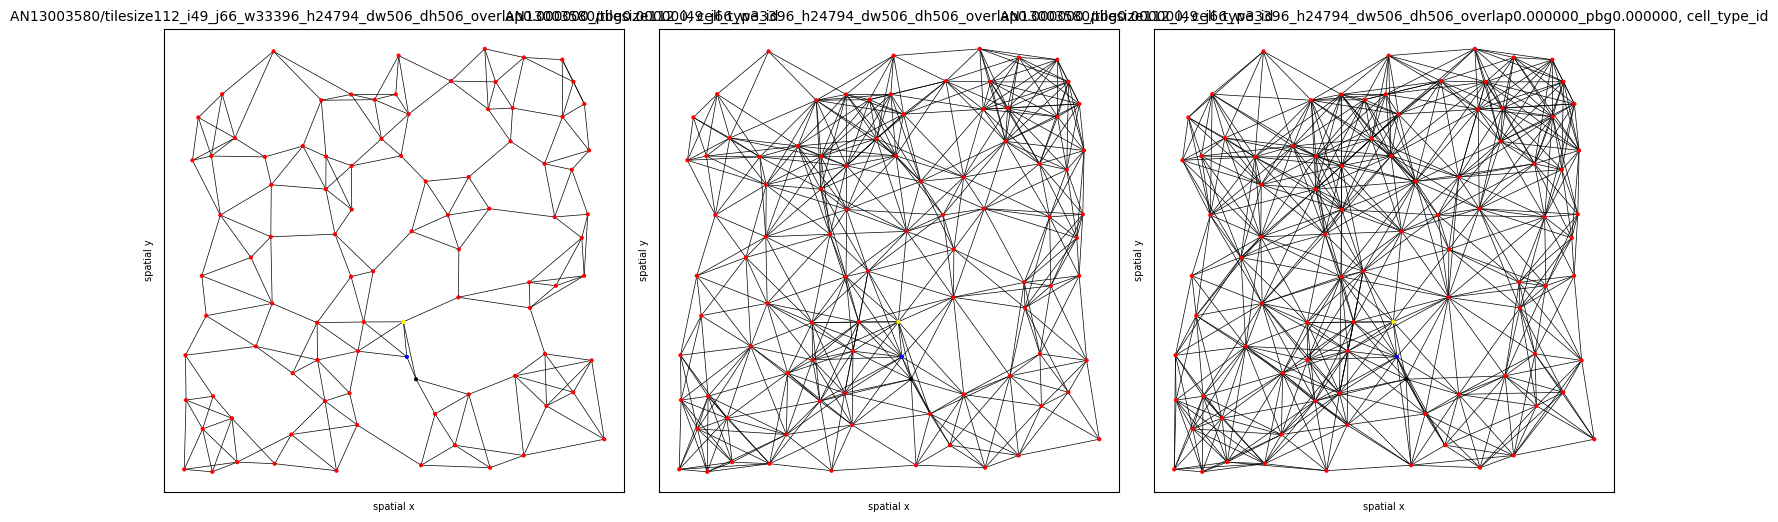

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)

sh.pl.spatial(so, spl, 'cell_type_id', edges=True, graph_key='knn', ax=axs.flat[0], cbar=False)
sh.pl.spatial(so, spl, 'cell_type_id', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
sh.pl.spatial(so, spl, 'cell_type_id', edges=True, graph_key='contact', ax=axs.flat[2], cbar=0)

# Heterogeneity quantification

In [ ]:
#on refait so spl par type

In [11]:
len(list(so.images.keys()))

1737

In [1]:
df_spl = pd.DataFrame()
df_spl['ID_patient'] = list(so.images.keys())
df_spl['Type'] = 'YO'
def status(x) :
    if 'CTR' in df_spl.at[x.name, 'ID_patient'] :
        df_spl.at[x.name, 'Type'] = 'CTR' 
df_spl.apply(status, axis=1)
df_spl

In [2]:
so.spl = df_spl
so.spl.set_index('ID_patient', inplace=True)
so.spl

In [14]:
#total count of cells
so.spl['cell_count'] = [len(so.obs[s]) for s in so.obs.keys()]

#counts per cell type
so.spl['inflammatory_cell_count'] = [np.sum(so.obs[s].cell_type == 'inflammatory') for s in so.obs.keys()]
so.spl['tumoral_cell_count'] = [np.sum(so.obs[s].cell_type == 'neoplastic') for s in so.obs.keys()]
so.spl['connective_cell_count'] = [np.sum(so.obs[s].cell_type == 'connective') for s in so.obs.keys()]
so.spl['non-neoplastic_epithelial_cell_count'] = [np.sum(so.obs[s].cell_type == 'non-neoplastic epithelial') for s in so.obs.keys()]
so.spl['dead_cell_count'] = [np.sum(so.obs[s].cell_type == 'dead') for s in so.obs.keys()]

#normalisation 
so.spl['cell_count/neoplastic'] = so.spl['cell_count']/so.spl['tumoral_cell_count']
so.spl['inflammatory_cell_count/neoplastic'] = so.spl['inflammatory_cell_count']/so.spl['tumoral_cell_count']
so.spl['connective_cell_count/neoplastic'] = so.spl['connective_cell_count']/so.spl['tumoral_cell_count']
so.spl['non-neoplastic_epithelilal_cell_count/neoplastic'] = so.spl['non-neoplastic_epithelial_cell_count']/so.spl['tumoral_cell_count']
so.spl['dead_cell_count/neoplastic'] = so.spl['dead_cell_count']/so.spl['tumoral_cell_count']



# Calculation number cells per patch

In [15]:
#from statannotations.Annotator import Annotator
import seaborn as sns
#import import_ipynb
%run utils.ipynb

# A few helper functions:
#from utils_test import *
#from utils import get_log_ax

# To illustrate examples
import numpy as np
from scipy.stats import mannwhitneyu, normaltest


def plott_boxplot_pvalue(plotting_parameters, max_):
    pairs = [('YO', 'CTR')]

    with sns.plotting_context('notebook', font_scale = 1.4):
        # Create new plot
        ax = plt.figure(figsize=(10,5))

       # ax = sns.boxplot(data=so.spl, x='cell_count_/neoplastic', y='Type')
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters)
        ax.set_ylim(0,max_)

        #boxplot = so.spl.boxplot(column=['cell_count_/neoplastic'], by=['Type'],return_type='axes')

        # Add annotations
        annotator = Annotator(ax,pairs, **plotting_parameters)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
        annotator.apply_and_annotate()

## Total cells count

Text(0.5, 1.2, 'Comparison of total cell counts densities beteween YO and control cohorts')

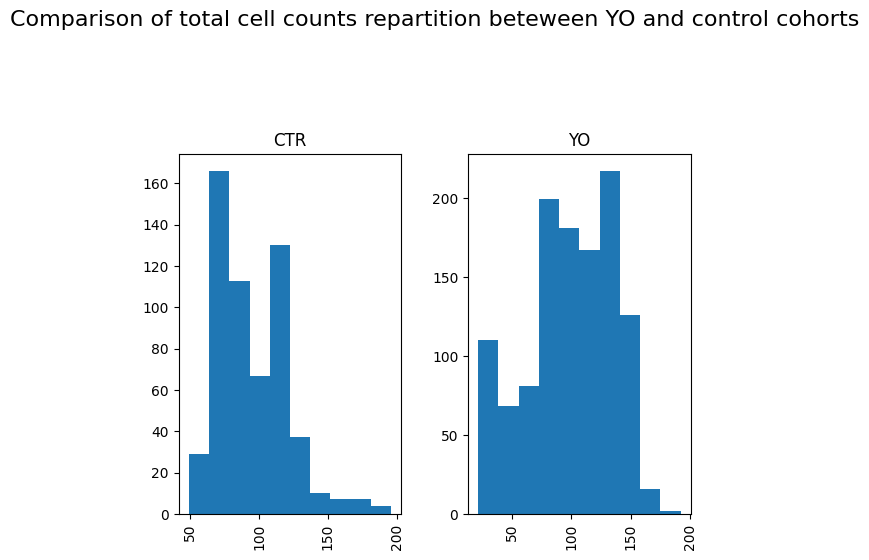

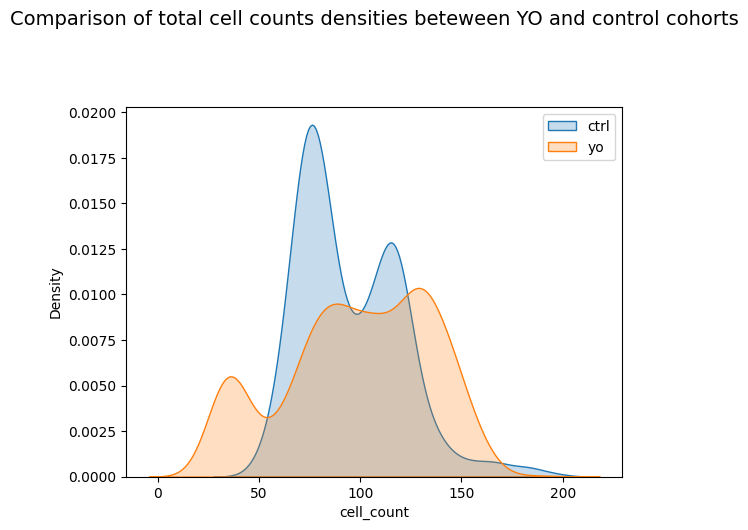

In [26]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

#Histogram
so.spl['cell_count'].hist(by=so.spl['Type'])
plt.suptitle('Comparison of total cell counts repartition beteween YO and control cohorts', fontsize=16, y=1.2)

#density

 ###split the data into groups based on types
g = so.spl.groupby('Type')
yo = g.get_group('YO')
ctrl = g.get_group('CTR')
fig, ax = plt.subplots()
ax = sns.kdeplot(data=ctrl['cell_count'], label='ctrl', ax=ax, shade=True)
ax = sns.kdeplot(data=yo['cell_count'], label='yo', ax=ax, shade=True)
ax.legend()
ax.set_title('Comparison of total cell counts densities beteween YO and control cohorts', fontsize=14,y=1.2)




Text(0.5, 1.2, 'Comparison of total cell counts/neoplastic densities beteween YO and control cohorts')

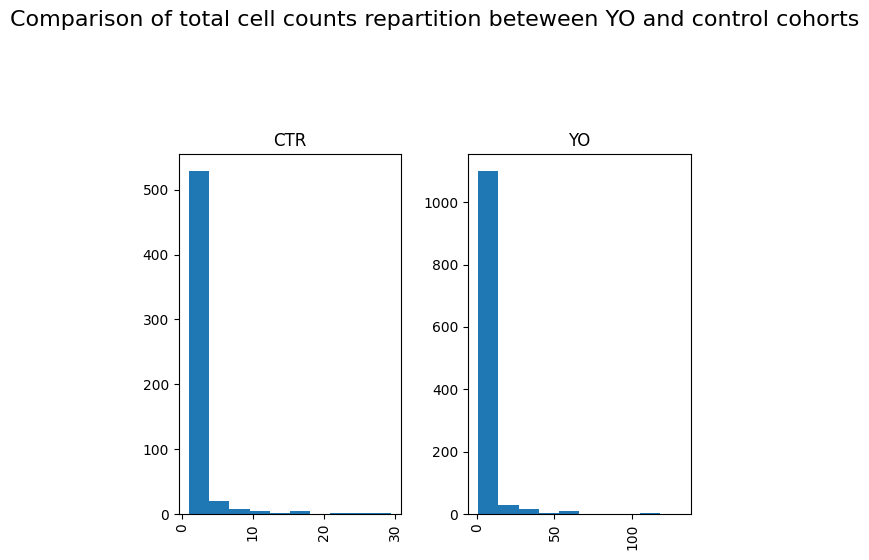

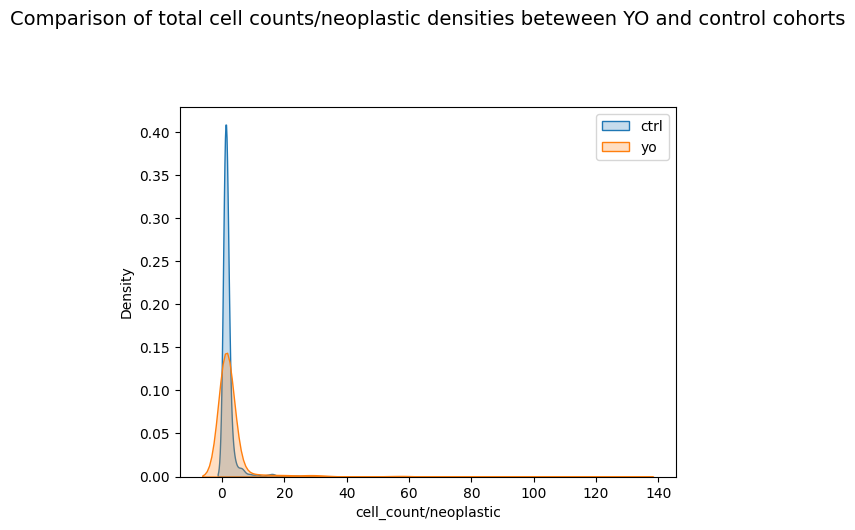

In [27]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

#Histogram
so.spl[so.spl['cell_count/neoplastic']!= np.inf]['cell_count/neoplastic'].hist(by=so.spl['Type'])
plt.suptitle('Comparison of total cell counts repartition beteween YO and control cohorts', fontsize=16, y=1.2)

#density

 ###split the data into groups based on types
g = so.spl.groupby('Type')
yo = g.get_group('YO')
ctrl = g.get_group('CTR')
fig, ax = plt.subplots()
ax = sns.kdeplot(data=ctrl['cell_count/neoplastic'], label='ctrl', ax=ax, shade=True)
ax = sns.kdeplot(data=yo['cell_count/neoplastic'], label='yo', ax=ax, shade=True)
ax.legend()
ax.set_title('Comparison of total cell counts/neoplastic densities beteween YO and control cohorts', fontsize=14,y=1.2)



## Type of cells

/home/user/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/user/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.2, 'Types of cells repartition for control cohort')

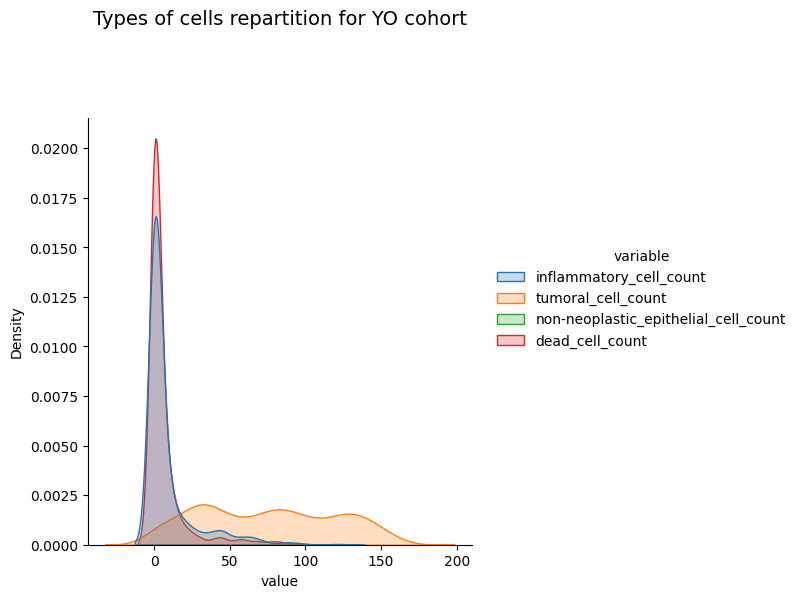

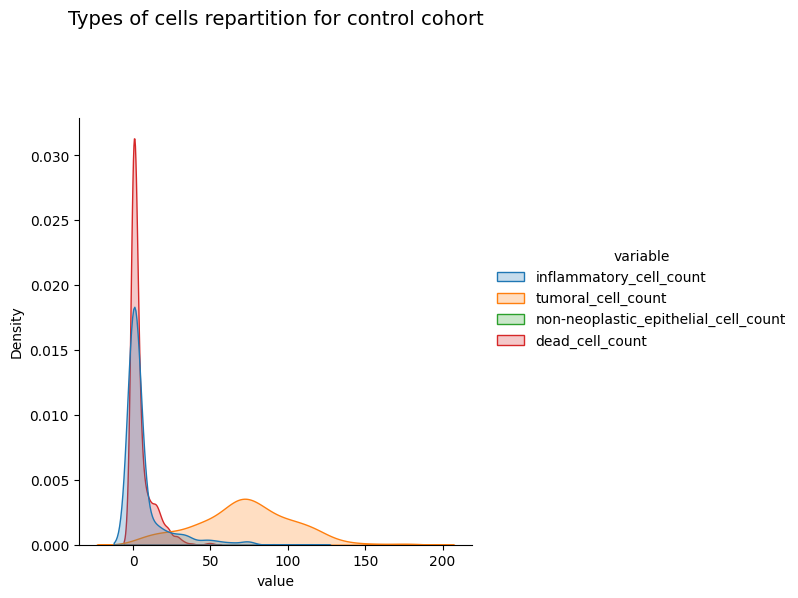

In [28]:
#so.spl.set_index('ID_file', inplace=True)
#yo_cells
yo_cells = so.spl[so.spl['Type'] == "YO"].filter(['inflammatory_cell_count', 'tumoral_cell_count', 'non-neoplastic_epithelial_cell_count','dead_cell_count'])
yo_cells = yo_cells.reset_index()
yo_cells_wtl = pd.melt(yo_cells, id_vars='ID_patient', value_vars=['inflammatory_cell_count', 'tumoral_cell_count', 'non-neoplastic_epithelial_cell_count','dead_cell_count'])
g = sns.displot(yo_cells_wtl, x="value", hue="variable", kind="kde", fill=True)
plt.title('Types of cells repartition for YO cohort', fontsize=14,y=1.2)


#ctrl_cells
ctrl_cells = so.spl[so.spl['Type'] == "CTR"].filter(['inflammatory_cell_count', 'tumoral_cell_count', 'non-neoplastic_epithelial_cell_count','dead_cell_count'])
ctrl_cells = ctrl_cells.reset_index()
ctrl_cells_wtl = pd.melt(ctrl_cells, id_vars='ID_patient', value_vars=['inflammatory_cell_count', 'tumoral_cell_count', 'non-neoplastic_epithelial_cell_count','dead_cell_count'])
sns.displot(ctrl_cells_wtl, x="value", hue="variable", kind="kde", fill=True)
plt.title('Types of cells repartition for control cohort', fontsize=14,y=1.2)


## Tumoral cells count

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:5.551e-01 U_stat=3.384e+05


Text(0.5, 1.2, 'Comparison of tumoral cells count between YO and control cohorts')

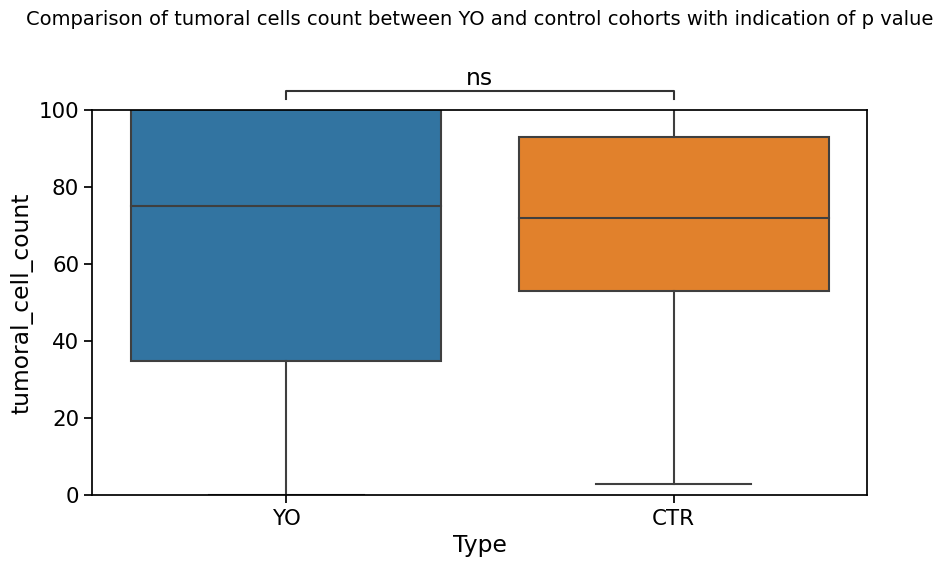

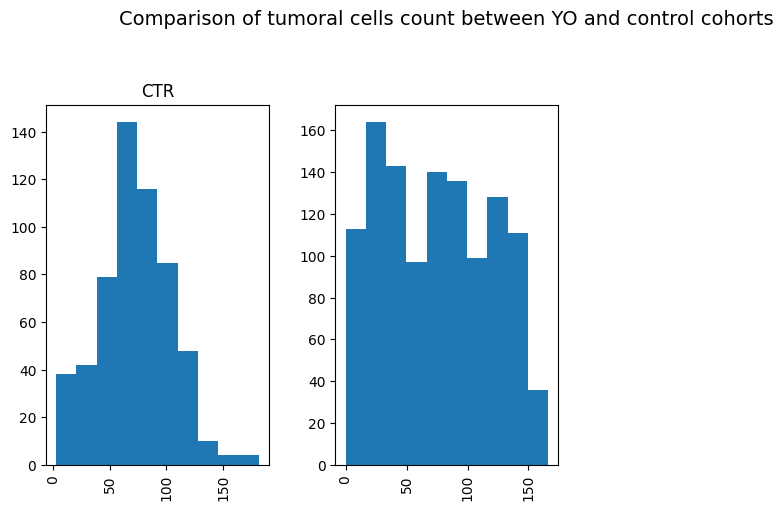

In [45]:
#Tumoral cell counts

#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'tumoral_cell_count'}

plott_boxplot_pvalue(plotting_parameters, 100)
plt.title('Comparison of tumoral cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram


so.spl['tumoral_cell_count'].hist(by=so.spl['Type'])
plt.title('Comparison of tumoral cells count between YO and control cohorts', fontsize=14,y=1.2)


## Inflammatory cells count

In [19]:
PATH_savefig = '/home/user/Pictures/images_article_Ovaires_YO/'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:1.810e-03 U_stat=3.614e+05


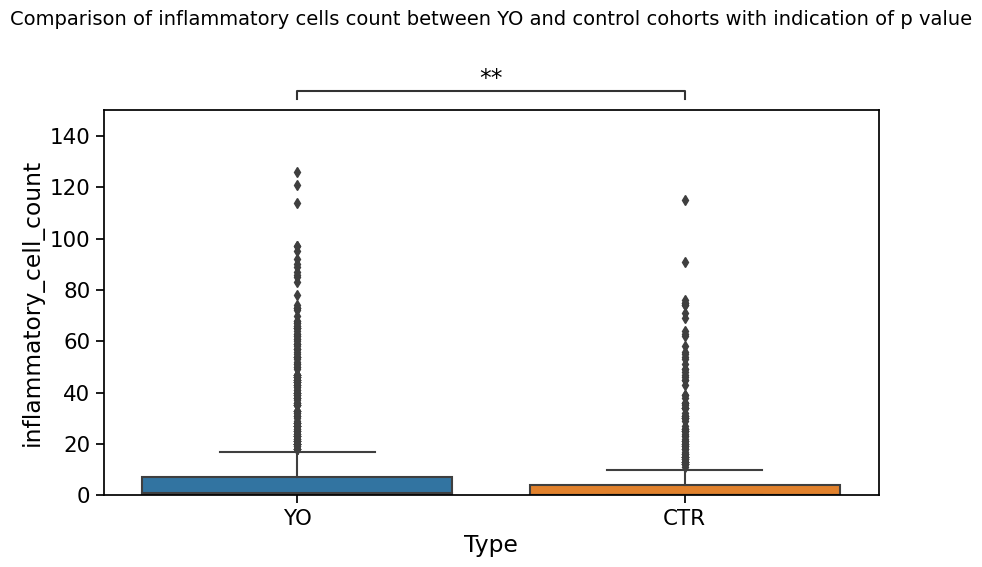

In [23]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'inflammatory_cell_count'}

plott_boxplot_pvalue(plotting_parameters, 150)
plt.title('Comparison of inflammatory cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
# so.spl['inflammatory_cell_count'].hist(by=so.spl['Type'])
# plt.title('Comparison of inflammatory cells count between YO and control cohorts', fontsize=14,y=1.2)
plt.savefig(PATH_savefig+'Comparison of inflammatory cells count between YO and control cohorts.png')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:1.520e-03 U_stat=3.619e+05


Text(0.5, 1.2, 'Comparison of inflammatory/neoplastic cells count between YO and control cohorts')

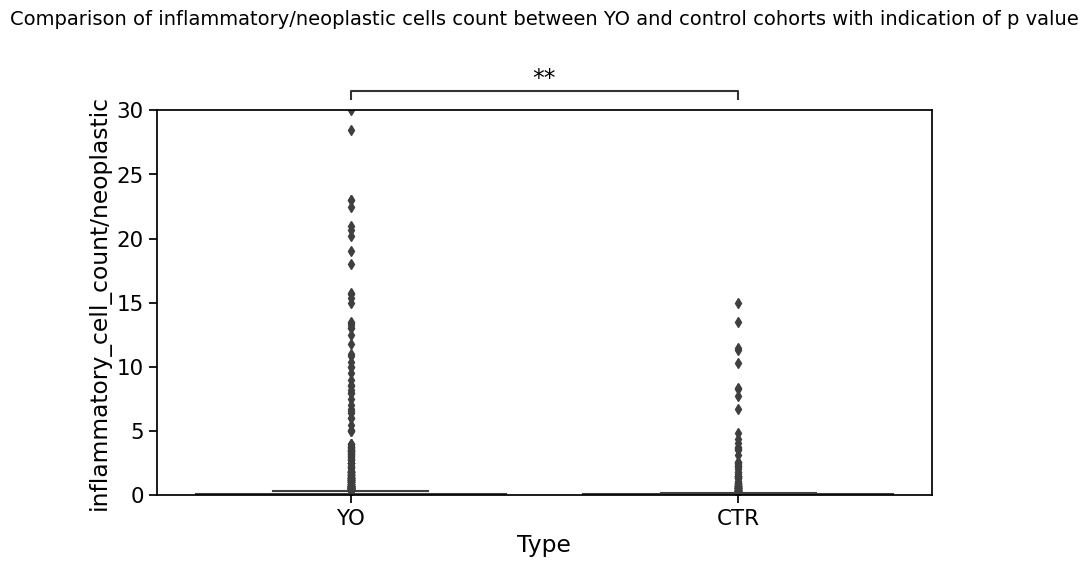

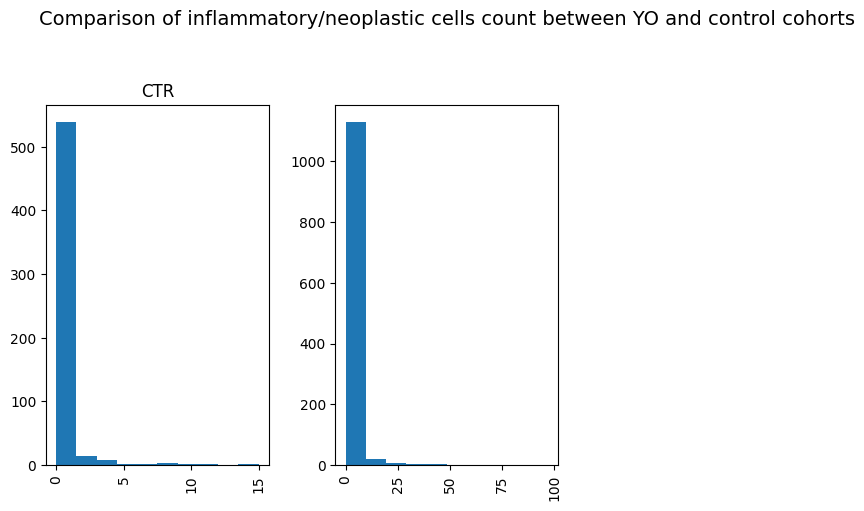

In [47]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'inflammatory_cell_count/neoplastic'}

plott_boxplot_pvalue(plotting_parameters, 30)
plt.title('Comparison of inflammatory/neoplastic cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl[so.spl['inflammatory_cell_count/neoplastic']!= np.inf]['inflammatory_cell_count/neoplastic'].hist(by=so.spl['Type'])
plt.title('Comparison of inflammatory/neoplastic cells count between YO and control cohorts', fontsize=14,y=1.2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:5.492e-01 U_stat=3.385e+05


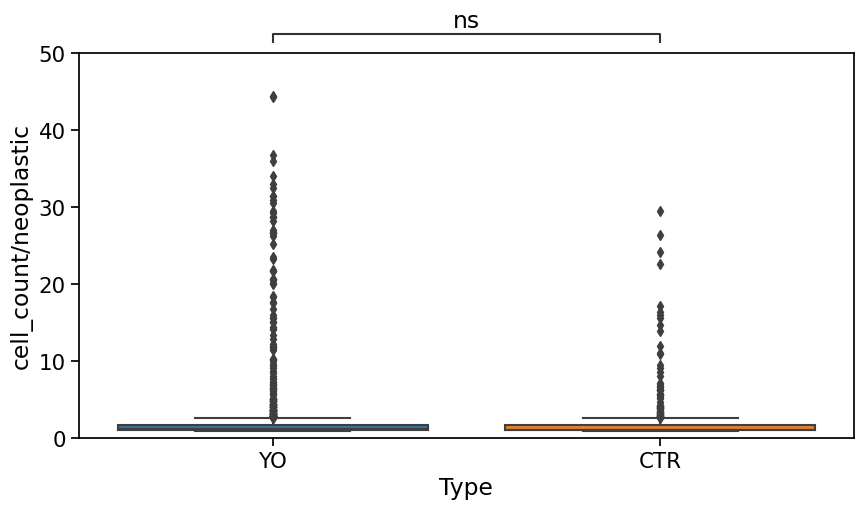

In [48]:
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'cell_count/neoplastic'}

plott_boxplot_pvalue(plotting_parameters, 50)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:1.520e-03 U_stat=3.619e+05


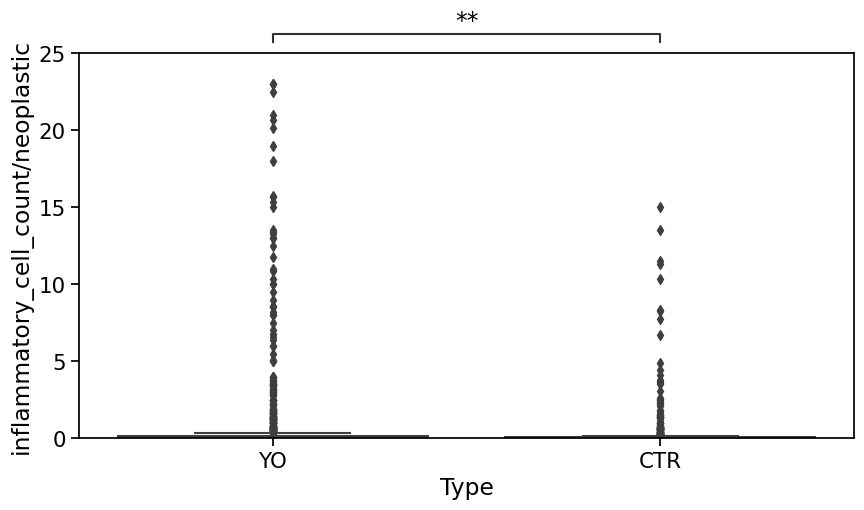

In [49]:
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'inflammatory_cell_count/neoplastic'}

plott_boxplot_pvalue(plotting_parameters, 25)

## Connective cells count

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:6.799e-04 U_stat=3.028e+05


Text(0.5, 1.2, 'Comparison of connective cells count between YO and control cohorts')

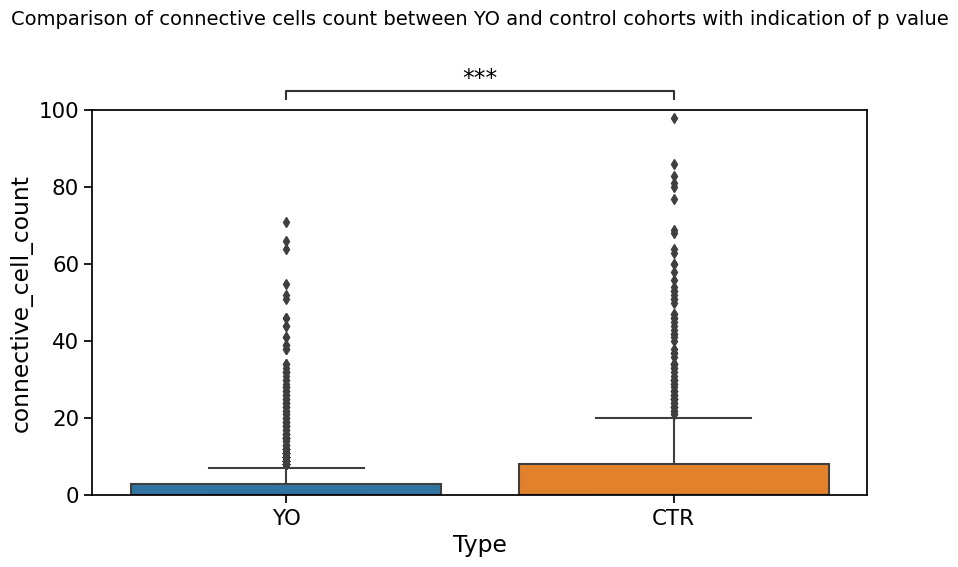

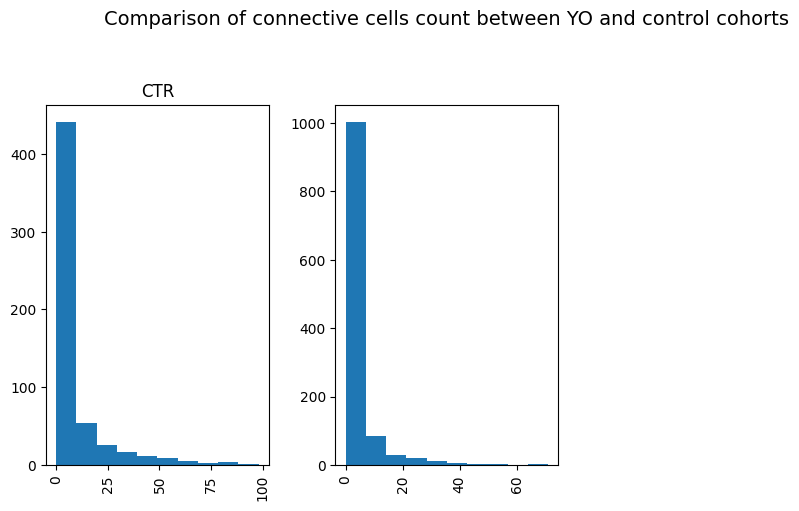

In [50]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'connective_cell_count'}

plott_boxplot_pvalue(plotting_parameters, 100)
plt.title('Comparison of connective cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl['connective_cell_count'].hist(by=so.spl['Type'])
plt.title('Comparison of connective cells count between YO and control cohorts', fontsize=14,y=1.2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:5.626e-02 U_stat=3.158e+05


Text(0.5, 1.2, 'Comparison of connective/neoplastic cells count between YO and control cohorts')

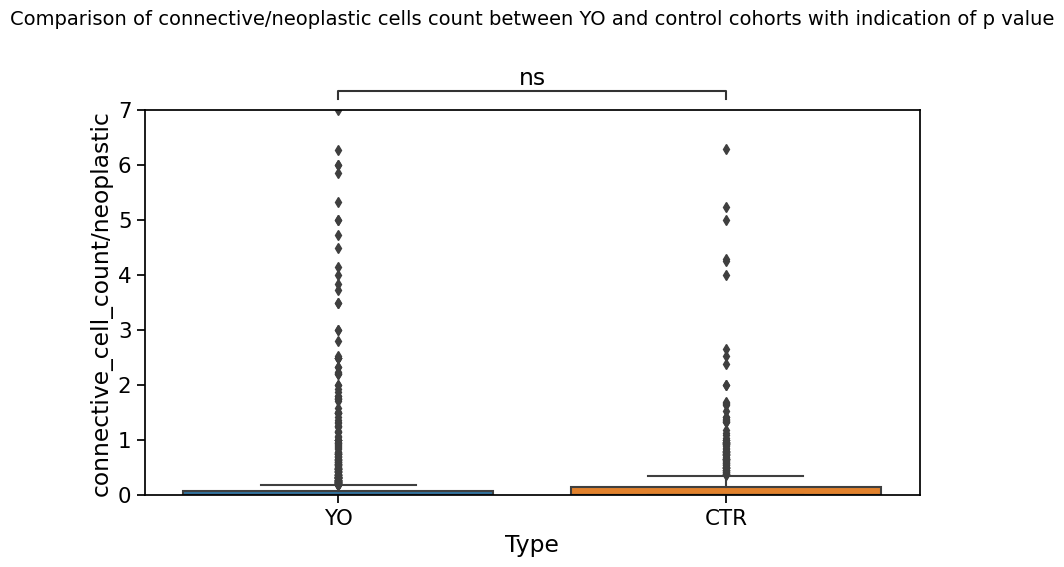

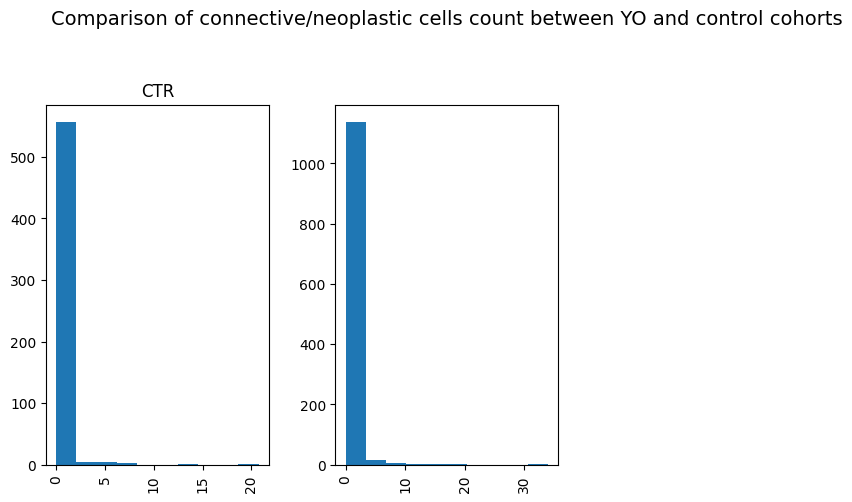

In [51]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'connective_cell_count/neoplastic'}

plott_boxplot_pvalue(plotting_parameters, 7)
plt.title('Comparison of connective/neoplastic cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl[so.spl['connective_cell_count/neoplastic']!= np.inf]['connective_cell_count/neoplastic'].hist(by=so.spl['Type'])
plt.title('Comparison of connective/neoplastic cells count between YO and control cohorts', fontsize=14,y=1.2)


## Non-neoplastic epithelial

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.326e+05


Text(0.5, 1.2, 'Comparison of non-neoplastic_epithelial cells count between YO and control cohorts')

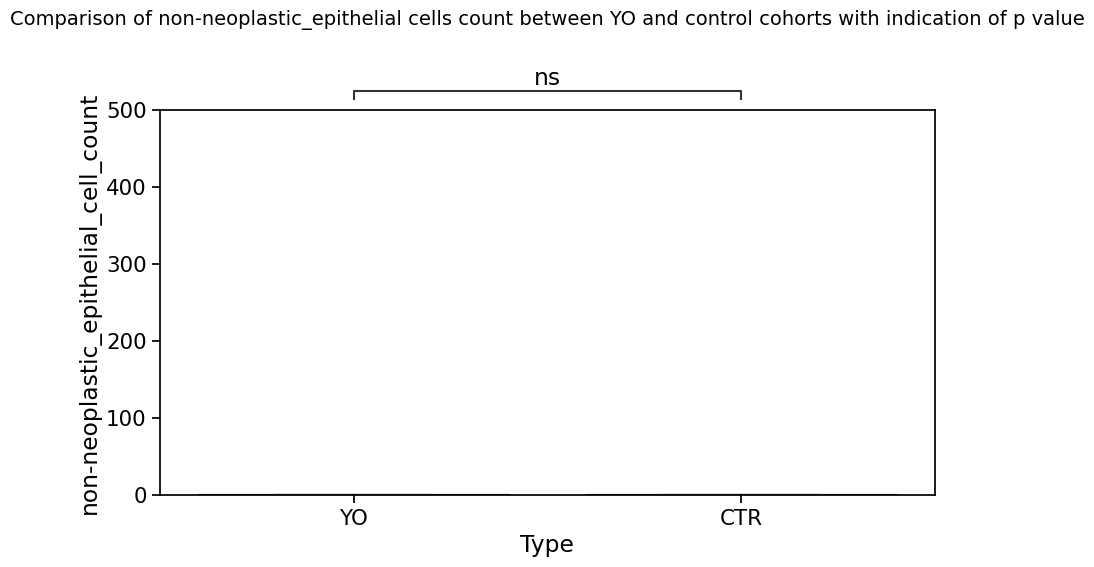

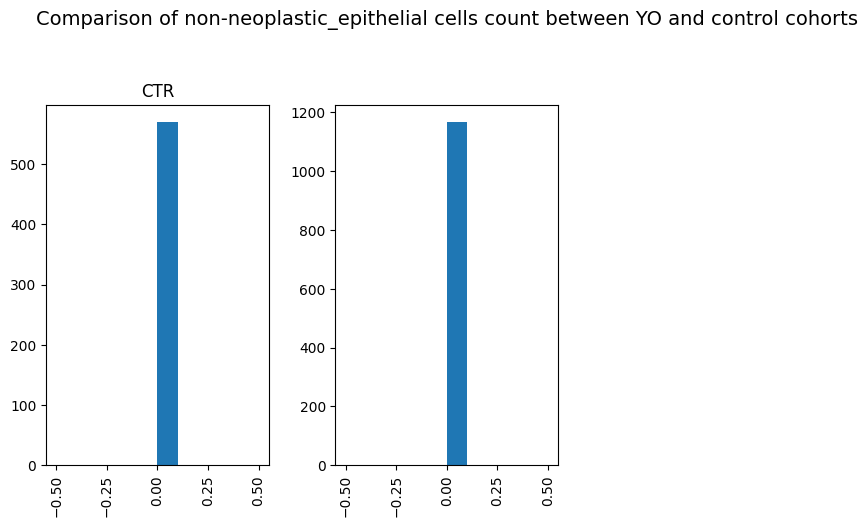

In [52]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'non-neoplastic_epithelial_cell_count'}

plott_boxplot_pvalue(plotting_parameters, 500)
plt.title('Comparison of non-neoplastic_epithelial cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl['non-neoplastic_epithelial_cell_count'].hist(by=so.spl['Type'])
plt.title('Comparison of non-neoplastic_epithelial cells count between YO and control cohorts', fontsize=14,y=1.2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.309e+05


Text(0.5, 1.2, 'Comparison of inflammatory/neoplastic cells count between YO and control cohorts')

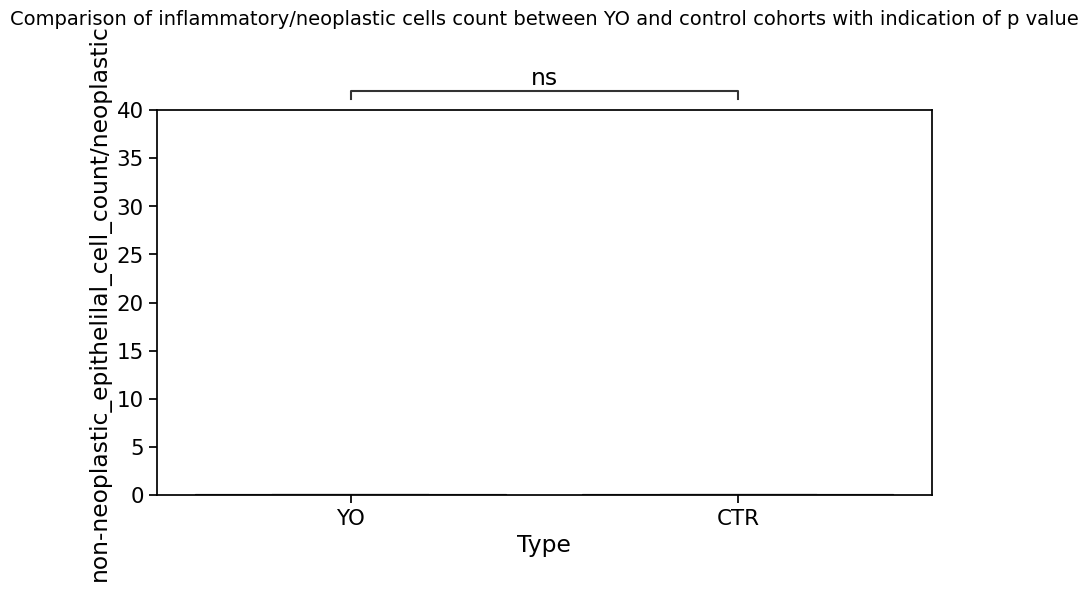

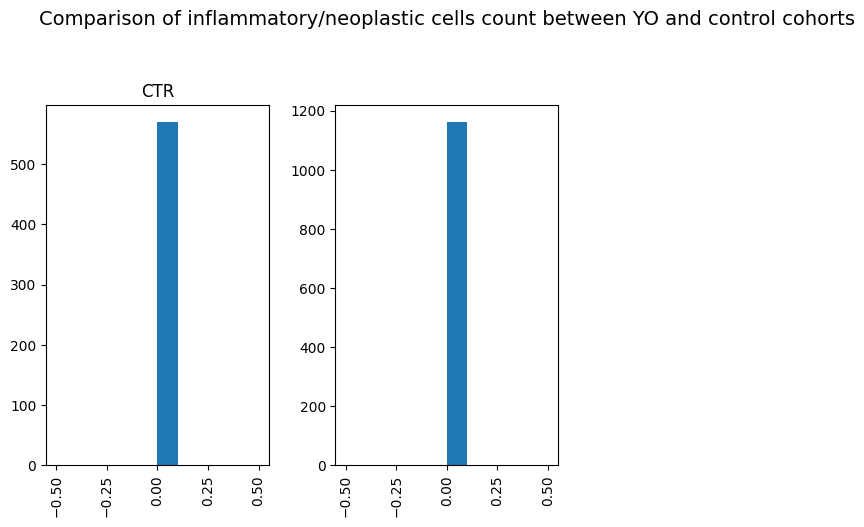

In [53]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'non-neoplastic_epithelilal_cell_count/neoplastic'}

plott_boxplot_pvalue(plotting_parameters, 40)
plt.title('Comparison of inflammatory/neoplastic cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl[so.spl['non-neoplastic_epithelilal_cell_count/neoplastic']!= np.inf]['non-neoplastic_epithelilal_cell_count/neoplastic'].hist(by=so.spl['Type'])
plt.title('Comparison of inflammatory/neoplastic cells count between YO and control cohorts', fontsize=14,y=1.2)


## Dead cells count

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:2.050e-01 U_stat=3.206e+05


Text(0.5, 1.2, 'Comparison of dead cells count between YO and control cohorts')

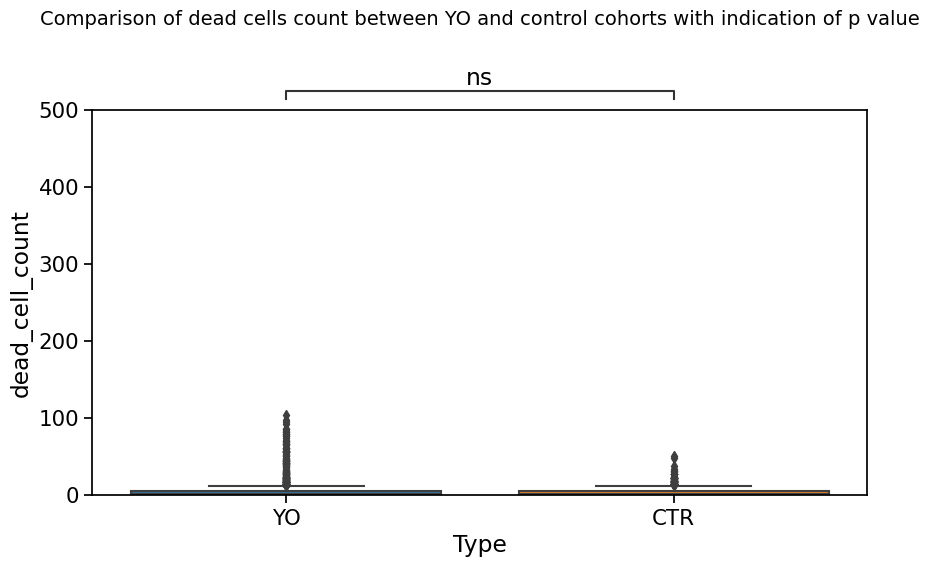

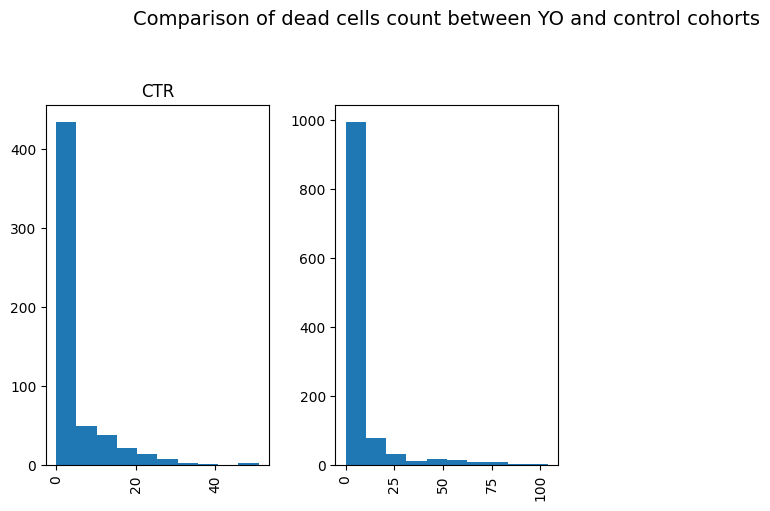

In [54]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'dead_cell_count'}

plott_boxplot_pvalue(plotting_parameters, 500)
plt.title('Comparison of dead cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl['dead_cell_count'].hist(by=so.spl['Type'])
plt.title('Comparison of dead cells count between YO and control cohorts', fontsize=14,y=1.2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:7.441e-01 U_stat=3.292e+05


Text(0.5, 1.2, 'Comparison of dead/neoplastic cells count between YO and control cohorts')

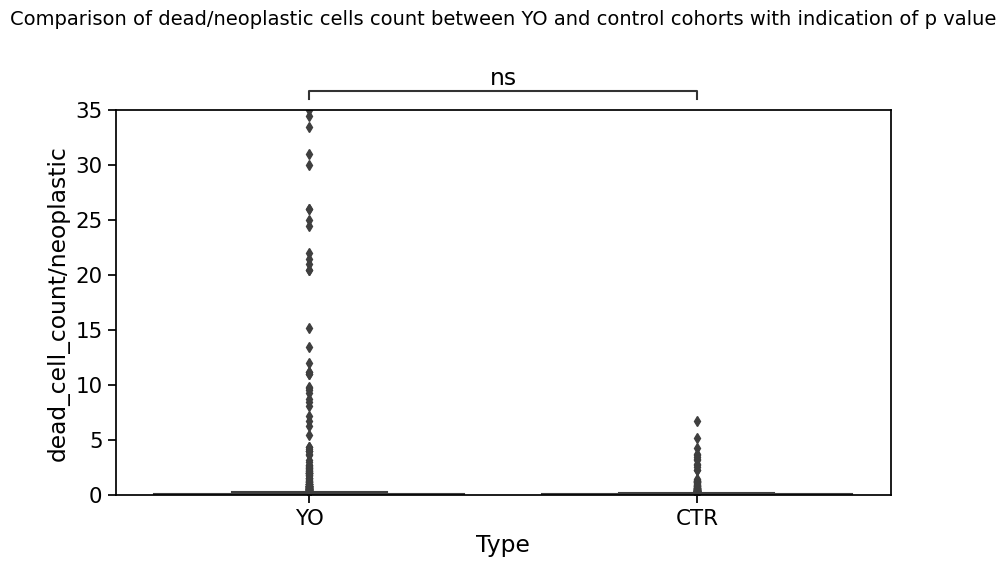

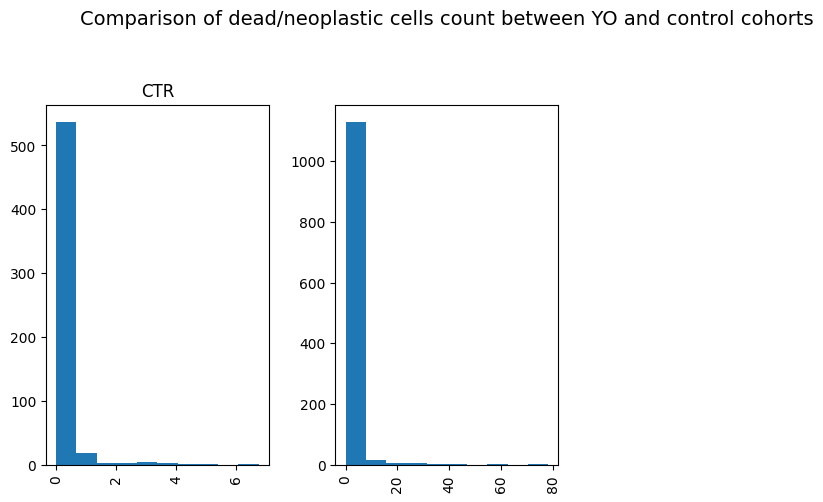

In [55]:
#boxplot
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'dead_cell_count/neoplastic'}

plott_boxplot_pvalue(plotting_parameters, 35)
plt.title('Comparison of dead/neoplastic cells count between YO and control cohorts with indication of p value', fontsize=14,y=1.2)

#Histogram
so.spl[so.spl['dead_cell_count/neoplastic']!= np.inf]['dead_cell_count/neoplastic'].hist(by=so.spl['Type'])
plt.title('Comparison of dead/neoplastic cells count between YO and control cohorts', fontsize=14,y=1.2)


## Entropy

In [32]:
from sklearn.preprocessing import StandardScaler

def _process_input(counts) -> np.ndarray:
    # check that input is not empty
    if len(counts) == 0:
        warnings.warn('counts is an empty object.')
        return np.array([np.nan])

    # convert to numpy array
    if isinstance(counts, Counter):
        c = np.fromiter(counts.values(), dtype=int)
    elif is_list_like(counts):
        c = np.asarray(counts)
    else:
        raise TypeError(f'counts is neither a counter nor list-like')

    # validate input
    if c.dtype == int:
        c = _counts_to_props(c)
    elif c.dtype == float:
        _validate_props_vector(c)
    else:
        raise TypeError(
            f'counts has an invalid type {type(c.dtype)}. Must be `int` for counts and `float` for probabilities.')

    return c


def _validate_counts_vector(counts):
    '''Validate counts vector.
    Parameters
    ----------
    counts: numpy 1d array of type int
    '''

    if not isinstance(counts, np.ndarray):
        raise TypeError(f'counts vector is not an numpy.ndarray but {type(counts)}')
    if np.isnan(counts).any():
        raise ValueError("counts vector contains nan values.")
    if counts.dtype != int:
        raise TypeError(f'counts should have type `int`, found invalid type {counts.dtype}')
    if counts.ndim != 1:
        raise ValueError("Only 1-D vectors are supported.")
    if (counts < 0).any():
        raise ValueError("Counts vector cannot contain negative values.")


def _counts_to_props(counts):
    """Validates and converts counts to probabilities"""
    _validate_counts_vector(counts)
    props = counts / counts.sum()
    _validate_props_vector(props)
    return props


def _validate_props_vector(props):
    '''Validate props vector.
    Parameters
    ----------
    props: numpy 1d array of type float
    '''

    if not isinstance(props, np.ndarray):
        raise TypeError(f'Probabilities vector is not an numpy.ndarray but {type(props)}')
    if props.dtype != float:
        raise TypeError(f'Probabilities should have type `float`, found invalid type {props.dtype}')
    if props.ndim != 1:
        raise ValueError("Only 1-D vectors are supported.")
    if (props < 0).any():
        raise ValueError("Probabilities vector cannot contain negative values.")
    if (props > 1).any():
        raise ValueError("Probabilities vector cannot contain values larger than 1.")
    if np.isnan(props).any():
        raise ValueError("Probabilities vector contains nan values.")
    if not np.isclose(props.sum(), 1):
        raise ValueError(f'Probabilities do not sum to 1, props.sum = {props.sum()}')
        
        
        
from pandas.api.types import is_categorical_dtype, is_numeric_dtype

def is_categorical(*args, **kwargs):
    return is_categorical_dtype(*args, **kwargs)


from typing import Counter as ct, Iterable, Union
from collections import Counter
from scipy.spatial.distance import cdist


def _compute_metric(so, spl: str, attr, key_added, graph_key, metric, kwargs_metric, local, inplace=True):
    """Computes the given metric for each observation or the sample
    """

    # generate a copy if necessary
    so = so if inplace else so.copy()

    # extract relevant categorisation
    data = so.obs[spl][attr]
    if not is_categorical(data):
        raise TypeError('`attr` needs to be categorical')

    if local:
        # get graph
        g = so.G[spl][graph_key]

        # compute metric for each observation
        res = []
        observation_ids = so.obs[spl].index
        for observation_id in observation_ids:
            n = list(g.neighbors(observation_id))
            if len(n) == 0:
                res.append(0)
                continue
            counts = Counter(data.loc[n].values)
            res.append(metric(counts, **kwargs_metric))

        if np.ndim(res[0]) > 0:
            res = pd.DataFrame(res, index=observation_ids)
            if spl not in so.obsm:
                so.obsm[spl] = {}
            so.obsm[spl][key_added] = res
        else:
            res = pd.DataFrame({key_added: res}, index=observation_ids)
            if key_added in so.obs[spl]:  # drop previous computation of metric
                so.obs[spl].drop(key_added, 1, inplace=True)
            so.obs[spl] = pd.concat((so.obs[spl], res), axis=1)
    else:
        res = metric(Counter(data), **kwargs_metric)

        if np.ndim(res) > 0:
            if spl not in so.uns:
                so.uns[spl] = {}
            so.uns[spl][key_added] = res
        else:
            so.spl.loc[spl, key_added] = res
            
    if not inplace:
        return so
    
def _richness(counts: Union[ct, Iterable]) -> int:
    """Compute richness.
    Args:
        counts: Either counts or observations
    Returns:
        Richness of sample.
    """

    props = _process_input(counts)

    if np.isnan(props).any():
        # this would correspond to richness == 0
        return 0

    return len(props)

def _shannon(counts: Union[ct, Iterable], base: float = 2) -> float:
    """Compute the shannon entropy of the counts.
    Args:
        counts: If a Counter object or an interable with intergers is provided it is assumed that those are counts of the different species.
                If the iterable contains dtype `float` it is interpreted as probabilities of the different classes
        base: Base of logarithm. Defaults to 2
    Returns:
        Shannon entropy of observations.
    """

    props = _process_input(counts)

    nonzero_props = props[props.nonzero()]  # by definition log(0) is 0 for entropy
    return -(nonzero_props * np.log(nonzero_props)).sum() / np.log(base)

def richness(so, spl: str, attr: str, *, local=True, key_added=None, graph_key='knn', inplace=True) -> None:
    """Computes the richness on the observation or the sample level

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        local: Whether to compute the metric on the observation or the sample level
        key_added: Key added to either obs or spl depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Returns:

    """

    if key_added is None:
        key_added = 'richness'
        key_added = f'{key_added}_{attr}'
        if local:
            key_added += f'_{graph_key}'

    metric = _richness
    kwargs_metric = {}

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, graph_key=graph_key, metric=metric,
                           kwargs_metric=kwargs_metric,
                           local=local, inplace=inplace)

def simpson(so, spl: str, attr: str, *, local=True, key_added=None, graph_key='knn', inplace=True) -> None:
    """Computes the Simpson Index on the observation or the sample level

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        local: Whether to compute the metric on the observation or the sample level
        key_added: Key added to either obs or spl depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Returns:

    """
    if key_added is None:
        key_added = 'simpson'
        key_added = f'{key_added}_{attr}'
        if local:
            key_added += f'_{graph_key}'

    metric = _simpson
    kwargs_metric = {}

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, graph_key=graph_key, metric=metric,
                           kwargs_metric=kwargs_metric,
                           local=local, inplace=inplace)
def _simpson(counts: Union[ct, Iterable]) -> float:
    """Compute Simpson Index.
    Args:
        counts: If a Counter object or an interable with intergers is provided it is assumed that those are counts of the different species.
                If the iterable contains dtype `float` it is interpreted as probabilities of the different classes
    Returns:
        Simpson index.
    Notes:
        Implementation according to [2].
        Simpson's index is also considering both richness and evenness,
        but compared to Shannon it is more influenced by evenness than richness. It represents the probability that two randomly selected individuals will be of the same species. Since this probability decreases with increasing species richness, the Simpson index also decreases with richness, which is not too intuitive. For that reason, more meaningful is to use Gini-Simpson index, which is simply 1-Simpson index, and which with increasing richness increases [2]
        Simpson's index is heavily weighted towards the most abundant species in the sample, while being less sensitive to species richness.[1]
    References:
        .. [1]: http://www.pisces-conservation.com/sdrhelp/index.html
        .. [2]: https://anadat-r.davidzeleny.net/doku.php/en:div-ind#fnt__2
    """

    props = _process_input(counts)
    return (props ** 2).sum()

def shannon(so, spl: str, attr: str, *, local=True, key_added=None, graph_key='knn', base=2, inplace=True) -> None:
    """Computes the Shannon Index on the observation or the sample level

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        local: Whether to compute the metric on the observation or the sample level
        key_added: Key added to either obs or spl depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Returns:

    """
    if key_added is None:
        key_added = 'shannon'
        key_added = f'{key_added}_{attr}'
        if local:
            key_added += f'_{graph_key}'

    metric = _shannon
    kwargs_metric = {'base': base}

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, graph_key=graph_key, metric=metric,
                           kwargs_metric=kwargs_metric,
                           local=local, inplace=inplace)

def hill_number(so, spl: str, attr: str, q: float, *, local=True, key_added=None, graph_key='knn', inplace=True):
    """Computes the Hill Numbers on the observation or the sample level

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        local: Whether to compute the metric on the observation or the sample level
        key_added: Key added to either obs or spl depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Returns:

    """
    if key_added is None:
        key_added = 'hill_number'
        key_added = f'{key_added}_{attr}_q{q}'
        if local:
            key_added += f'_{graph_key}'

    metric = _hill_number
    kwargs_metric = {'q': q}

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, graph_key=graph_key, metric=metric,
                           kwargs_metric=kwargs_metric,
                           local=local, inplace=inplace)



def renyi_entropy(so, spl: str, attr: str, q: float, *, local=True, key_added=None, graph_key='knn', base=2,
                  inplace=True):
    """Computes the Renyi-Entropy

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        local: Whether to compute the metric on the observation or the sample level
        key_added: Key added to either obs or spl depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Returns:

    """
    if key_added is None:
        key_added = 'renyi'
        key_added = f'{key_added}_{attr}_q{q}'
        if local:
            key_added += f'_{graph_key}'

    metric = _renyi
    kwargs_metric = {'q': q,
                     'base': base}

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, graph_key=graph_key, metric=metric,
                           kwargs_metric=kwargs_metric,
                           local=local, inplace=inplace)



def quadratic_entropy(so, spl: str, attr: str, *, metric='minkowski', metric_kwargs={}, scale: bool = True,
                      local=True, key_added=None, graph_key='knn', inplace=True):
    """Computes the quadratic entropy, taking relative abundance and similarity between observations into account.

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        metric: metric used to compute distance of observations in the features space so.X[spl]
        metric_kwargs: key word arguments for metric
        scale: whether to scale features of observations to unit variance and 0 mean
        local: whether to compute the metric on the observation or the sample level
        key_added: Key added to either obs or spl depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Notes:
        The implementation computes an average feature vector for each group in attr based on all observations in the
        sample. Thus, if staining biases across samples exists this will directly distort this metric.

    Returns:
        float, quadratic entropy

    """
    if key_added is None:
        key_added = 'quadratic'
        key_added = f'{key_added}_{attr}'
        if local:
            key_added += f'_{graph_key}'

    # collect feature vectors of all observations and add attr grouping
    features: pd.DataFrame = so.X[spl]
    features = features.merge(so.obs[spl][attr], right_index=True, left_index=True)
    assert len(features) == len(so.X[spl]), 'inner merge resulted in dropped index ids'

    # compute average feature vector for each attr group and standardise
    features = features.groupby(attr).mean()
    if scale:
        tmp = StandardScaler().fit_transform(features)
        features = pd.DataFrame(tmp, index=features.index, columns=features.columns)

    base_metric = _quadratic_entropy
    kwargs_metric = {'features': features,
                     'metric': metric,
                     'metric_kwargs': metric_kwargs,
                     'scale': False}  # we scaled already

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, graph_key=graph_key, metric=base_metric,
                           kwargs_metric=kwargs_metric,
                           local=local, inplace=inplace)



def abundance(so, spl: str, attr: str, *, mode='proportion', key_added: str = None, graph_key='knn',
              local=False, inplace: bool = True):
    """Computes the abundance of species on the observation or the sample level.

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        local: Whether to compute the metric on the observation or the sample level
        key_added: Key added to either uns[spl] or obs depending on the choice of `local`
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.

    Returns:

    """

    if key_added is None:
        key_added = f'{mode}'
        if local:
            key_added += f'_{graph_key}'

    event_space = so.obs[spl][attr]
    if is_categorical(event_space):
        event_space = event_space.dtypes.categories
    else:
        raise TypeError(f'{attr} is not categorical')

    metric = _abundance
    kwargs_metric = {'event_space': event_space,
                     'mode': mode}

    return _compute_metric(so=so, spl=spl, attr=attr, key_added=key_added, metric=metric, graph_key=graph_key,
                           kwargs_metric=kwargs_metric, local=local, inplace=inplace)



def _compute_metric(so, spl: str, attr, key_added, graph_key, metric, kwargs_metric, local, inplace=True):
    """Computes the given metric for each observation or the sample
    """

    # generate a copy if necessary
    so = so if inplace else so.copy()

    # extract relevant categorisation
    data = so.obs[spl][attr]
    if not is_categorical(data):
        raise TypeError('`attr` needs to be categorical')

    if local:
        # get graph
        g = so.G[spl][graph_key]

        # compute metric for each observation
        res = []
        observation_ids = so.obs[spl].index
        for observation_id in observation_ids:
            n = list(g.neighbors(observation_id))
            if len(n) == 0:
                res.append(0)
                continue
            counts = Counter(data.loc[n].values)
            res.append(metric(counts, **kwargs_metric))

        if np.ndim(res[0]) > 0:
            res = pd.DataFrame(res, index=observation_ids)
            if spl not in so.obsm:
                so.obsm[spl] = {}
            so.obsm[spl][key_added] = res
        else:
            res = pd.DataFrame({key_added: res}, index=observation_ids)
            if key_added in so.obs[spl]:  # drop previous computation of metric
                so.obs[spl].drop(key_added, 1, inplace=True)
            so.obs[spl] = pd.concat((so.obs[spl], res), axis=1)
    else:
        res = metric(Counter(data), **kwargs_metric)

        if np.ndim(res) > 0:
            if spl not in so.uns:
                so.uns[spl] = {}
            so.uns[spl][key_added] = res
        else:
            so.spl.loc[spl, key_added] = res

    if not inplace:
        return so
    
def _hill_number(counts: Union[ct, Iterable], q: float) -> float:
    """Compute the hill number.
    Notes:
        [1]: https://anadat-r.davidzeleny.net/doku.php/en:div-ind#fnt__2
    Args:
        counts: If a Counter object or an interable with intergers is provided it is assumed that those are counts of the different species.
                If the iterable contains dtype `float` it is interpreted as probabilities of the different classes
        q: Order of hill number.
    Returns:
        Hill number.
    """

    if q < 0:
        warnings.warn('q is generally limited to non-negative values')

    if q == 1:
        # exponential of shannon entropy with base e
        return np.exp(_shannon(counts, np.exp(1)))

    props = _process_input(counts)

    if q == np.inf:
        return 1 / np.max(props)

    nonzero_props = props[props.nonzero()]
    return np.power(np.sum(nonzero_props ** q), (1 / (1 - q)))


def _renyi(counts: Union[ct, Iterable],
           q: float,
           base: float = 2) -> float:
    """Computes the Renyi-Entropy of order q.
    Args:
         counts: If a Counter object or an interable with intergers is provided it is assumed that those are counts of the different species.
                If the iterable contains dtype `float` it is interpreted as probabilities of the different classes
        q: Order of Renyi-Entropy.
        base: Base of logarithm.
    Returns:
        Renyi-Entropy of order q.
    """

    if q < 0:
        warnings.warn('q is generally limited to non-negative values')

    props = _process_input(counts)

    if q == 1:
        # special case q == 1: shannon entropy
        return _shannon(counts, base)

    if q == np.inf:
        return - np.log(np.max(props)) / np.log(base)

    return 1 / (1 - q) * np.log(np.sum(props ** q)) / np.log(base)


def _quadratic_entropy(counts: ct, features: pd.DataFrame, metric: str = 'minkowski', metric_kwargs: dict = {'p':2}, scale: bool = True) -> float:
    """
    Args:
        counts: Counter object with counts of observed species / instances
        features: pandas.DataFrame with index representing instances / species and columns features of these instances
        metric: metric to compute distance between instances in the features space
        metric_kwargs: key word arguments to the metric
        scale: whether to scale the features to zero mean and unit variance
    Returns:
        float
    """

    # check that all instances in counts are in features
    if not np.all([i in features.index for i in counts]):
        raise KeyError(f'not all instances in counts are in the features index')

    # order elements in features according to counts and drop excess features
    features = features.loc[counts.keys()]

    # scale features
    # NOTE: If features are not scaled over-proportional weight might be given to some features
    if scale:
        features = StandardScaler().fit_transform(features)

    props = _process_input(counts)
    D = cdist(features, features, metric, **metric_kwargs)

    return props@D@props

# ----- MULTIDIMENSIONAL MEASURES -----#

def _abundance(counts: Union[ct, Iterable], mode='proportion', event_space=None) -> pd.Series:
    """Compute abundance of different species in counts
    Args:
        counts: If a Counter object or an interable with intergers is provided it is assumed that those are counts of the different species.
        mode: Either `proportion` or `counts`. If `proportion` we compute the frequency of the species, else the absolute counts.
        event_space: If provided, computes the abundance of all species in the event space. Useful to compute results including all species even of those not present in the current counts.
    Returns:
        Abundance of species, either as frequency (proportion) or absolute count.
    """
    VALID_MODES = ['proportion', 'count']
    # if a counter is provided we will add zero counts for all the events in the event space
    # if an list-like object is provided we compute the counts first
    if event_space is not None:
        c0 = Counter({i: 0 for i in event_space})
        counts.update(c0)

    if not isinstance(counts, Counter):
        counts = Counter({key:val for key, val in zip(range(len(counts)), counts)})
        # counts = Counter(counts)

    index = counts.keys()
    if mode == 'proportion':
        vals = _process_input(counts)
        dtype = float
    elif mode == 'count':
        vals = np.asarray(list(counts.values()))
        _validate_counts_vector(vals)
        dtype = int
    else:
        raise ValueError(f'{mode} is not a valid mode, available are {VALID_MODES}')

    return pd.Series(vals, index=index, dtype=dtype)


In [3]:
all_samples = so.spl.index.values

for s in so.spl.index.values :
    richness(so, s, 'cell_type_id',local=False)
    shannon(so, s, 'cell_type_id', local=False,inplace=True)
    simpson(so, s, 'cell_type_id',local=False,inplace=True)

# estimated values are saved in so.spl    
so.spl[['cell_count','richness_cell_type_id', 'shannon_cell_type_id', 'simpson_cell_type_id']]

In [35]:
count = 0
for spl in so.G.keys() :
    if list(so.G[spl].keys()) != ['knn', 'radius', 'contact'] :
        print(spl)
        count += 1
count

0

In [36]:
from tqdm import tqdm


In [4]:
# compute metrics at a cell level for all samples - this will take some time
for s in tqdm(all_samples):
    #print(s)

    richness(so, s, 'cell_type_id', local=True, graph_key='contact')
    shannon(so, s, 'cell_type_id', local=True, graph_key='contact')
    quadratic_entropy(so, s, 'cell_type_id', local=True, graph_key='knn')

# estimated values are saved in so.obs
so.obs[spl].columns

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:9.681e-01 U_stat=3.322e+05


Text(0.5, 1.2, 'Comparison of shannon value between YO and control cohorts')

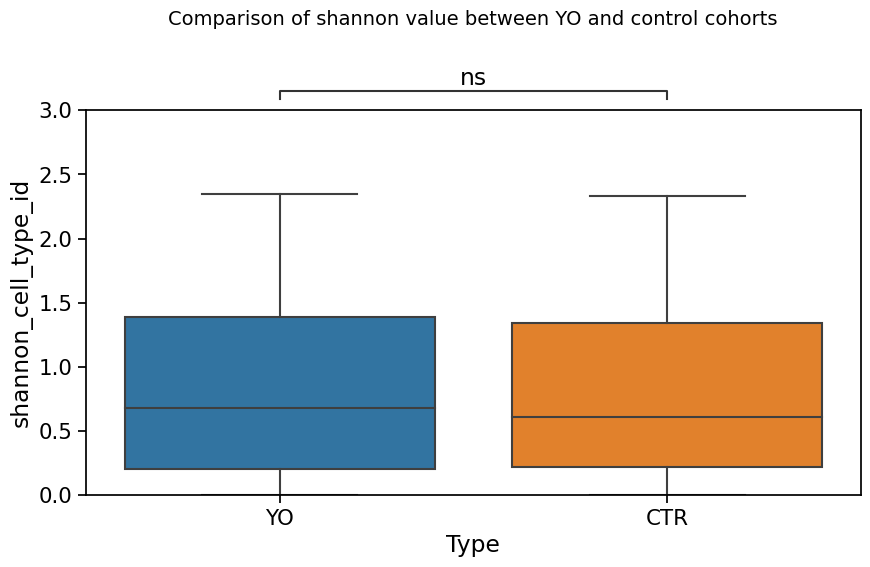

In [62]:
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'shannon_cell_type_id'}

plott_boxplot_pvalue(plotting_parameters, 3)
plt.title('Comparison of shannon value between YO and control cohorts', fontsize=14,y=1.2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:8.688e-01 U_stat=3.342e+05


Text(0.5, 1.2, 'Comparison of richness value between YO and control cohorts')

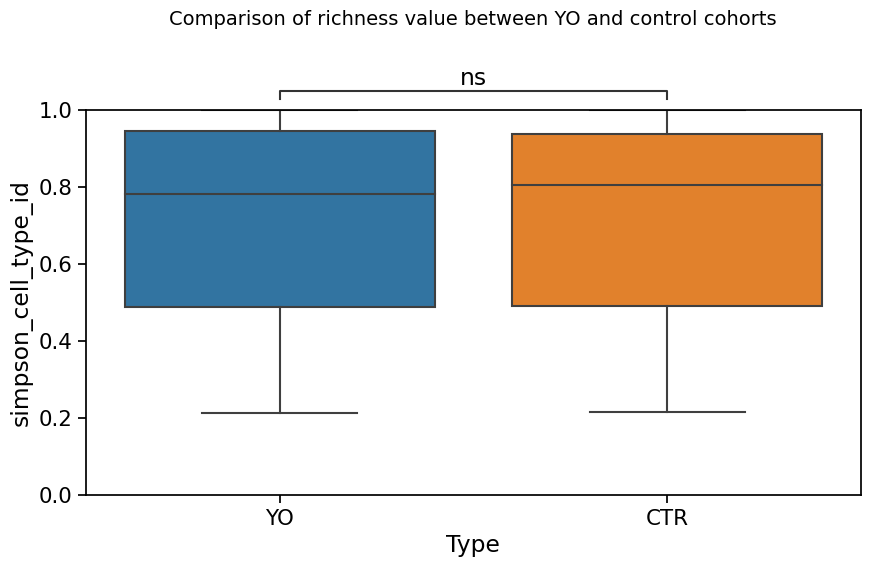

In [63]:
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'simpson_cell_type_id'}

plott_boxplot_pvalue(plotting_parameters, 1)
plt.title('Comparison of richness value between YO and control cohorts', fontsize=14,y=1.2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:8.688e-01 U_stat=3.342e+05


Text(0.5, 1.2, 'Comparison of simpson value between YO and control cohorts')

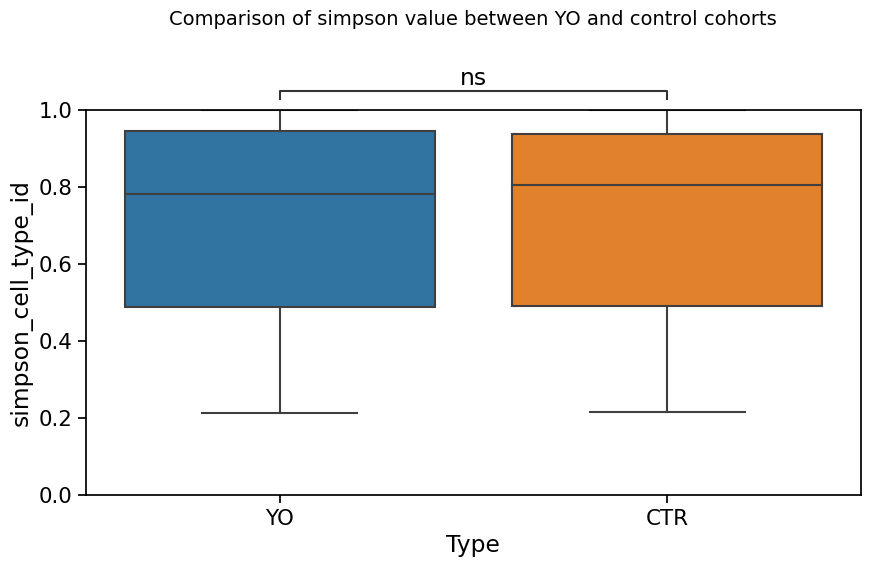

In [64]:
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'simpson_cell_type_id'}

plott_boxplot_pvalue(plotting_parameters, 1)
plt.title('Comparison of simpson value between YO and control cohorts', fontsize=14,y=1.2)


# Immune infiltration

In [5]:

samples = list(so.obs.keys())
for s in samples:
    if s not in []:#remove_list :
        print(s)
        if so.spl.loc[s]['tumoral_cell_count'] != 0 and so.spl.loc[s]['inflammatory_cell_count'] != 0:
            sh.neigh.infiltration(so, s, 'cell_type', interaction1=('neoplastic', 'inflammatory'), interaction2=('inflammatory', 'inflammatory'), graph_key='contact')
        else :
            if so.spl.loc[s]['tumoral_cell_count'] == 0 :
                print("no tumoral cells", s)
                so.spl.loc[s]['infiltration'] = 0
            if so.spl.loc[s]['inflammatory_cell_count'] == 0 :
                print("no inflammatory cells", s)
                so.spl.loc[s]['infiltration'] = 0

#so.spl.loc[all_samples].infiltration
so.spl.loc[samples].infiltration

In [6]:
so.spl['ID_dir']='a'
def dir_(x) :
    so.spl.at[x.name, 'ID_dir'] = x.name.split('/')[0]
so.spl.apply(dir_, axis=1)

In [62]:
all_samples = so.spl.index.values


In [7]:
# sort samples by increasing infiltration
all_samples = so.spl.dropna().index.values
ind1=np.argsort(so.spl.loc[all_samples].infiltration.values)
long = len(ind1)
print(long)
ind_to_plot = ind1[long-6:]
print(len(ind_to_plot))
nbre = int(len(ind_to_plot)/2 if len(ind_to_plot)%2 == 0 else (len(ind_to_plot)+1)/2)

# update colormap to show only immune and tumor cells 
#cmap = ['darkred',  'darkgreen', 'lightgrey', 'lightgrey', 'lightgrey']
#cmap_labels = {0: 'neoplastic',  1: 'inflammatory', 2: 'connective', 3: 'dead', 4: 'non-neoplastic epithelial'}

cmap = ['black', 'darkred',  'darkgreen', 'lightgrey', 'lightgrey', 'lightgrey']
cmap_labels = {0: 'background', 1: 'neoplastic',  2: 'inflammatory', 3: 'connective', 4: 'dead', 5: 'non-neoplastic epithelial'}


cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

fig, axs = plt.subplots(nbre, 2, figsize=(14, 7), dpi=300)
for i,s in enumerate(ind_to_plot): #ind1 #i indice, s spl
    print(i, s)
    sh.pl.spatial(so, all_samples[s], 'cell_type_id', mode='mask', ax=axs.flat[i], cbar = False)
    d = so.spl.loc[all_samples[s]]
    axs.flat[i].set_title(f'Patient {d.ID_dir}, infiltration: {d.infiltration:.2f}', fontdict={'size': 5})


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

YO vs. CTR: Mann-Whitney-Wilcoxon test two-sided, P_val:3.974e-01 U_stat=8.054e+04


Text(0.5, 1.2, 'Comparison of infiltration value between YO and control cohorts with indication of p value')

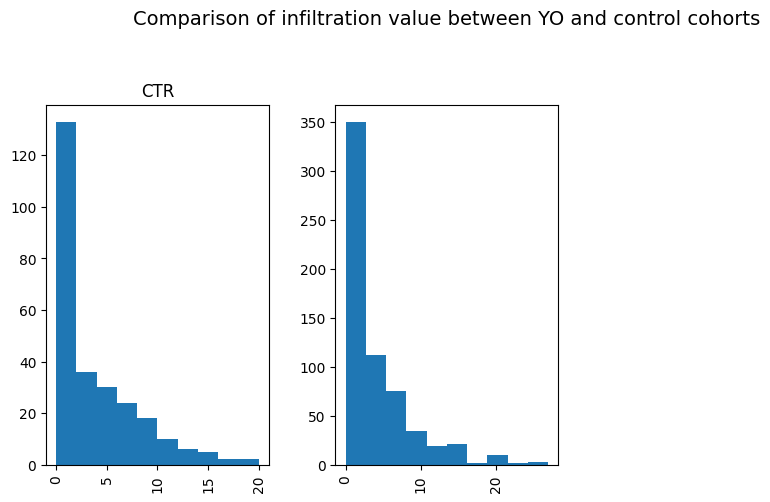

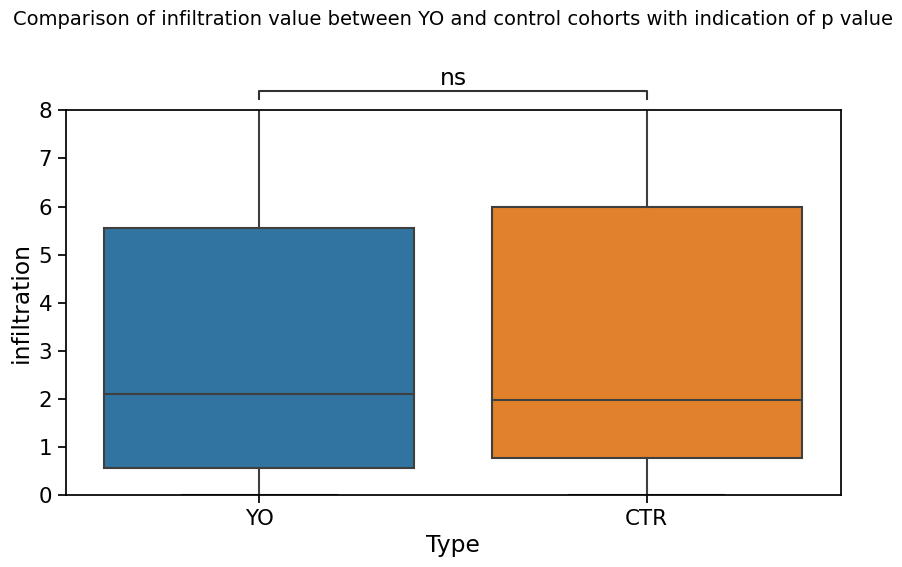

In [75]:
so.spl['infiltration'].hist(by=so.spl['Type'])
plt.title('Comparison of infiltration value between YO and control cohorts', fontsize=14,y=1.2)

plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'infiltration'}

plott_boxplot_pvalue(plotting_parameters, 8)
plt.title('Comparison of infiltration value between YO and control cohorts with indication of p value', fontsize=14,y=1.2)


# Infiltration on cell level

In [76]:
from spatialHeterogeneity.neighborhood.base_estimators import Interactions, _infiltration, RipleysK

from spatialHeterogeneity.neighborhood.utils import get_node_interactions
from spatialHeterogeneity.utils.general import is_categorical
from tqdm import tqdm

def infiltration(so, spl: str, attr: str, *, interaction1, interaction2,
                 add_key='infiltration', inplace=True, graph_key='knn', local=False) -> None:
    """Compute infiltration score.

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        interaction1: labels of enumerator interaction
        interaction2: labels of denominator interaction
        key_added: Key added to SpatialOmics.uns[spl][metric][key_added]
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.

    Returns:

    """
    so = so if inplace else so.copy()

    data = so.obs[spl][attr]
    if isinstance(data, pd.DataFrame):
        raise ValueError(f'multidimensional attr ({data.shape}) is not supported.')

    if not is_categorical(data):
        raise TypeError('`attr` needs to be categorical')

    if not np.in1d(np.array(interaction1 + interaction2), data.unique()).all():
        mask = np.in1d(np.array(interaction1 + interaction2), data.unique())
        missing = np.array(interaction1 + interaction2)[~mask]
        raise ValueError(f'specified interaction categories are not all in `attr`. Missing {missing}')

    G = so.G[spl][graph_key]
    if local:
        cont = []
        for node in tqdm(G.nodes):
            neigh = G[node]
            g = G.subgraph(neigh)
            nint = get_node_interactions(g, data)
            res = _infiltration(node_interactions=nint, interaction1=interaction1, interaction2=interaction2)
            cont.append(res)

        res = pd.DataFrame(cont, index=G.nodes, columns=[add_key])
        if add_key in so.obs[spl]:
            so.obs[spl] = so.obs[spl].drop(columns=[add_key])

        so.obs[spl] = pd.concat((so.obs[spl], res), 1)

    else:
        nint = get_node_interactions(G, data)

        res = _infiltration(node_interactions=nint, interaction1=interaction1, interaction2=interaction2)

        so.spl.loc[spl, add_key] = res

    if not inplace:
        return so

In [78]:
so.spl.reset_index(inplace=True)

In [79]:
so.spl.set_index('ID_patient',inplace=True)

In [8]:
from spatialHeterogeneity.neighborhood.base_estimators import Interactions, _infiltration, RipleysK

from spatialHeterogeneity.neighborhood.utils import get_node_interactions
from spatialHeterogeneity.utils.general import is_categorical
from tqdm import tqdm

attr = 'cell_type'
for spl in so.obs.keys() :
    if so.spl.loc[spl]['tumoral_cell_count'] != 0 and so.spl.loc[spl]['inflammatory_cell_count'] != 0:
        infiltration(so, spl, attr, interaction1=('neoplastic', 'inflammatory'), interaction2=('inflammatory', 'inflammatory'), graph_key='radius', local=True)
    else :
        print(spl, 'doesn\'t have tumoral cells or inflammatory_cell_count')

In [9]:
so.obs[spl]['cell_type_id']

dat = so.obs[spl][[attr] + ['x', 'y']]
dat = dat[~dat.infiltration.isna()]

# we add step_size to prevent out of bounds indexing should the `{x,y}_img` values be rounded up.
x, y = np.arange(0, so.images[spl].shape[2], step_size), np.arange(0, so.images[spl].shape[1], step_size)
img = np.zeros((len(y), len(x)))

dat['x_img'] = np.round(dat.x / step_size).astype(int)
dat['y_img'] = np.round(dat.y / step_size).astype(int)

In [92]:
import logging
def infiltration_sc(so, spl: str, attr: str ='infiltration', step_size: int = 10,
                 interpolation: str = 'gaussian',
                 cmap: str ='plasma',
                 collision_strategy='mean',
                 ax=None,
                 show=True):
    """Visualises a heatmap of the featuer intensity.

    Approximates the sample with a grid representation and colors each grid square according to the
    value of the attribute. If multiple observations map to the same grid square a the aggregation specified
    in `collision_strategy` is employed (any value accepted by pandas aggregate function, i.e. 'mean', 'max', ...)

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: feature in SpatialOmics.obs to plot
        step_size: grid step size
        interpolation: interpolation method to use between grid values, see [1]
        cmap: colormap to use
        collision_strategy: aggragation strategy to use if multiple obseravtion values map to the same grid value
        ax: axes to use for the plot
        show: whether to show the plot or not. Will be set to False if axes is provided.

    Returns:
        None
    Notes:
        .. [1] https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
    """

    dat = so.obs[spl][[attr] + ['x', 'y']]
    dat = dat[~dat.infiltration.isna()]

    # we add step_size to prevent out of bounds indexing should the `{x,y}_img` values be rounded up.
    x, y = np.arange(0, so.images[spl].shape[2], step_size), np.arange(0, so.images[spl].shape[1], step_size)
    img = np.zeros((len(y), len(x)))

    #dat['x_img'] = np.round(dat.x / step_size).astype(int)
    #dat['y_img'] = np.round(dat.y / step_size).astype(int)
    
    dat['x_img'] = (dat.x / step_size).astype(int)
    dat['y_img'] = (dat.y / step_size).astype(int)

    if dat[['x_img', 'y_img']].duplicated().any():
        logging.warning(
            f'`step_size` is to granular, {dat[["x_img", "y_img"]].duplicated().sum()} observed infiltration values mapped to same grid square')

    if collision_strategy is not None:
        logging.warning(f'computing {collision_strategy} for collisions')
        dat = dat.groupby(['x_img', 'y_img']).infiltration.agg(collision_strategy).reset_index()

    for i in range(dat.shape[0]):
        img[dat.y_img.iloc[i], dat.x_img.iloc[i]] = dat.infiltration.iloc[i]

    # generate figure
    if ax:
        fig = ax.get_figure()
        show = False  # do not automatically show plot if we provide axes
    else:
        fig, ax = plt.subplots()

    ax.imshow(img, interpolation=interpolation, cmap=cmap)
    ax.invert_yaxis()

    if show:
        fig.show()




In [10]:
for spl in list(so.obs.keys())[1000:1001] :
    fig, axs = plt.subplots(1,3, figsize=(16,8))
    sh.pl.spatial(so, spl, 'cell_type_id', ax=axs[0])
    infiltration_sc(so, spl, step_size= 10, ax=axs[1])
    infiltration_sc(so, spl, step_size= 5, ax=axs[2])

# Cell type interaction

In [11]:
import logging
logging.getLogger().setLevel(logging.ERROR)  # set logger to logging.INFO if you want to see more progress information

# this will take some time...
for s in tqdm(all_samples):
    if s in so.G.keys() and 'contact' in so.G[s].keys() :
        dir_ = s.split('/')[0]
        if not os.path.exists('/home/user/.cache/spatialHeterogeneity/h0-models/'+dir_) :
            os.mkdir('/home/user/.cache/spatialHeterogeneity/h0-models/'+dir_)
        sh.neigh.interactions(so, s, 'cell_type_id', mode='proportion', prediction_type='diff', graph_key='contact');

In [82]:
import time

def add2uns(so, res, spl: str, parent_key, key_added):
    if spl in so.uns:
        if parent_key in so.uns[spl]:
            so.uns[spl][parent_key][key_added] = res 
        else:
            so.uns[spl].update({parent_key: {key_added: res}})
    else:
        so.uns.update({spl: {parent_key: {key_added: res}}})
        
def interactions(so, spl: str, attr: str, mode: str ='classic', prediction_type: str ='observation', *, n_permutations: int =100,
                 random_seed=None, alpha: float =.01, try_load: bool =True, key_added: str =None, graph_key: str ='knn',
                 inplace: bool =True) -> None:
    """Compute interaction strength between species.
    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        mode: One of {classic, histoCAT, proportion}, see notes
        n_permutations: Number of permutations to compute p-values and the interactions strength score (mode diff)
        random_seed: Random seed for permutations
        alpha: Threshold for significance
        prediction_type: One of {observation, pvalue, diff}, see Notes
        try_load: load pre-computed permutation results if available
        key_added: Key added to SpatialOmics.uns[spl][metric][key_added]
        graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        inplace: Whether to add the metric to the current SpatialOmics instance or to return a new one.
    Returns:
    """
    so = so if inplace else so.copy()

    # NOTE: uns_path = f'{spl}/interactions/'
    if key_added is None:
        key_added = f'{attr}_{mode}_{prediction_type}_{graph_key}'

    if random_seed is None:
        random_seed = so.random_seed

    estimator = Interactions(so=so, spl=spl, attr=attr, mode=mode, n_permutations=n_permutations,
                             random_seed=random_seed, alpha=alpha, graph_key=graph_key)

    estimator.fit(prediction_type=prediction_type, try_load=try_load)
    res = estimator.predict()

    # add result to uns attribute
    add2uns(so, res, spl, 'interactions', key_added)

    if not inplace:
        return so
    
    
class Interactions:
    """
    Estimator to quantify interaction strength between different species in the sample.
    """

    VALID_MODES = ['classic', 'histoCAT', 'proportion']
    VALID_PREDICTION_TYPES = ['pvalue', 'observation', 'diff']

    def __init__(self, so, spl: str, attr: str = 'cell_id', mode: str = 'classic', n_permutations: int = 500,
                 random_seed=None, alpha: float = .01, graph_key: str = 'knn'):
        """Estimator to quantify interaction strength between different species in the sample.
        Args:
            so: SpatialOmics
            spl: Sample for which to compute the interaction strength
            attr: Categorical feature in SpatialOmics.obs to use for the grouping
            mode: One of {classic, histoCAT, proportion}, see notes
            n_permutations: Number of permutations to compute p-values and the interactions strength score (mode diff)
            random_seed: Random seed for permutations
            alpha: Threshold for significance
            graph_key: Specifies the graph representation to use in so.G[spl] if `local=True`.
        Notes:
            classic and histoCAT are python implementations of the corresponding methods pubished by the Bodenmiller lab at UZH.
            The proportion method is similar to the classic method but normalises the score by the number of edges and is thus bound [0,1].
        """

        self.so = so
        self.spl: str = spl
        self.graph_key = graph_key
        self.g: Graph = so.G[spl][graph_key]
        self.attr: str = attr
        self.data: pd.Series = so.obs[spl][attr]
        self.mode: str = mode
        self.n_perm: int = int(n_permutations)
        self.random_seed = random_seed if random_seed else so.random_seed
        self.rng = np.random.default_rng(random_seed)
        self.alpha: float = alpha
        self.fitted: bool = False

        # set dtype categories of data to attributes that are in the data
        self.data = self.data.astype(CategoricalDtype(categories=self.data.unique(), ordered=False))

        # path where h0 models would be
        patient = spl.split('/')[0]
        file = spl.split('/')[1]
        self.path = os.path.expanduser(f'/home/user/Code/data_Lyon/Ovarian_analysis/h0-models/'+patient)

        if not os.path.exists('/home/user/Code/data_Lyon/Ovarian_analysis/h0-models/'+patient) :
            if not os.path.exists('/home/user/Code/data_Lyon/Ovarian_analysis/h0-models/') :
                os.mkdir('/home/user/Code/data_Lyon/Ovarian_analysis/h0-models/')
            os.mkdir('/home/user/Code/data_Lyon/Ovarian_analysis/h0-models/'+patient)
        self.h0_file = f'{file}_{attr}_{graph_key}_{mode}.pkl'
        print()
        self.h0 = None

    def fit(self, prediction_type: str = 'observation', try_load: bool = True) -> None:
        """Compute the interactions scores for the sample.
        Args:
            prediction_type: One of {observation, pvalue, diff}, see Notes
            try_load: load pre-computed permutation results if available
        Returns:
        Notes:
            `observation`: computes the observed interaction strength in the sample
            `pvalue`: computes the P-value of a two-sided t-test for the interactions strength based on the random permutations
            `diff`: computes the difference between observed and average interaction strength (across permutations)
        """
        if prediction_type not in self.VALID_PREDICTION_TYPES:
            raise ValueError(
                f'invalid `prediction_type` {prediction_type}. Available modes are {self.VALID_PREDICTION_TYPES}')

        self.prediction_type = prediction_type

        # extract observed interactions
        if self.mode == 'classic':
            relative_freq, observed = False, False
        elif self.mode == 'histoCAT':
            relative_freq, observed = False, True
        elif self.mode == 'proportion':
            relative_freq, observed = True, False
        else:
            raise ValueError(f'invalid mode {self.mode}. Available modes are {self.VALID_MODES}')

        node_interactions = get_node_interactions(self.g, self.data)
        obs_interaction = get_interaction_score(node_interactions, relative_freq=relative_freq, observed=observed)

        self.obs_interaction = obs_interaction.set_index(['source_label', 'target_label'])

        if not prediction_type == 'observation':
            self.generate_h0(relative_freq=relative_freq, observed=observed, save=True)
        """ if try_load:
                if os.path.isdir(self.path) and self.h0_file in os.listdir(self.path):
                    logging.info(
                        f'loading h0 for {self.spl}, graph type {self.graph_key} and mode {self.mode}')
                    self.h0 = pd.read_pickle(os.path.join(self.path, self.h0_file))
                    #print('path', os.path.join(self.path, self.h0_file))
                    #print("grr", self.h0)
            # if try_load was not successful
            if self.h0 is None:
                logging.info(
                    f'generate h0 for {self.spl}, graph type {self.graph_key} and mode {self.mode} and attribute {self.attr}')
                self.generate_h0(relative_freq=relative_freq, observed=observed, save=True)"""

        self.fitted = True

    def predict(self) -> pd.DataFrame:
        """Predict interactions strengths of observations.
        Returns: A dataframe with the interaction results.
        """
        if self.prediction_type == 'observation':
            return self.obs_interaction
        elif self.prediction_type == 'pvalue':
            # TODO: Check p-value computation
            data_perm = pd.concat((self.obs_interaction, self.h0), axis=1)
            data_perm.fillna(0, inplace=True)
            data_pval = pd.DataFrame(index=data_perm.index)

            # see h0_models_analysis.py for alterantive p-value computation
            data_pval['score'] = self.obs_interaction.score
            data_pval['perm_mean'] = data_perm.apply(lambda x: np.mean(x[1:]), axis=1, raw=True)
            data_pval['perm_std'] = data_perm.apply(lambda x: np.std(x[1:]), axis=1, raw=True)
            data_pval['perm_median'] = data_perm.apply(lambda x: np.median(x[1:]), axis=1, raw=True)

            data_pval['p_gt'] = data_perm.apply(lambda x: np.sum(x[1:] >= x[0]) / self.n_perm, axis=1, raw=True)
            data_pval['p_lt'] = data_perm.apply(lambda x: np.sum(x[1:] <= x[0]) / self.n_perm, axis=1, raw=True)
            data_pval['perm_n'] = data_perm.apply(lambda x: self.n_perm, axis=1, raw=True)

            data_pval['p'] = data_pval.apply(lambda x: x.p_gt if x.p_gt <= x.p_lt else x.p_lt, axis=1)
            data_pval['sig'] = data_pval.apply(lambda x: x.p < self.alpha, axis=1)
            data_pval['attraction'] = data_pval.apply(lambda x: x.p_gt <= x.p_lt, axis=1)
            data_pval['sigval'] = data_pval.apply(lambda x: np.sign((x.attraction - .5) * x.sig), axis=1)
            return data_pval
        elif self.prediction_type == 'diff':

            data_perm = pd.concat((self.obs_interaction, self.h0), axis=1)

            data_perm.fillna(0, inplace=True)
            data_pval = pd.DataFrame(index=data_perm.index)
    
            # see h0_models_analysis.py for alterantive p-value computation
            data_pval['score'] = self.obs_interaction.score
            data_pval['perm_mean'] = data_perm.apply(lambda x: np.mean(x[1:]), axis=1, raw=True)
            data_pval['perm_std'] = data_perm.apply(lambda x: np.std(x[1:]), axis=1, raw=True)
            data_pval['perm_median'] = data_perm.apply(lambda x: np.median(x[1:]), axis=1, raw=True)


            data_pval['diff'] = (data_pval['score'] - data_pval['perm_mean'])

            return data_pval

        else:
            raise ValueError(
                f'invalid `prediction_type` {self.prediction_type}. Available modes are {self.VALID_PREDICTION_TYPES}')

    def generate_h0(self, relative_freq, observed, save=True):
            connectivity = get_node_interactions(self.g).reset_index(drop=True)

            res_perm, durations = [], []
            for i in range(self.n_perm):
                tic = time.time()

                data = permute_labels(self.data, self.rng)
                source_label = data.loc[connectivity.source].values.ravel()
                target_label = data.loc[connectivity.target].values.ravel()


                # create pd.Series and node_interaction pd.DataFrame
                source_label = pd.Series(source_label, name='source_label', dtype=self.data.dtype)
                target_label = pd.Series(target_label, name='target_label', dtype=self.data.dtype)
                df = pd.concat((connectivity, source_label, target_label), axis=1)

                # get interaction count
                perm = get_interaction_score(df, relative_freq=relative_freq, observed=observed)
                perm['permutation_id'] = i

                # save result
                res_perm.append(perm)

                # stats
                toc = time.time()
                durations.append(toc - tic)

                #if (i + 1) % 10 == 0:
                #    print(f'{time.asctime()}: {i + 1}/{self.n_perm}, duration: {np.mean(durations):.2f}) sec')
            #print(
             #   f'{time.asctime()}: Finished, duration: {np.sum(durations) / 60:.2f} min ({np.mean(durations):.2f}sec/it)')

            h0 = pd.concat(res_perm)
            self.h0 = pd.pivot(h0, index=['source_label', 'target_label'], columns='permutation_id', values='score')
            
            # create folders
            if not os.path.isdir(self.path):
                os.makedirs(self.path)
            self.h0.to_pickle(os.path.join(self.path, self.h0_file))

            
from pandas.api.types import CategoricalDtype
def get_interaction_score(interactions, relative_freq=False, observed=False):
    # NOTE: this is not necessarily len(source_labels) == len(g) since only source nodes with neighbors are included
    source_label = interactions[['source', 'source_label']].drop_duplicates().set_index('source')
    source_label = source_label.squeeze()

    source2target_label = interactions.groupby(['source', 'target_label'], observed=observed,
                                               as_index=False).size().rename({'size': 'counts'}, axis=1)
    source2target_label.loc[:, 'source_label'] = source_label[source2target_label.source].values

    if relative_freq:
        tots = source2target_label.groupby('source')['counts'].agg('sum')
        source2target_label['n_neigh'] = tots.loc[source2target_label.source].values
        source2target_label['relative_freq'] = source2target_label['counts'] / source2target_label['n_neigh']
        label2label = source2target_label\
            .groupby(['source_label', 'target_label'], observed=observed)['relative_freq'] \
            .agg('mean') \
            .rename('score') \
            .fillna(0) \
            .reset_index()
    else:
        label2label = source2target_label \
            .groupby(['source_label', 'target_label'], observed=observed)['counts'] \
            .agg('mean') \
            .rename('score') \
            .fillna(0) \
            .reset_index()

    return label2label

In [83]:
def get_edge_interactions(g: nx.Graph, data: pd.Series):
    # IMPORTANT: Be aware of the symmetry issues when only looking at edges. This is, two cells A,B that share an edge
    # are only represented once, either as A B or B A

    # probably the fasted way to solve this is would be by multidimensional indexing into a numpy array.
    # data[edges.T]
    # however the api is based on cell_ids that are not sequential, thus we have to index into pd.Series which is fast
    # or we convert the non-sequential cell_ids into sequential ones

    # NOTE: The data pd.Series is categorical with globally all categories

    edges = np.array(g.edges)
    edge_interactions = pd.DataFrame({'source': edges[:, 0], 'source_label': data.loc[edges[:, 0]].values,
                                      'target': edges[:, 1], 'target_label': data.loc[edges[:, 1]].values})
    return edge_interactions


def get_node_interactions(g: nx.Graph, data: pd.Series = None):
    # NOTE: The data pd.Series is categorical with globally all categories

    source, neighs = [], []
    for i in g.nodes:
        if len(g[i]) > 0:  # some nodes might have no neighbors
            source.append(i)
            neighs.append(list(g[i]))

    node_interactions = pd.DataFrame({'source': source, 'target': neighs}).explode('target')
    if data is not None:
        node_interactions['source_label'] = data.loc[node_interactions.source].values
        node_interactions['target_label'] = data.loc[node_interactions.target].values

    return node_interactions


def get_interaction_score(interactions, relative_freq=False, observed=False):
    # NOTE: this is not necessarily len(source_labels) == len(g) since only source nodes with neighbors are included
    source_label = interactions[['source', 'source_label']].drop_duplicates().set_index('source')
    source_label = source_label.squeeze()

    source2target_label = interactions.groupby(['source', 'target_label'], observed=observed,
                                               as_index=False).size().rename({'size': 'counts'}, axis=1)
    source2target_label.loc[:, 'source_label'] = source_label[source2target_label.source].values

    if relative_freq:
        tots = source2target_label.groupby('source')['counts'].agg('sum')
        source2target_label['n_neigh'] = tots.loc[source2target_label.source].values
        source2target_label['relative_freq'] = source2target_label['counts'] / source2target_label['n_neigh']
        label2label = source2target_label\
            .groupby(['source_label', 'target_label'], observed=observed)['relative_freq'] \
            .agg('mean') \
            .rename('score') \
            .fillna(0) \
            .reset_index()
    else:
        label2label = source2target_label \
            .groupby(['source_label', 'target_label'], observed=observed)['counts'] \
            .agg('mean') \
            .rename('score') \
            .fillna(0) \
            .reset_index()

    return label2label


# why is this so slow???
def permute_labels_deprecate(data, rng: np.random.Generator):
    attr_copy = data.copy()
    attr_copy[:] = rng.permutation(attr_copy)
    return attr_copy


def permute_labels(data, rng: np.random.Generator):
    return pd.Series(rng.permutation(data), index=data.index)

In [12]:

# this will take some time...
for s in tqdm(all_samples):
    if s in so.G.keys() and 'contact' in so.G[s].keys() :
        interactions(so, s, 'cell_type_id', mode='proportion', prediction_type='diff', graph_key='radius')

In [85]:
def plot_interactions(so, spl, attr, mode='proportion', prediction_type='diff', graph_key='knn', linewidths=.5, cmap=None,
                 norm=None, ax=None, show=True, cbar=True):
    """Visualise results from :func:`~neigh.interactions` results.

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        mode: One of {classic, histoCAT, proportion}, see notes
        prediction_type: prediction_type: One of {observation, pvalue, diff}
        graph_key: Specifies the graph representation to use in so.G[spl]
        linewidths: Space between tiles
        cmap: colormap to use
        norm: normalisation to use
        ax: axes object to use
        show: whether to show the plot
        cbar: wheter to show the colorbar

    Examples:

        .. code-block:: python

            # compute Ripley's K
            so = sh.dataset.imc()
            spl = so.spl.index[0]

            # build graph
            sh.graph.build_graph(so, spl, builder_type='knn', mask_key='cellmasks')

            # compute & plot interactions
            sh.neigh.interactions(so, spl, 'meta_id', mode='proportion', prediction_type='observation')
            sh.pl.interactions(so, spl, 'meta_id', mode='proportion', prediction_type='observation')

    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        show = False

    if cmap is None:
        cmap = 'coolwarm'
    


    data = so.uns[spl]['interactions'][f'{attr}_{mode}_{prediction_type}_{graph_key}']
    score = 'diff' if prediction_type == 'diff' else 'score'
    data = data.reset_index().pivot('source_label', 'target_label', score)
    data.index = data.index.astype(int)
    data.columns = data.columns.astype(int)
    data.sort_index(0, inplace=True)
    data.sort_index(1, inplace=True)

    if norm is None:
        v = np.abs(data).max().max()
        norm = Normalize(-v, v)

    sns.heatmap(data=data, cmap=cmap, norm=norm, ax=ax, linewidths=linewidths, cbar=cbar)
    ax.set_aspect(1)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if show:
        fig.show()

In [13]:
# cell_type_id colormap
cmap = ['black', 'red', 'green', 'blue', 'yellow', 'orange']
cmap_labels = {0: 'background', 1: 'neoplastic',  2: 'inflammatory', 3: 'connective', 4: 'dead', 5: 'non-neoplastic epithelial'}
cmap = ListedColormap(cmap)

so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
sh.pl.spatial(so, spl, 'cell_type_id', mode='mask', ax=axs[0])
norm = Normalize(-.3, .3)
sh.pl.interactions(so, spl, 'cell_type_id', mode='proportion', prediction_type='diff', graph_key='radius', ax=axs[1])
fig.tight_layout()
# fig.show()

In [87]:
def sns_interactions(df, ctrl, mode='proportion', prediction_type='diff_mean', graph_key='knn', title = "mean", linewidths=.5, cmap=None,
                 norm=None, ax=None, show=True):
    """Visualise interaction results.

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        mode: One of {classic, histoCAT, proportion}, see notes
        prediction_type: prediction_type: One of {observation, pvalue, diff}
        graph_key: Specifies the graph representation to use in so.G[spl]
        linewidths: Space between tiles
        cmap: coso.uns = {'cmaps': {}, 'cmap_labels': {}}
lormap to use
        norm: normalisation to use
        ax: axes object to use
        show: whether to show the plot

    Returns:

    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        show = False

    if cmap is None:
        cmap = 'coolwarm'

    #data = so.uns[spl]['interactions'][f'{attr}_{mode}_{prediction_type}_{graph_key}']
    data = df
    #print(data.head())
    score = prediction_type #'diff_mean' if prediction_type == 'diff_mean' else 'score'
    data = data.reset_index().pivot('source_label', 'target_label', score)
    data.index = data.index.astype(int)
    data.columns = data.columns.astype(int)
    data.sort_index(0, inplace=True)
    data.sort_index(1, inplace=True)

    if norm is None:
        v = np.abs(data).max().max()
        norm = Normalize(-v, v)
    labels = ['neoplastic', 'inlammatory', 'connective', 'dead', 'non-neoplastic epithelial']
    sns.heatmap(data=data, cmap=cmap, norm=norm, ax=ax, linewidths=linewidths,xticklabels = labels, yticklabels = labels)
    ax.set_aspect(1)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if ctrl == True :
        ax.set_title('Ctrl ' + title)
    else :
        ax.set_title('YO ' + title)

    if show:
        fig.show()

## Tracé moyenne/médiane des interactions pour Ctrl/YO

/tmp/ipykernel_8010/2263107995.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ctrl['diff_mean'] = df_ctrl.mean(numeric_only=True, axis=1)
/tmp/ipykernel_8010/2263107995.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_YO['diff_mean'] = df_YO.mean(numeric_only=True, axis=1)
/tmp/ipykernel_8010/2263107995.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

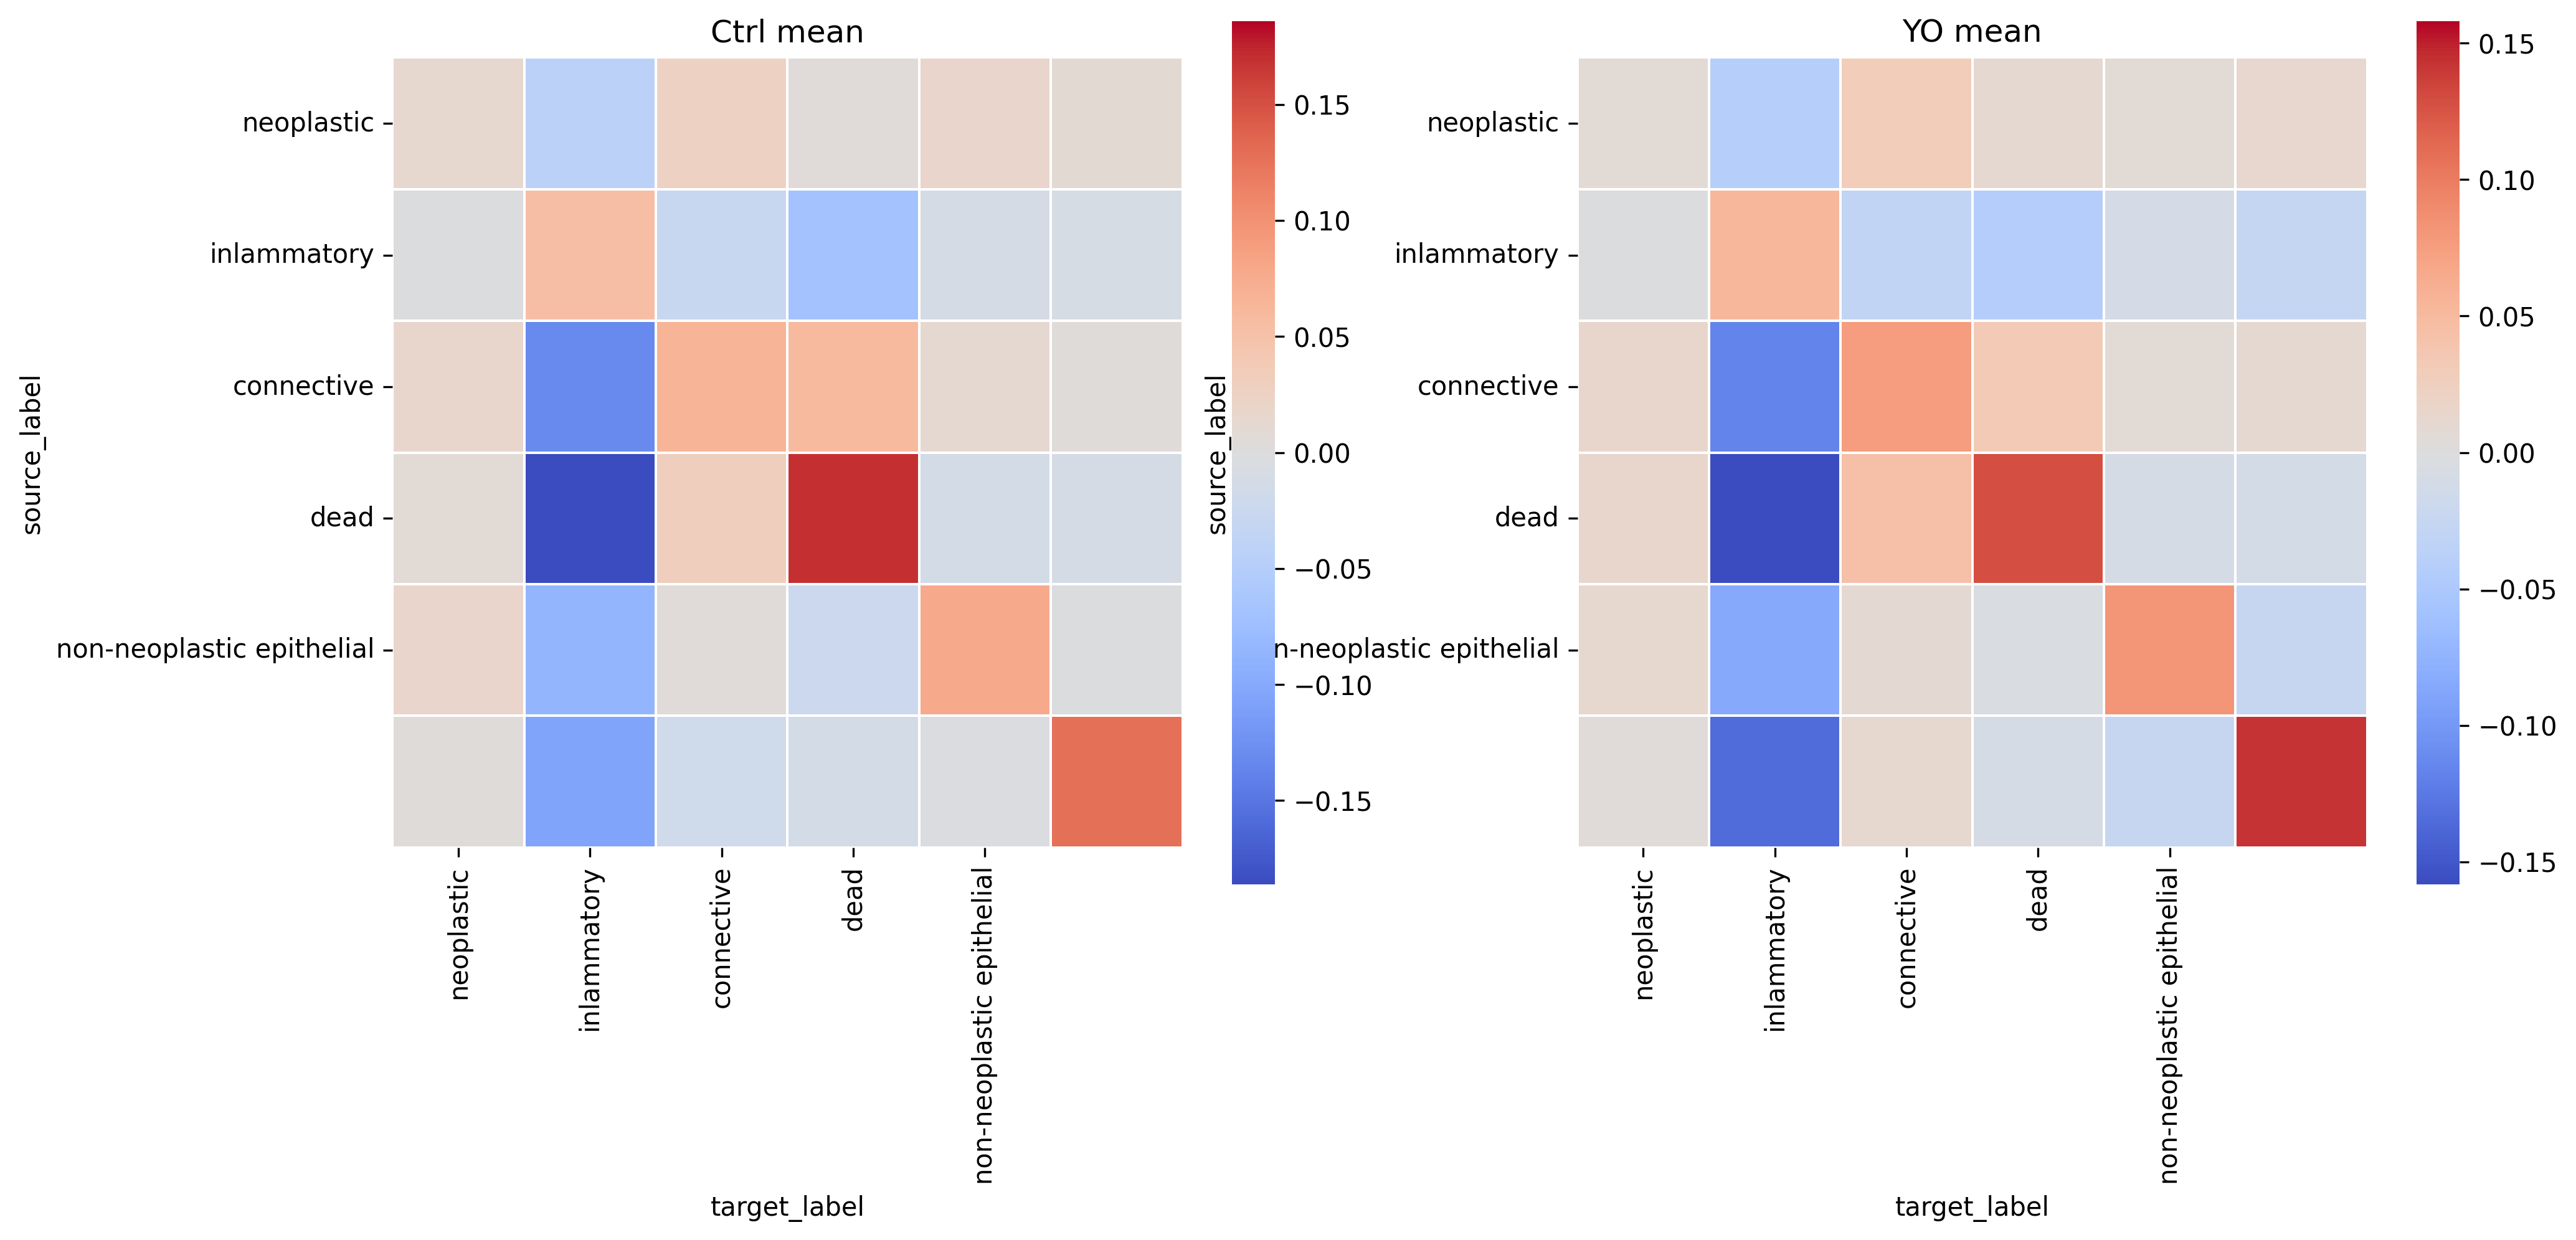

In [88]:
#calcul des moyennes de diff par YO et ctrl, stockés dans 2 dataframes !=, puis plot des heatmap
liste_YO = []
liste_ctrl = []
for _id in so.spl.index :
    if so.spl.loc[_id, 'Type'] == 'YO' :
        liste_YO.append(_id)
    else :
        liste_ctrl.append(_id)
df_ctrl = pd.DataFrame()
df_YO = pd.DataFrame()
for _id in so.uns.keys() :
    if _id in liste_YO :
        df_YO_temp  = so.uns[_id]['interactions']['cell_type_id_proportion_diff_radius'].filter(['diff'])
        df_YO_temp.rename(columns={'diff' : 'diff_'+_id}, inplace=True)
        df_YO = pd.concat([df_YO, df_YO_temp], axis=1, join='outer')
    if _id in liste_ctrl :
        df_ctrl_temp  = so.uns[_id]['interactions']['cell_type_id_proportion_diff_radius'].filter(['diff'])
        df_ctrl_temp.rename(columns={'diff' : 'diff_'+_id}, inplace=True)
        df_ctrl = pd.concat([df_ctrl, df_ctrl_temp], axis=1, join='outer')
df_ctrl['diff_mean'] = df_ctrl.mean(numeric_only=True, axis=1)
df_YO['diff_mean'] = df_YO.mean(numeric_only=True, axis=1)


df_ctrl['diff_median'] = df_ctrl.median(numeric_only=True, axis=1)
df_YO['diff_median'] = df_YO.median(numeric_only=True, axis=1)


#Tracé des moyennes
fig, axs = plt.subplots(1,2, figsize=(15, 6), dpi=300)
sns_interactions(df_ctrl, ctrl = True, mode='proportion', prediction_type='diff_mean', graph_key='radius', title ="mean", ax=axs[0])

sns_interactions(df_YO, ctrl= False, mode='proportion', prediction_type='diff_mean', graph_key='radius', title ="mean", ax=axs[1])
fig.show()
#fig.tight_layout()



/tmp/ipykernel_8010/176574147.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  data.sort_index(0, inplace=True)
/tmp/ipykernel_8010/176574147.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  data.sort_index(1, inplace=True)
/tmp/ipykernel_8010/176574147.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  data.sort_index(0, inplace=True)
/tmp/ipykernel_8010/176574147.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  data.sort_index(1, inplace=True)
/tmp/ipykernel_8010/1920000822.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


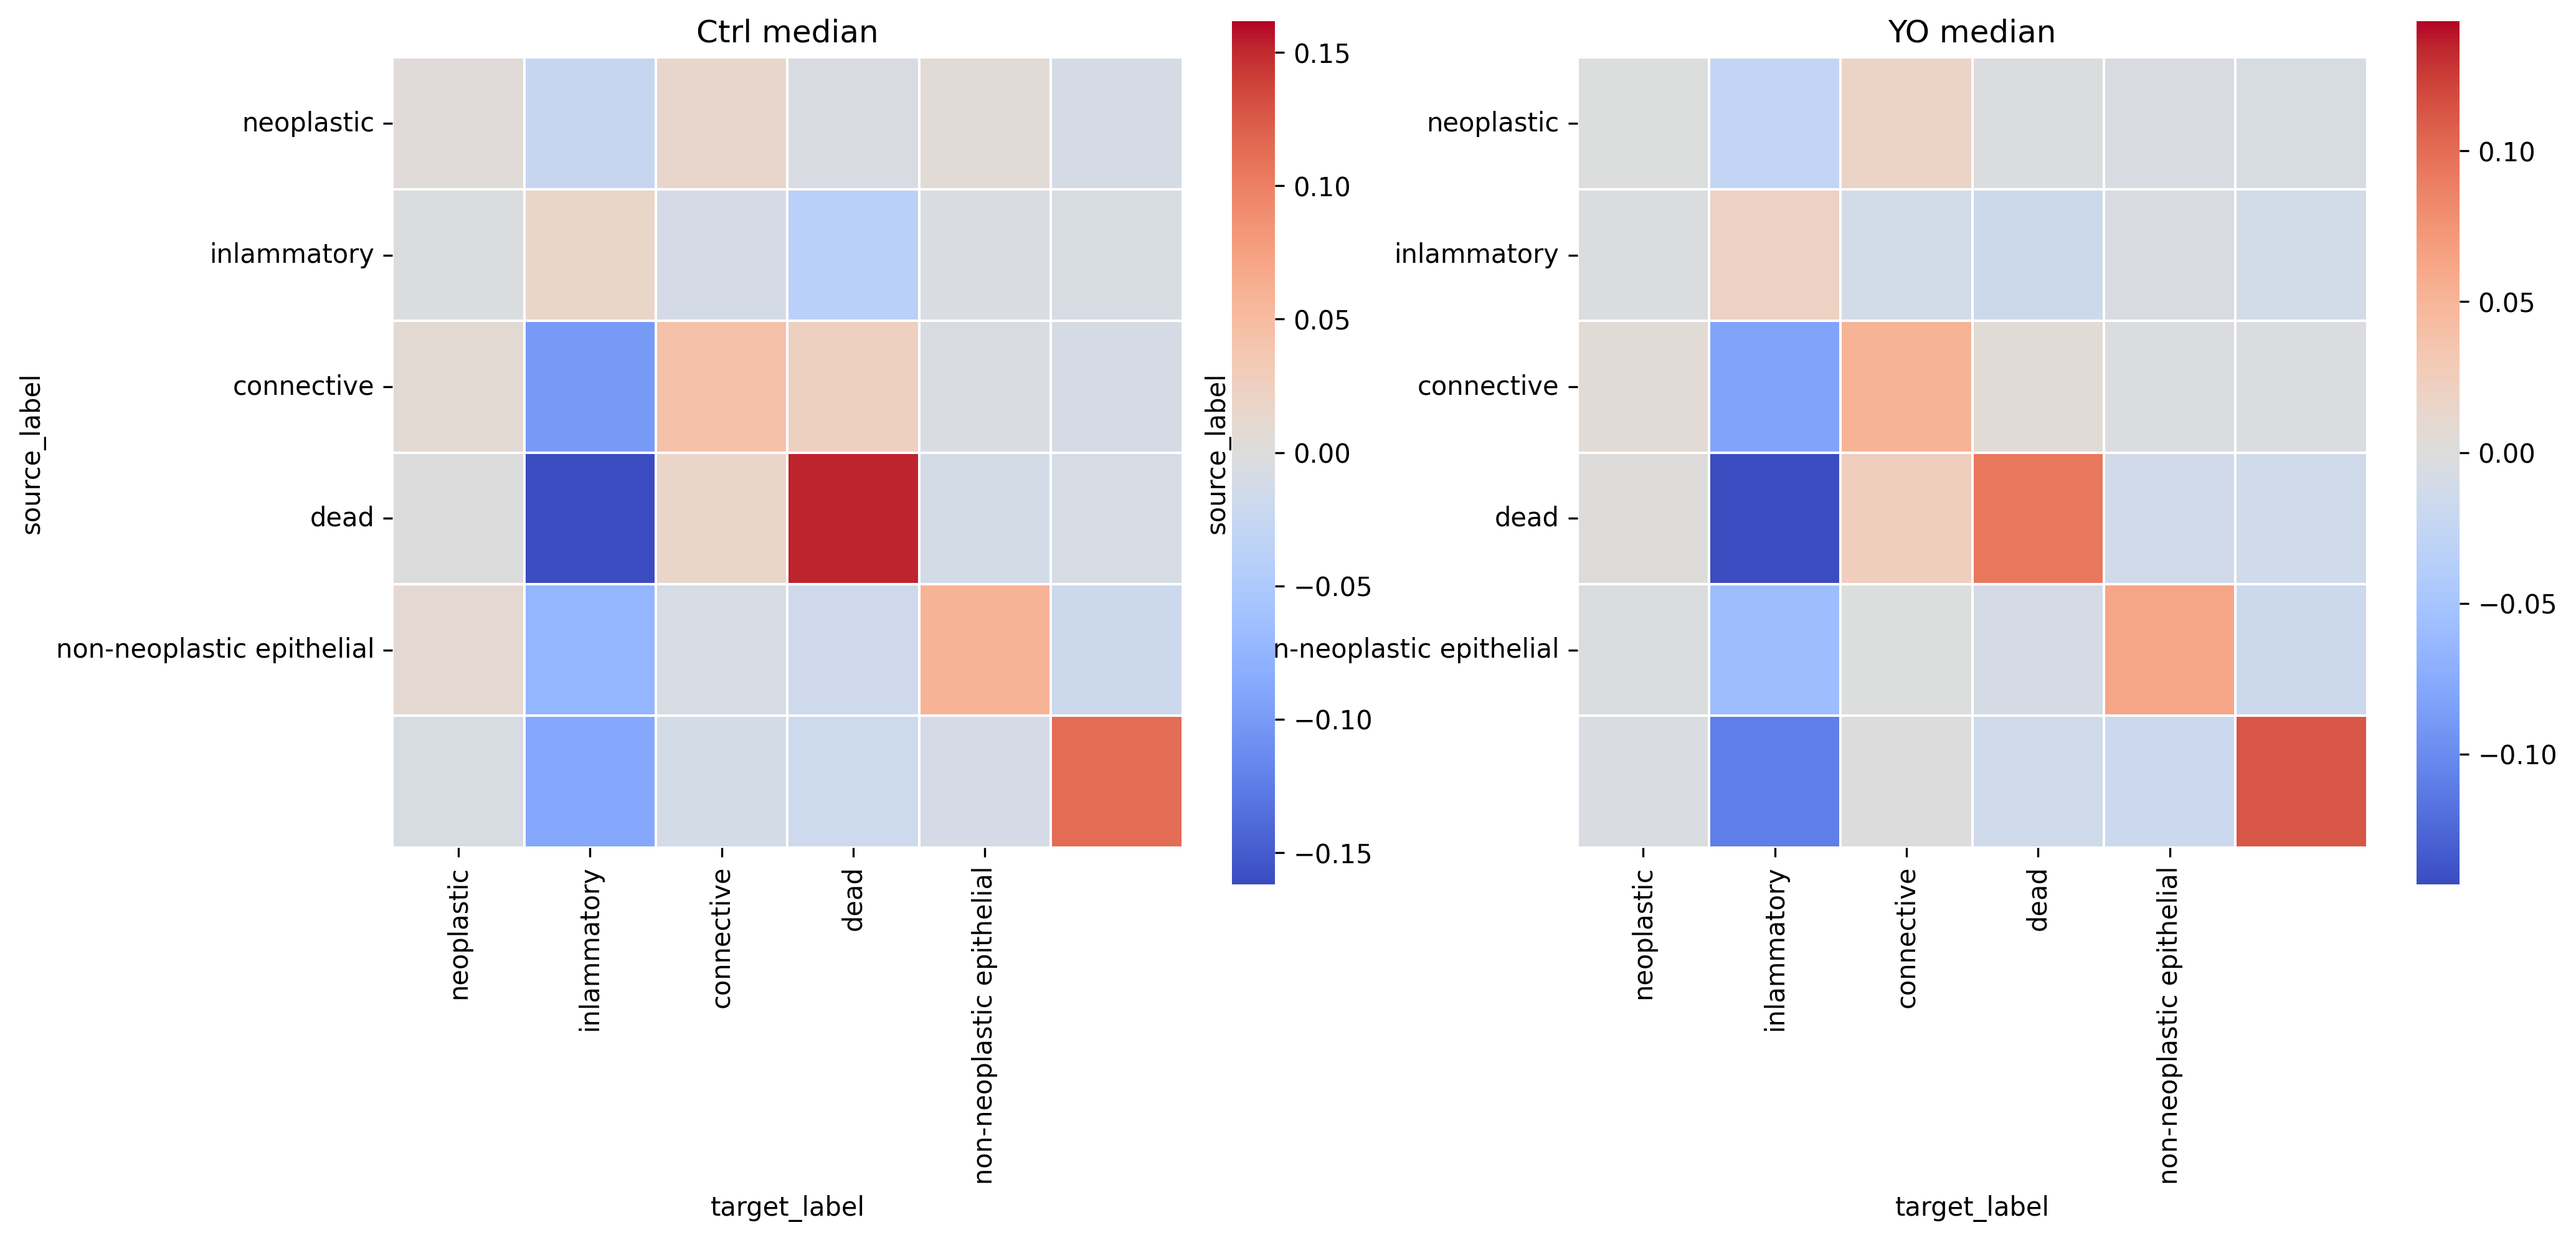

In [90]:

#Tracés des médians

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)

sns_interactions(df_ctrl, ctrl = True, mode='proportion', prediction_type='diff_median', graph_key='radius', title ="median",  ax=axs[0])

sns_interactions(df_YO, ctrl= False, mode='proportion', prediction_type='diff_median', graph_key='radius', title ="median", ax=axs[1])
fig.show()

In [91]:
so.uns[s]['interactions']['cell_type_id_proportion_diff_radius']

score  perm_mean  perm_std  perm_median  \
source_label target_label                                               
0            0             0.058824   0.068277  0.028329     0.058824   
             1             0.941176   0.907598  0.046393     0.916667   
             4             0.000000   0.024125  0.038398     0.000000   
1            0             0.006608   0.007365  0.001505     0.007654   
             1             0.972746   0.970189  0.002841     0.970498   
             4             0.020646   0.022446  0.002569     0.022490   
4            0             0.000000   0.007865  0.012790     0.000000   
             1             0.775000   0.909650  0.033212     0.915927   
             4             0.225000   0.082485  0.029849     0.076738   

                               diff  
source_label target_label            
0            0            -0.009453  
             1             0.033578  
             4            -0.024125  
1            0            -0.000757  
             1             0.002557  
             4            -0.001800  
4            0            -0.007865  
             1            -0.134650  
             4             0.142515

In [14]:
#Calcul des mixing scores
mixing_score=[]
count_inf = 0
count_tum = 0
for s in all_samples:
    if so.spl.loc[s]['inflammatory_cell_count'] == 0 :
        print(s, "n'a pas de cellules inflammatoires")
        count_inf+=1
        pass
    elif so.spl.loc[s]['tumoral_cell_count'] == 0 :
        print(s, "n'a pas de cellules tumorales")
        count_tum+=1
        pass
    else :
        #print(s)
        interaction_res = so.uns[s]['interactions']['cell_type_id_proportion_diff_radius'] # get interaction results
        diff = interaction_res.loc[2].loc[1]['diff'] # interactions between source id 1 (immune), target id 0 (tumor)

        mixing_score.append(diff)

# cell_type_id colormap
cmap = ['black', 'red', 'green', 'blue', 'yellow', 'orange']
#cmap = ['red', 'green', 'blue', 'yellow', 'orange']

cmap_labels = {0: 'other', 1: 'neoplastic',  2: 'inflammatory', 3: 'connective', 4: 'dead', 5: 'non-neoplastic epithelial'}
#cmap_labels = {0: 'neoplastic',  1: 'inflammatory', 2: 'connective', 3: 'dead', 4: 'non-neoplastic epithelial'}

cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

ind=np.argsort(mixing_score)

fig, axs = plt.subplots(2, 2, figsize=(14, 7), dpi=300)
for i,s in enumerate(ind[:4]):
    sh.pl.spatial(so, all_samples[s], 'cell_type_id', mode='mask', ax=axs.flat[i])



# Ripley's K

In [96]:
so.spl['area'] = 224*224
so.spl['width'] = 224
so.spl['height'] = 224

In [97]:
attr = 'cell_type_id'
radii = np.linspace(0,224,100)
radii

array([  0.        ,   2.26262626,   4.52525253,   6.78787879,
         9.05050505,  11.31313131,  13.57575758,  15.83838384,
        18.1010101 ,  20.36363636,  22.62626263,  24.88888889,
        27.15151515,  29.41414141,  31.67676768,  33.93939394,
        36.2020202 ,  38.46464646,  40.72727273,  42.98989899,
        45.25252525,  47.51515152,  49.77777778,  52.04040404,
        54.3030303 ,  56.56565657,  58.82828283,  61.09090909,
        63.35353535,  65.61616162,  67.87878788,  70.14141414,
        72.4040404 ,  74.66666667,  76.92929293,  79.19191919,
        81.45454545,  83.71717172,  85.97979798,  88.24242424,
        90.50505051,  92.76767677,  95.03030303,  97.29292929,
        99.55555556, 101.81818182, 104.08080808, 106.34343434,
       108.60606061, 110.86868687, 113.13131313, 115.39393939,
       117.65656566, 119.91919192, 122.18181818, 124.44444444,
       126.70707071, 128.96969697, 131.23232323, 133.49494949,
       135.75757576, 138.02020202, 140.28282828, 142.54

In [98]:
# compute estimated deviation from random poisson process L(t)-t 

for spl in so.obs.keys() :
    for _id in so.obs[spl][attr].unique(): 
        sh.neigh.ripleysK(so, spl, attr, _id, mode='K', radii=radii)
        sh.neigh.ripleysK(so, spl, attr, _id, mode='csr-deviation', radii=radii)

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripley / (npts * (npts - 1))
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/astropy/stats/spatial.py:326: RuntimeWarning: invalid value encountered in true_divide
  ripley = self.area * 2. * ripl

In [99]:

# cell_type_id colormap
cmap = [ 'red', 'green', 'blue', 'yellow', 'orange']
cmap_labels = {0:  'neoplastic', 1 : 'inflammatory', 2: 'connective', 3: 'dead', 4: 'non-neoplastic epithelial'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})




/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/spatialHeterogeneity/plotting/visualization.py:217: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/spatialHeterogeneity/plotting/visualization.py:467: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  res = pd.concat(res, 1)
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/spatialHeterogeneity/plotting/visualization.py:492: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/user/anaconda3/envs/athena/lib/python3.8/site-packages/spatialHeterogeneity/plotting/visualization.py:467: FutureWarning: In a future version of pandas all arguments of concat except for the argument

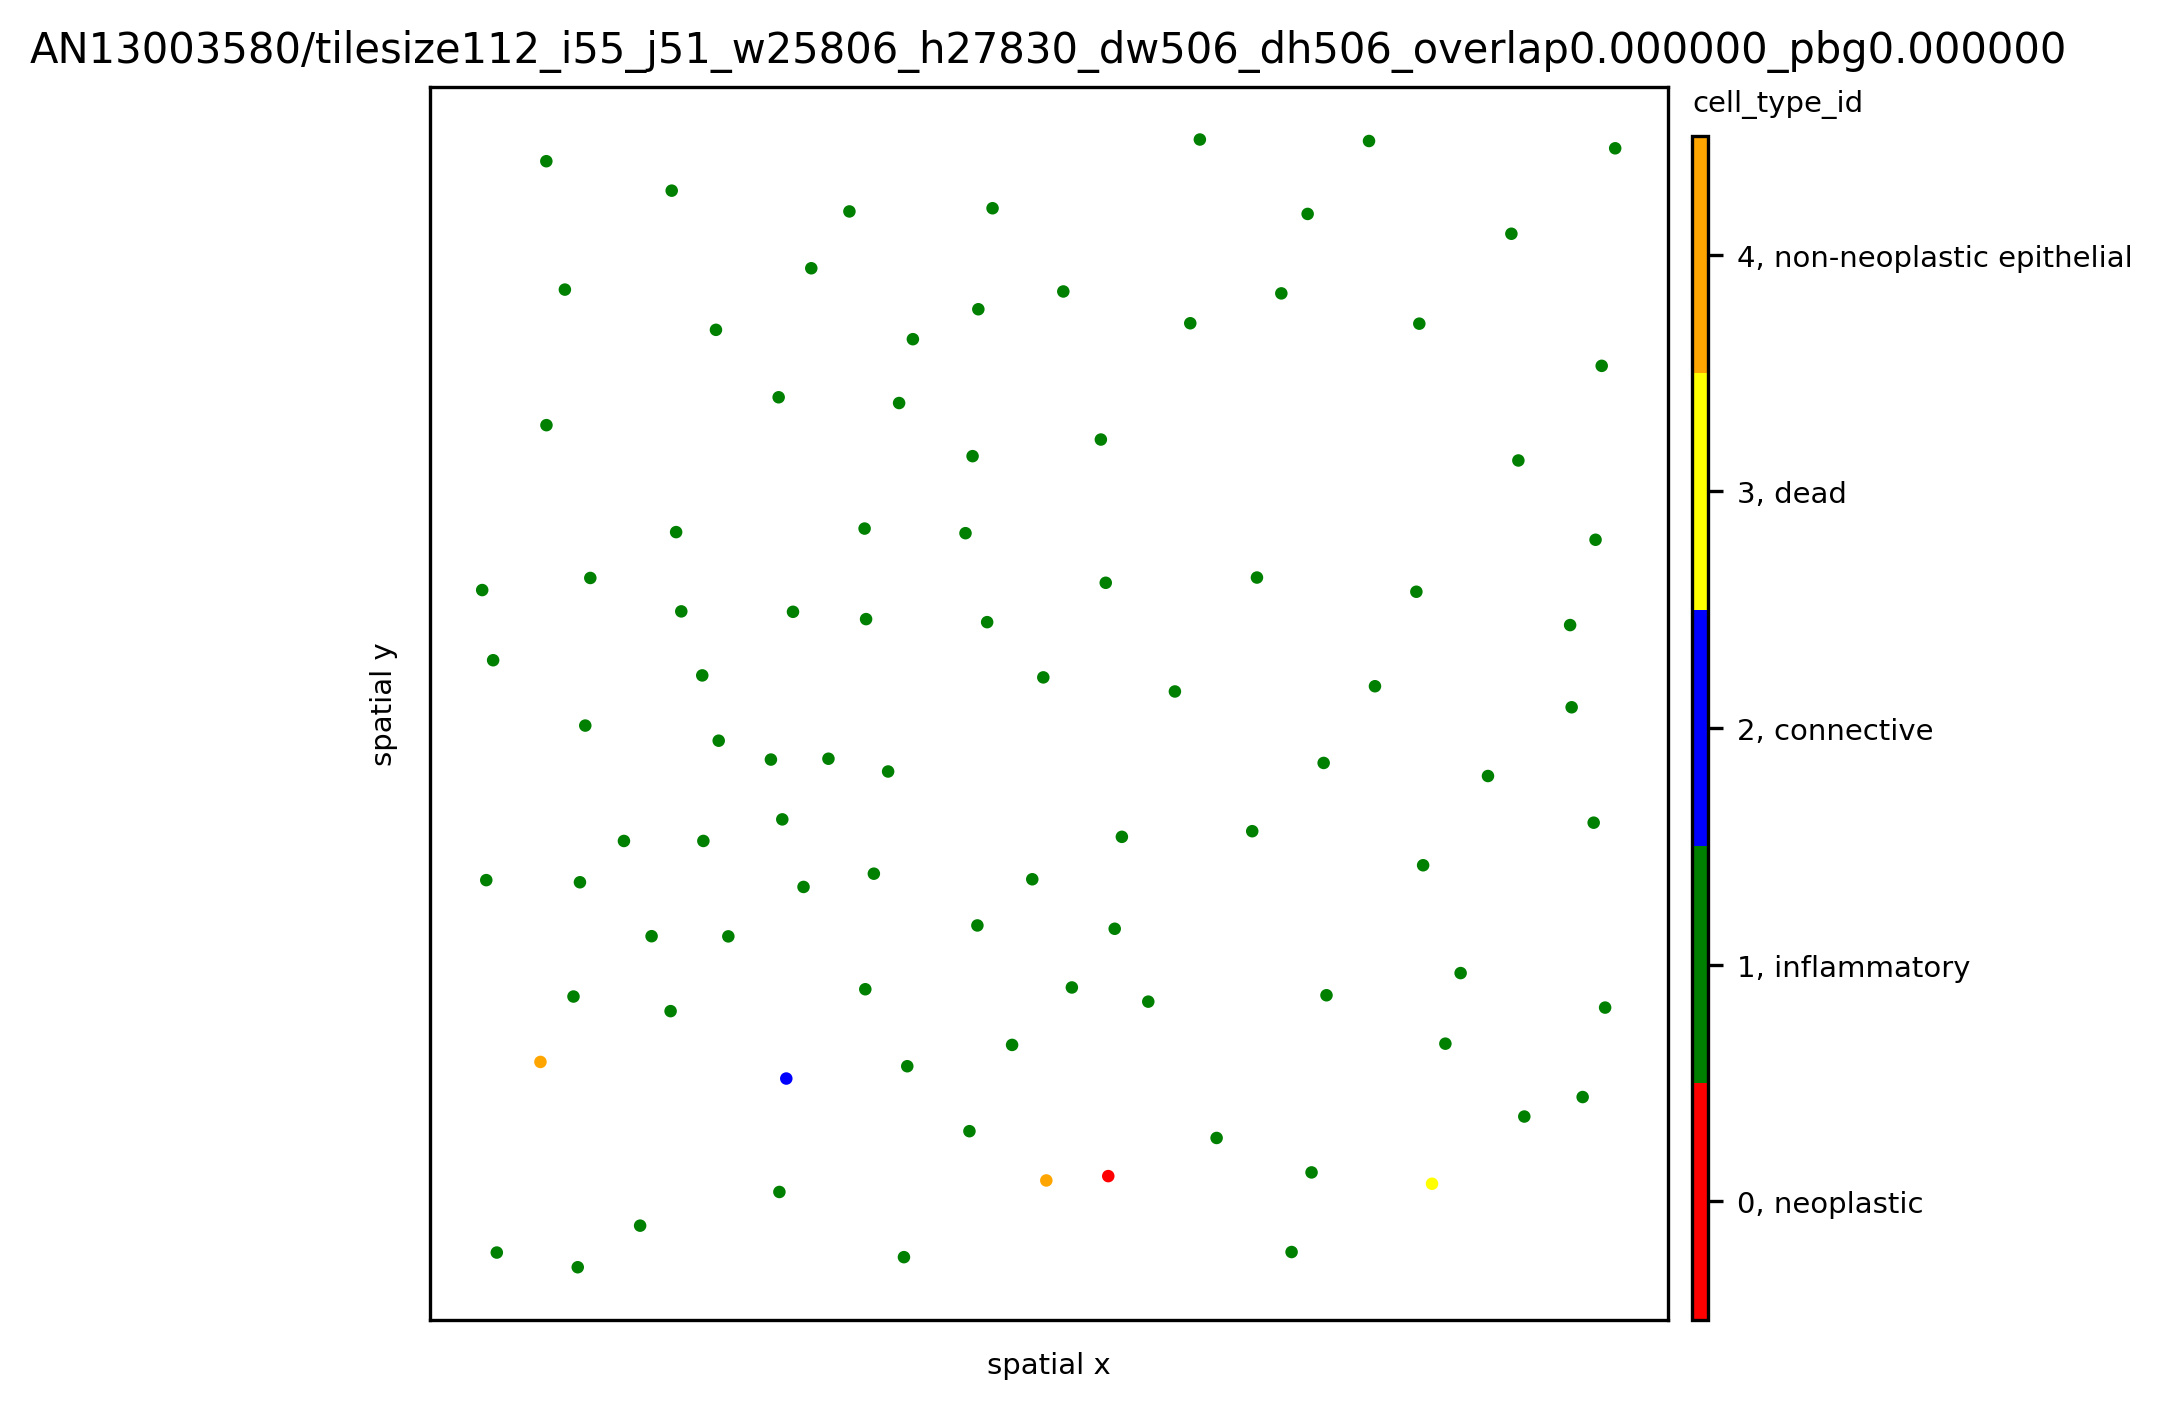

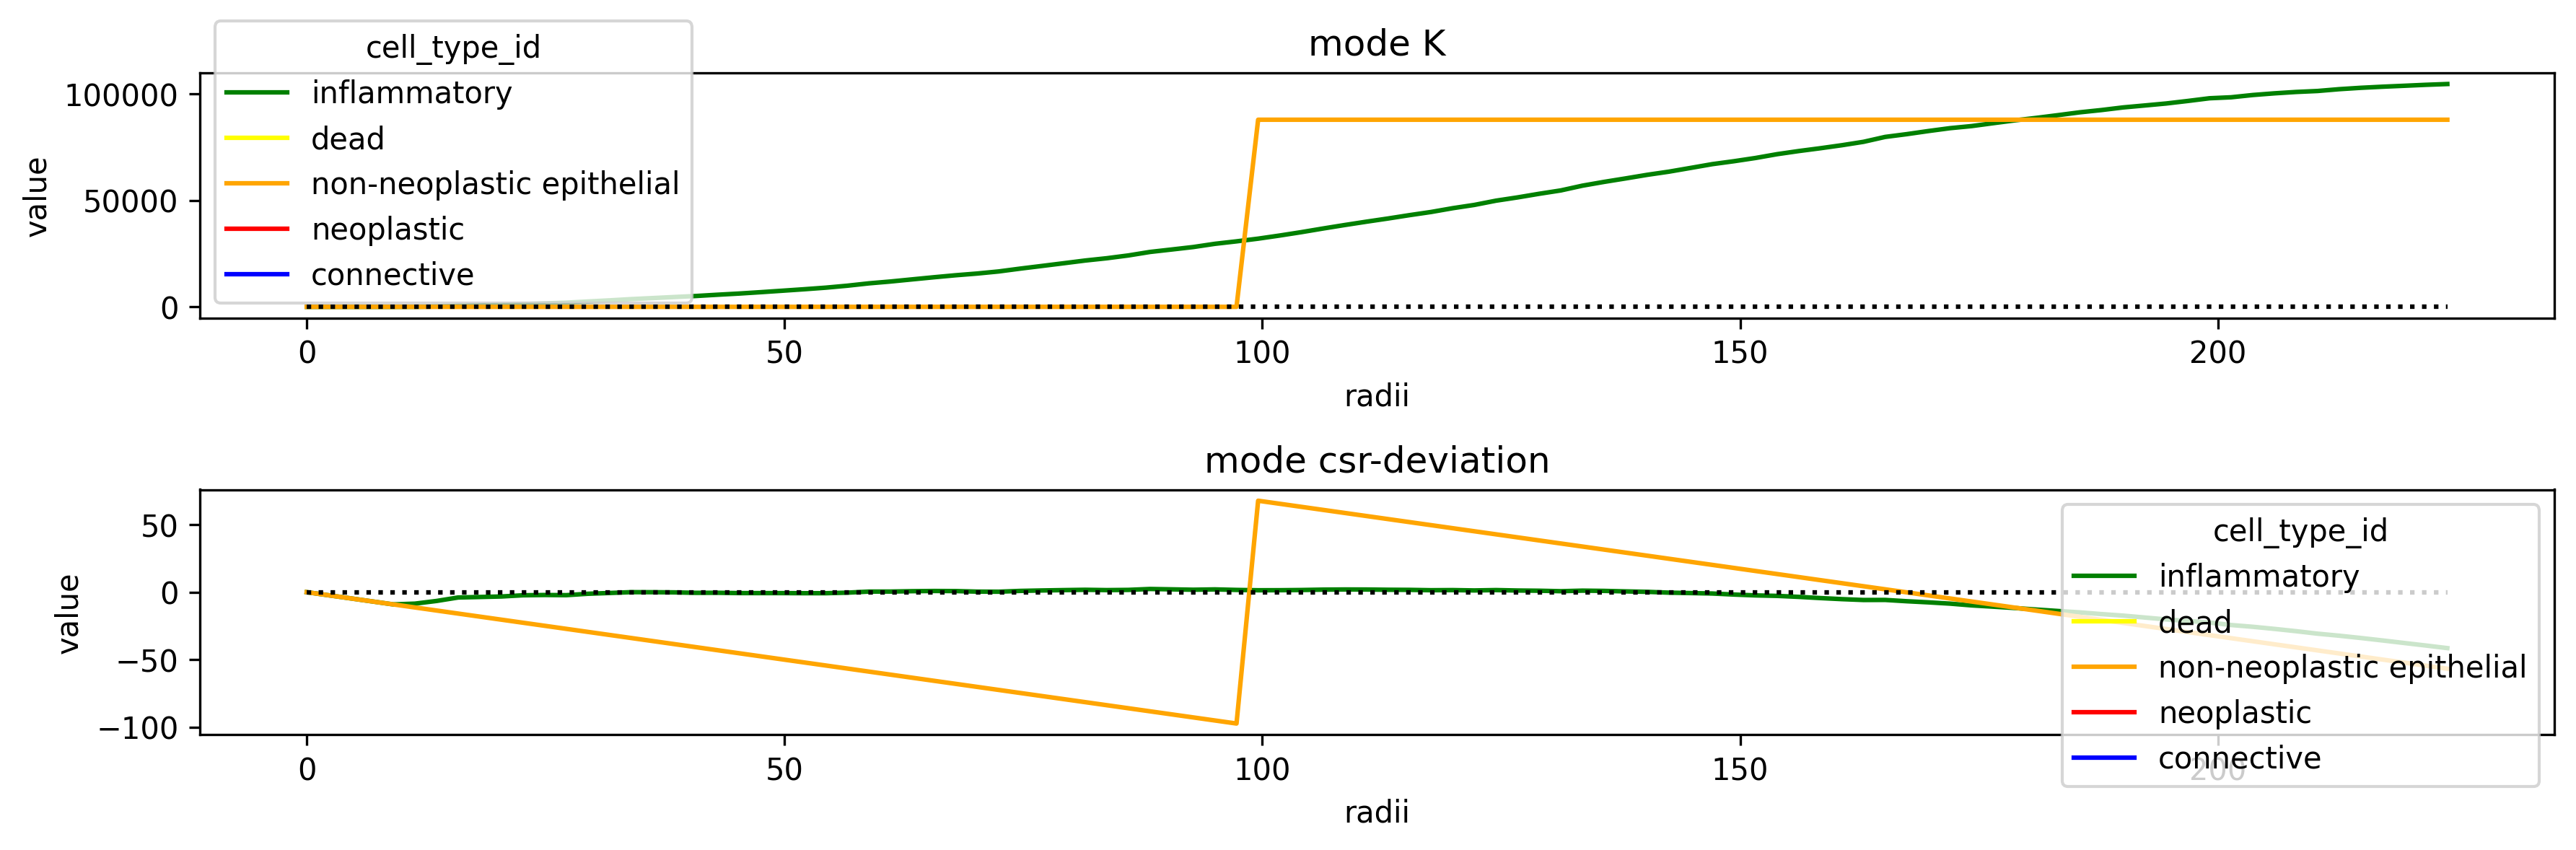

In [100]:
for spl in list(so.obs.keys())[:1] :
    # plot estimated deviation from random poisson process L(t)-t 
    sh.pl.spatial(so, spl, attr)
    fig, axs = plt.subplots(2, figsize=(12,4), dpi=300)
    axs[0].set_title('mode K')
    sh.pl.ripleysK(so, spl, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='K', ax=axs[0])#, legend=False)

    axs[1].set_title('mode csr-deviation')
    sh.pl.ripleysK(so, spl, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr-deviation', ax=axs[1])#, ax=axs[0][0])#, legend=False)


In [101]:
def get_cmap(so, attr: str, data):
    # TODO: recycle cmap if more observations than colors
    cmap, cmap_labels = None, None
    if attr in so.uns['cmaps'].keys():
        cmap = so.uns['cmaps'][attr]
    elif is_categorical(data):
        cmap = so.uns['cmaps']['category']
    else:
        cmap = so.uns['cmaps']['default']

    if attr in so.uns['cmap_labels'].keys():
        cmap_labels = so.uns['cmap_labels'][attr]

    return cmap, cmap_labels

def multiple_ripleysK(df, attr: str, ids, *, mode='K', correction='ripley',
             key=None, ax=None, legend='auto'):
    """Plot results

    Args:
        so: SpatialOmics instance
        spl: Spl for which to compute the metric
        attr: Categorical feature in SpatialOmics.obs to use for the grouping
        ids: The category in the categorical feature `attr`, for which Ripley's K should be plotted
        mode: {K, csr-deviation}. If `K`, Ripley's K is estimated, with `csr-deviation` the deviation from a poission process is computed.
        correction: Correction method to use to correct for boarder effects, see [1].
        key: key to use in so.uns['ripleysK'] for the plot, if None it is constructed from spl,attr,ids,mode and correction
        ax: axes to use for the plot

    Returns:
        None
    """

   # if key is None:
    #    if isinstance(ids, list):
     #       keys = [f'{i}_{attr}_{mode}_{correction}' for i in ids]
      #  else:
       #     keys = [f'{ids}_{attr}_{mode}_{correction}']
    #else:
     #   keys = [key]
    
    keys = list(df.columns)
    res = []
    for i in keys:
        #res.append(so.uns[spl]['ripleysK'][i])
        res.append(df[i])

    res = pd.concat(res, 1)

    if key is None:
        colnames = [i.split('_')[0] for i in keys]
    else:
        colnames = keys
    res = res.reset_index()

    res.columns = ['radii'] + colnames
    radii = res.radii.values
    res = res.melt(id_vars='radii', var_name=attr)
    res[attr] = res[attr].astype('category')

    cmap, labels = get_cmap(so, attr, res[attr])
    cmap_dict = {j:i for i,j in zip(cmap.colors, labels.values())}
    if labels:
        res[attr] = res[attr].astype(type(list(labels.keys())[0])).map(labels)


    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    sns.lineplot(data=res, x='radii', y='value', hue=attr, palette=cmap_dict, ax=ax, legend=legend)
    ax.plot(radii, np.repeat(0, len(radii)), color='black', linestyle=':')
    fig.tight_layout()
    fig.show()

## Tracé moyenne/médiane des valeurs de Ripley pour Ctrl/YO (csr + K)

/tmp/ipykernel_8010/1880785898.py:48: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  res = pd.concat(res, 1)
/tmp/ipykernel_8010/1880785898.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_8010/1880785898.py:48: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  res = pd.concat(res, 1)
/tmp/ipykernel_8010/1880785898.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_8010/4114285053.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_8010/1880785898.py:48: FutureWarning:

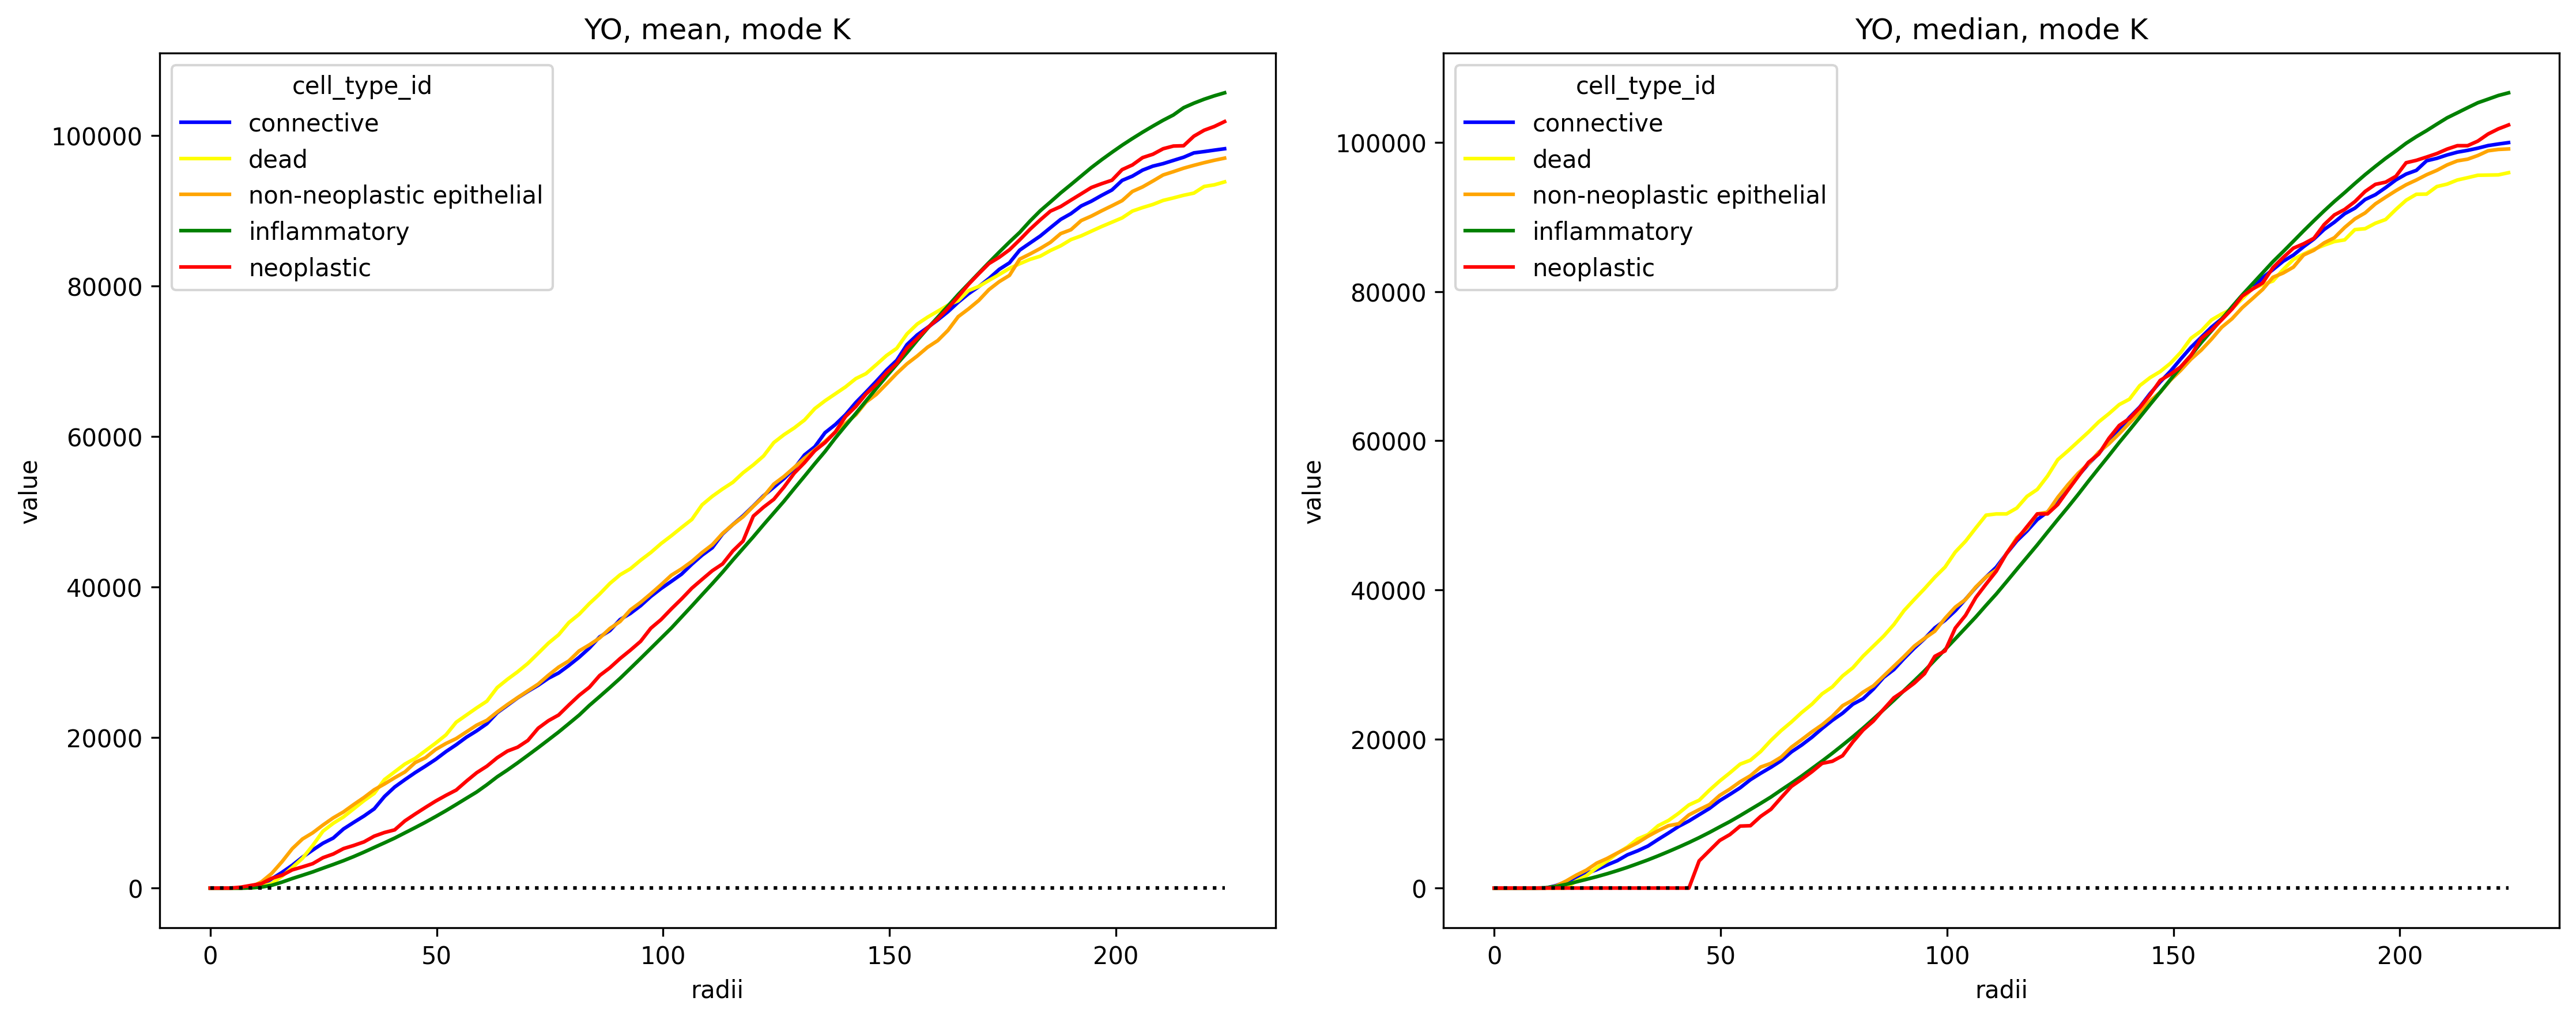

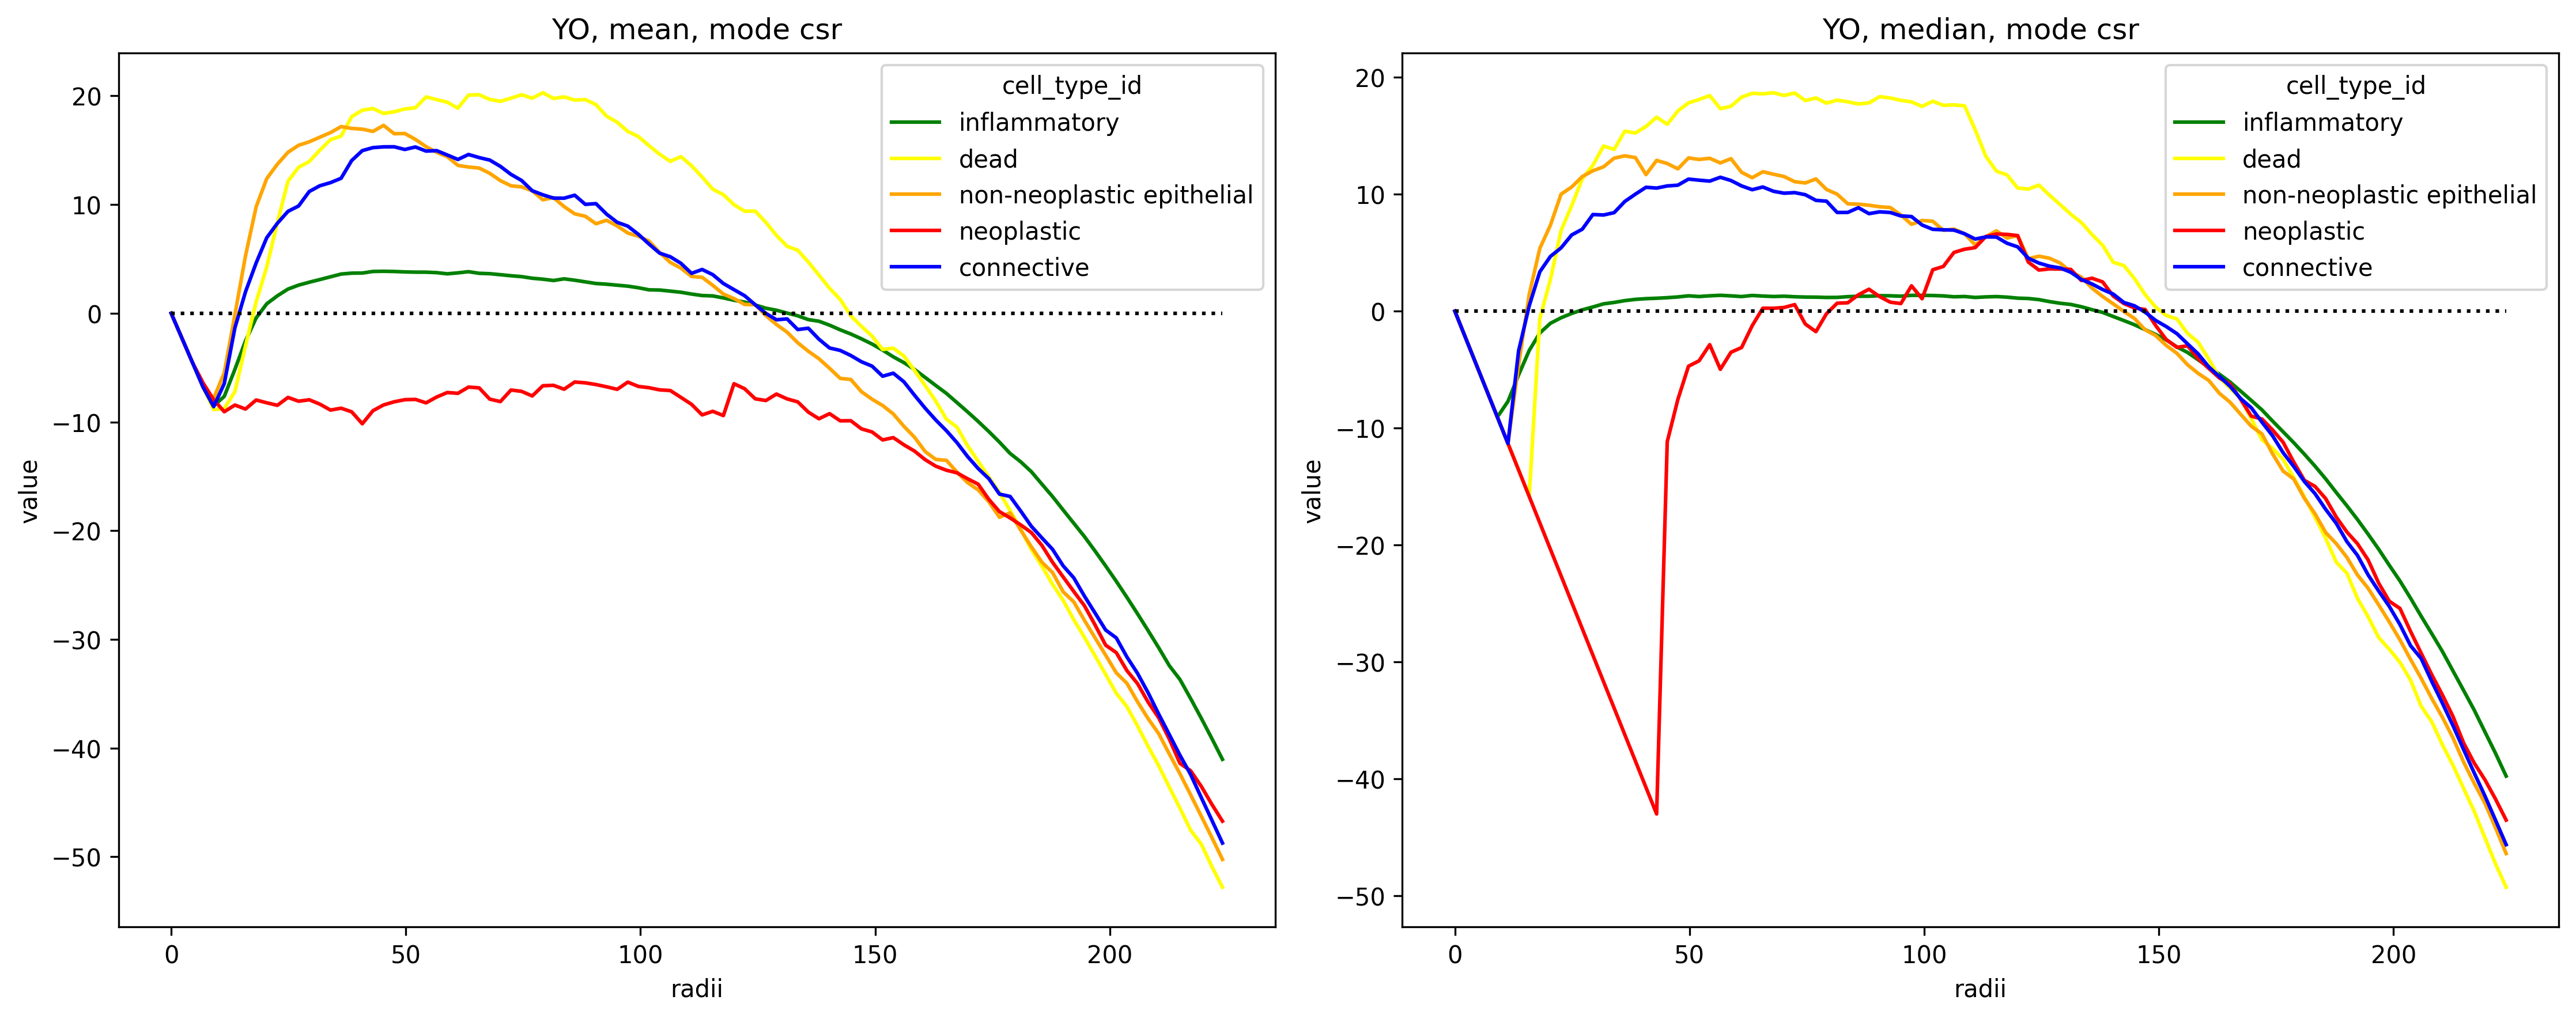

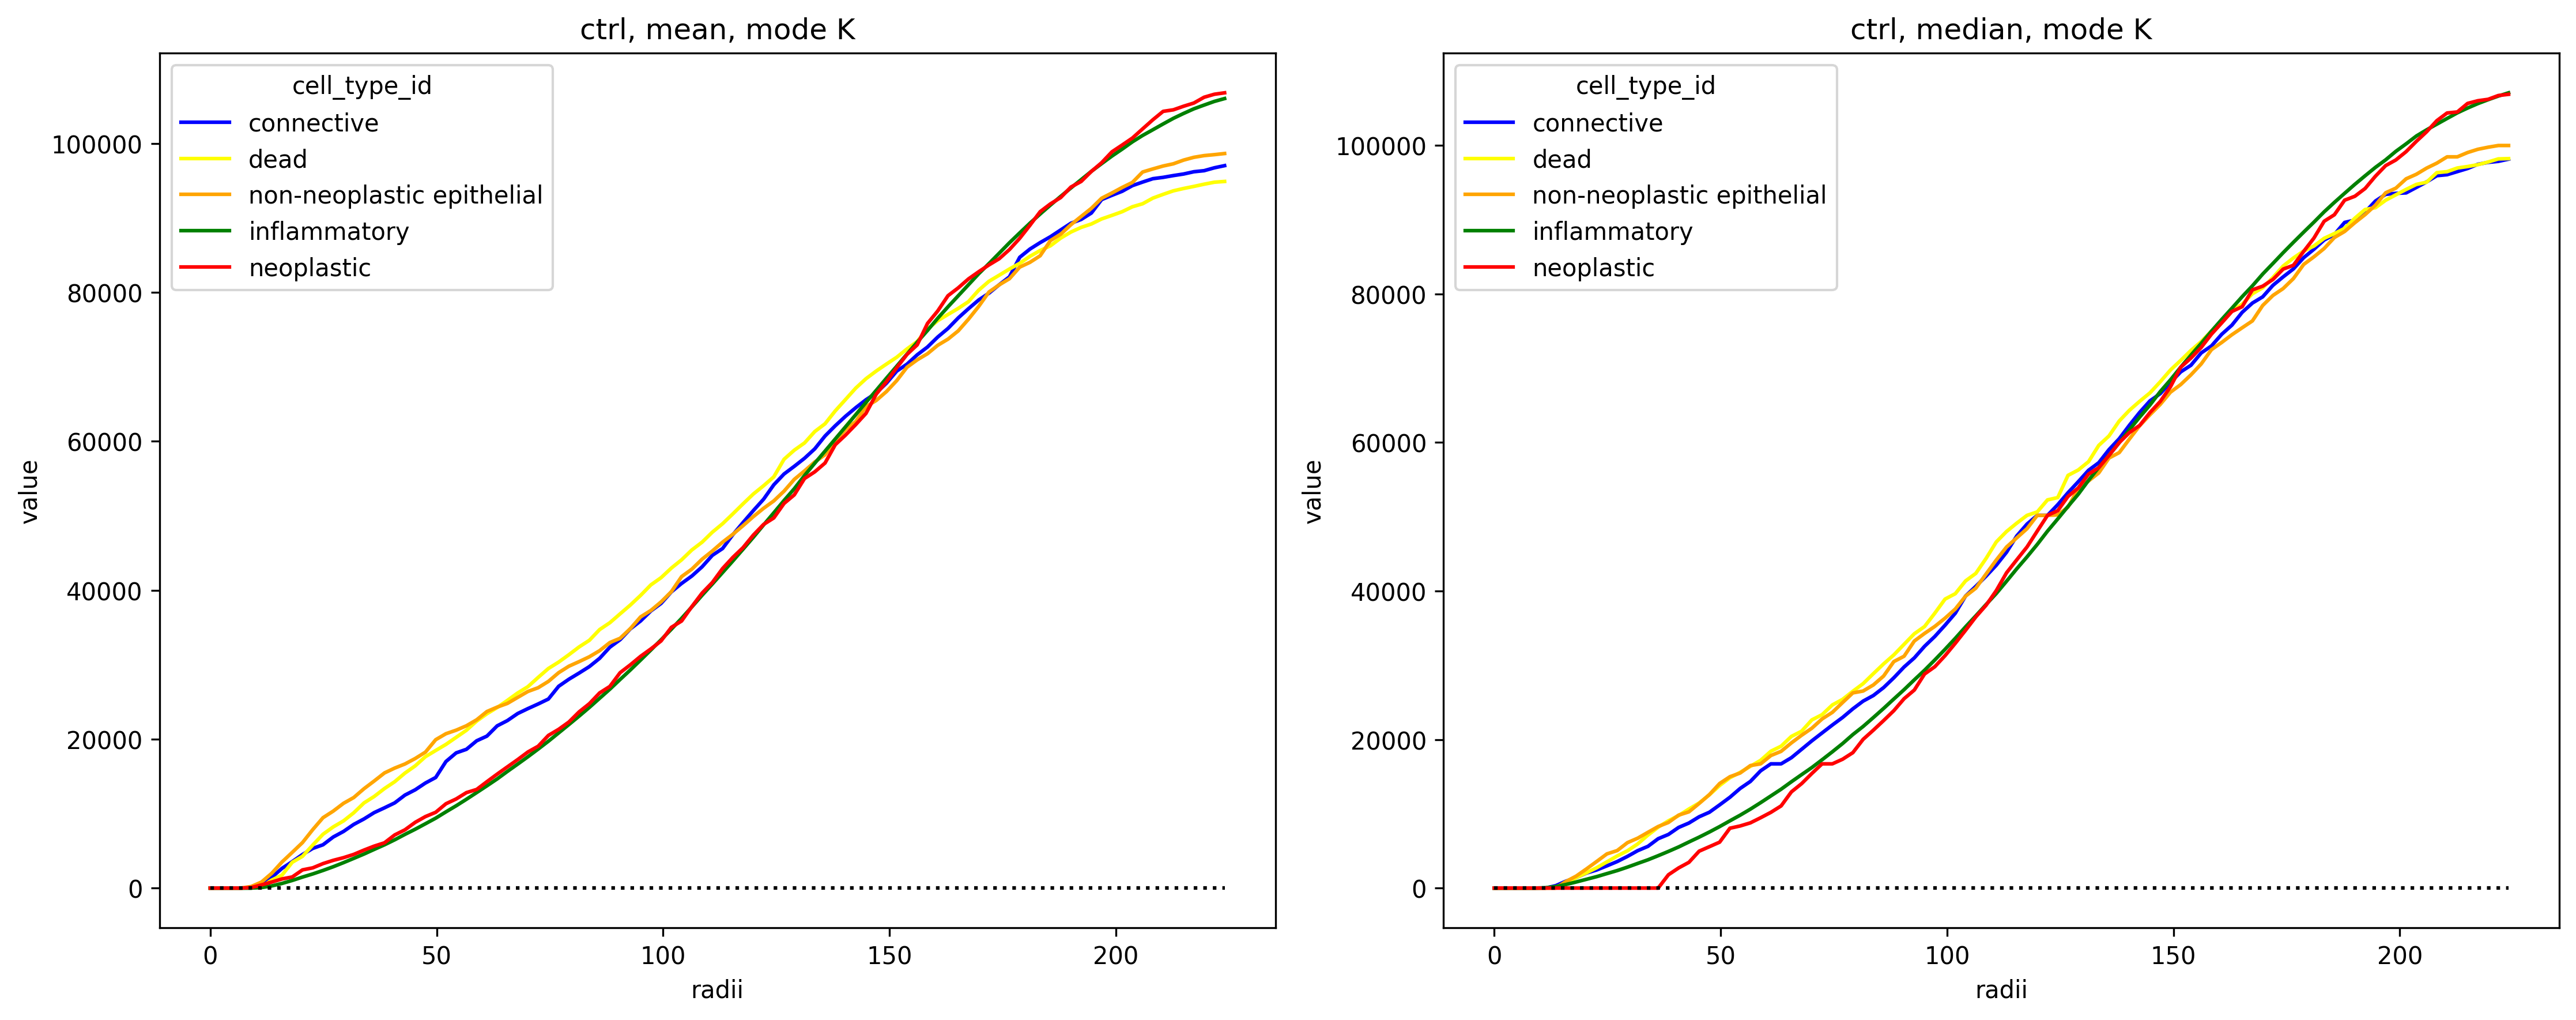

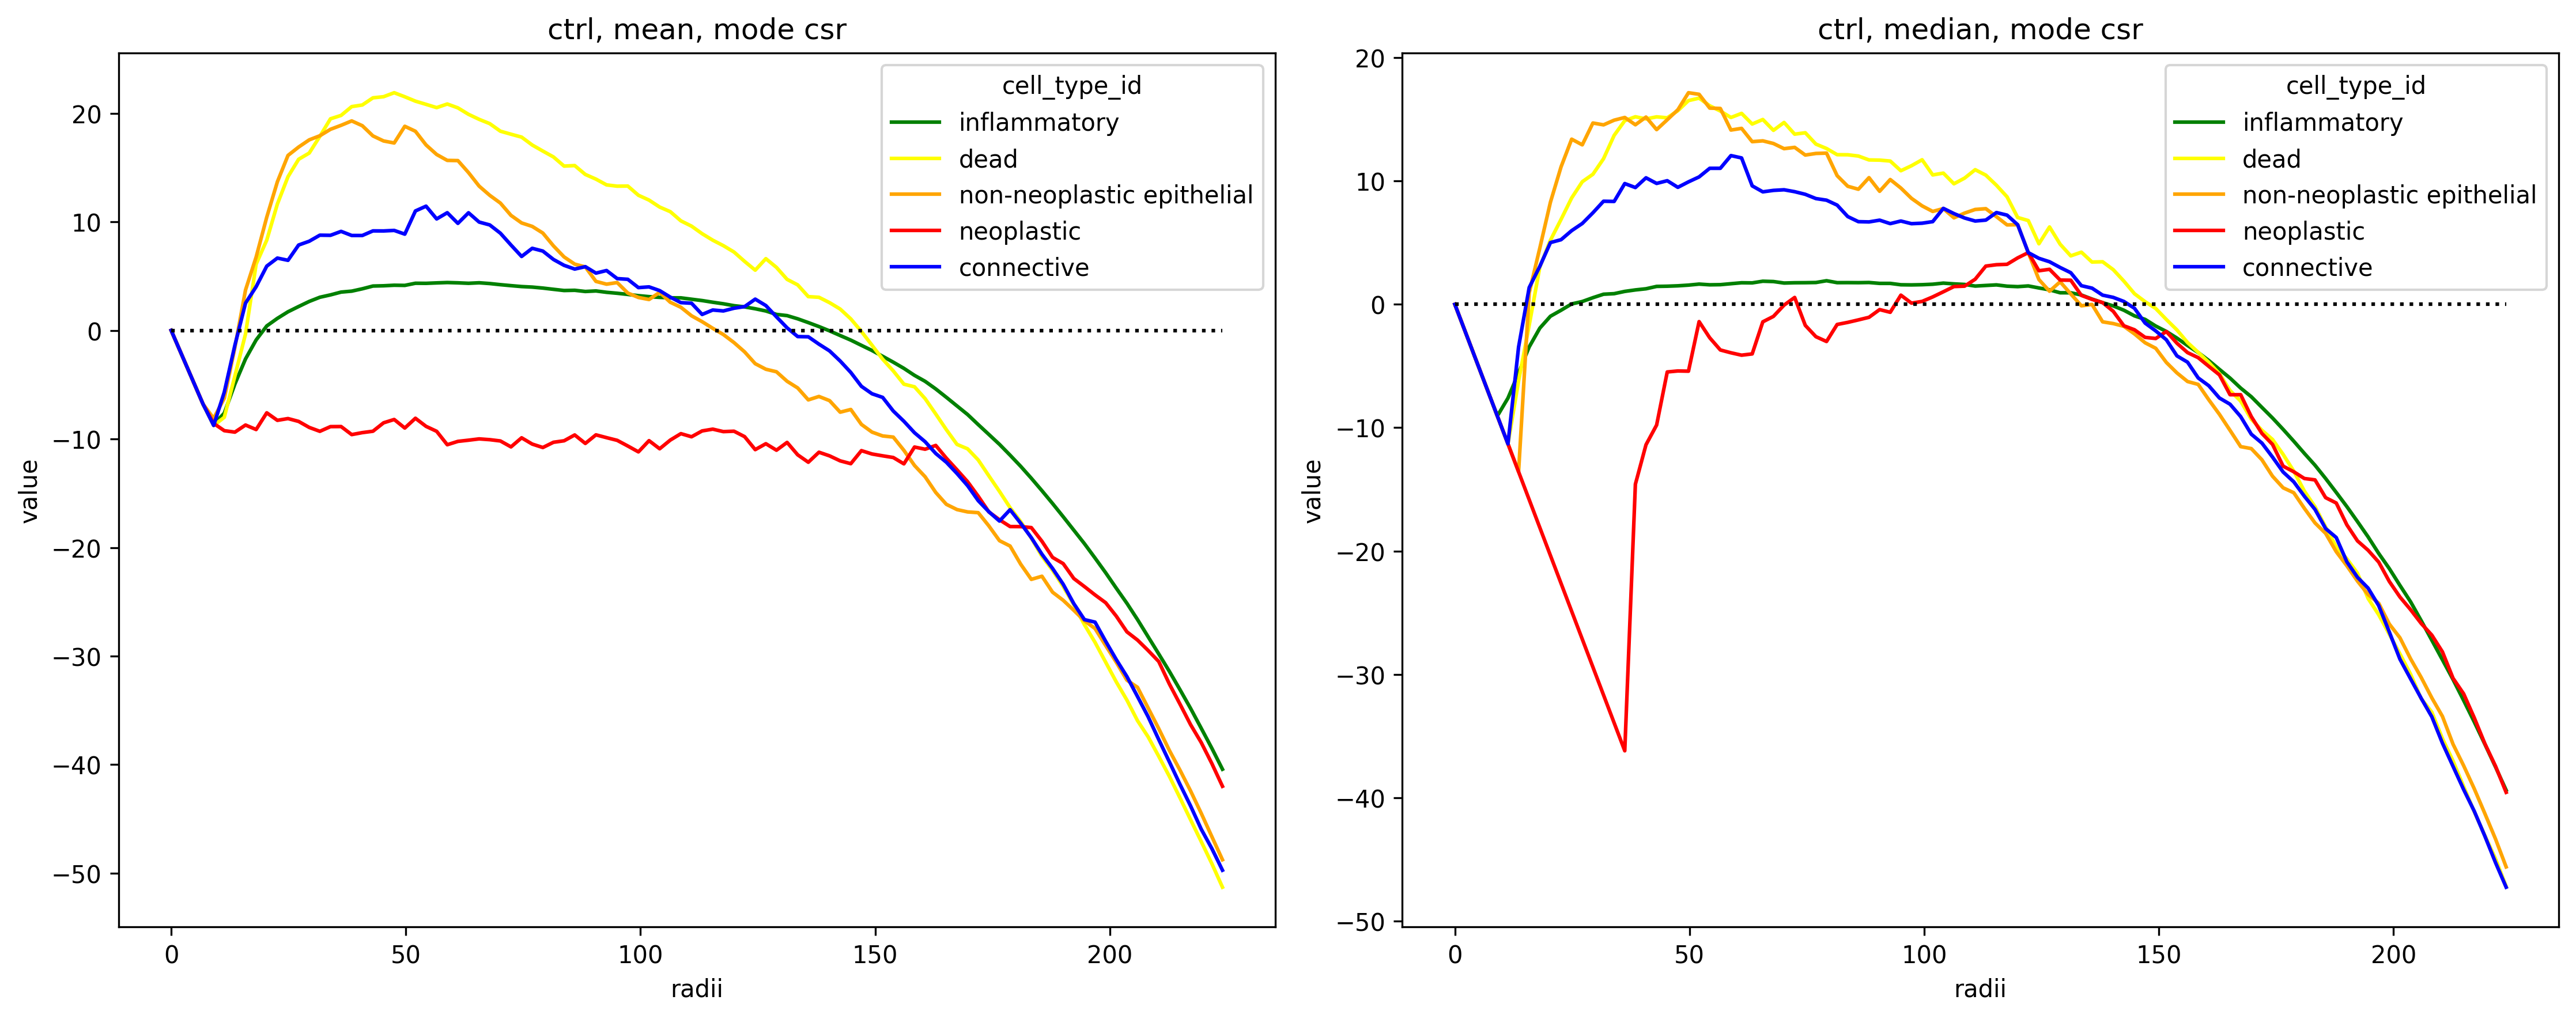

In [102]:
df_ctrl_ripley_K = pd.DataFrame()
df_YO_ripley_K = pd.DataFrame()
df_ctrl_ripley_csr = pd.DataFrame()
df_YO_ripley_csr = pd.DataFrame()

for _id in so.uns.keys() :
    if _id in liste_YO :
        for key in so.uns[_id]['ripleysK'].keys():
            if key.split('_')[4]=='K':
                df_YO_temp  = pd.DataFrame(so.uns[_id]['ripleysK'][key], columns=[key])
                df_YO_ripley_K = pd.concat([df_YO_ripley_K, df_YO_temp], axis=1)
            else :
                df_YO_temp  = pd.DataFrame(so.uns[_id]['ripleysK'][key], columns=[key])
                df_YO_ripley_csr = pd.concat([df_YO_ripley_csr, df_YO_temp], axis=1)
    if _id in liste_ctrl :
        for key in so.uns[_id]['ripleysK'].keys():
            if key.split('_')[4]=='K':
                df_ctrl_temp  = pd.DataFrame(so.uns[_id]['ripleysK'][key], columns=[key])
                df_ctrl_ripley_K = pd.concat([df_ctrl_ripley_K, df_ctrl_temp], axis=1)
            else :
                df_ctrl_temp  = pd.DataFrame(so.uns[_id]['ripleysK'][key], columns=[key])
                df_ctrl_ripley_csr = pd.concat([df_ctrl_ripley_csr, df_ctrl_temp], axis=1)
                
def stats(df) :
    df_mean = pd.DataFrame()
    df_median = pd.DataFrame()
    for name in list(set(df.columns)) :
        df_mean[name] = df[[name]].mean(numeric_only=True, axis=1)
        df_median[name] = df[[name]].median(numeric_only=True, axis=1)
    return df_mean, df_median

df_ctrl_ripley_K_mean, df_ctrl_ripley_K_median = stats(df_ctrl_ripley_K)
df_YO_ripley_K_mean, df_YO_ripley_K_median = stats(df_YO_ripley_K)
df_ctrl_ripley_csr_mean, df_ctrl_ripley_csr_median = stats(df_ctrl_ripley_csr)
df_YO_ripley_csr_mean, df_YO_ripley_csr_median = stats(df_YO_ripley_csr)

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
axs[0].set_title('YO, mean, mode K')
multiple_ripleysK(df_YO_ripley_K_mean, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='K', ax=axs[0])#, ax=axs[0][0])#, legend=False)
axs[1].set_title('YO, median, mode K')
multiple_ripleysK(df_YO_ripley_K_median, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='K', ax=axs[1])#, ax=axs[0][0])#, legend=False)
fig.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
axs[0].set_title('YO, mean, mode csr')
multiple_ripleysK(df_YO_ripley_csr_mean, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr', ax=axs[0])#, ax=axs[0][0])#, legend=False)
axs[1].set_title('YO, median, mode csr')
multiple_ripleysK(df_YO_ripley_csr_median, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr', ax=axs[1])#, ax=axs[0][0])#, legend=False)
fig.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
axs[0].set_title('ctrl, mean, mode K')
multiple_ripleysK(df_ctrl_ripley_K_mean, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr', ax=axs[0])#, ax=axs[0][0])#, legend=False)
axs[1].set_title('ctrl, median, mode K')
multiple_ripleysK(df_ctrl_ripley_K_median, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr', ax=axs[1])#, ax=axs[0][0])#, legend=False)
fig.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
axs[0].set_title('ctrl, mean, mode csr')
multiple_ripleysK(df_ctrl_ripley_csr_mean, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr', ax=axs[0])#, ax=axs[0][0])#, legend=False)
axs[1].set_title('ctrl, median, mode csr')
multiple_ripleysK(df_ctrl_ripley_csr_median, attr, ids = list(so.obs[spl].cell_type_id.unique()), mode='csr', ax=axs[1])#, ax=axs[0][0])#, legend=False)
fig.show()

In [103]:
dico = {}
dico['df_ctrl_ripley_K_mean'] = df_ctrl_ripley_K_mean
dico['df_ctrl_ripley_K_median'] = df_ctrl_ripley_K_median
dico['df_YO_ripley_K_mean'] = df_YO_ripley_K_mean
dico['df_YO_ripley_K_median'] = df_YO_ripley_K_median
dico['df_ctrl_ripley_csr_mean'] = df_ctrl_ripley_csr_mean
dico['df_ctrl_ripley_csr_median'] = df_ctrl_ripley_csr_median
dico['df_YO_ripley_csr_mean'] = df_YO_ripley_csr_mean
dico['df_YO_ripley_csr_median'] = df_YO_ripley_csr_median
dico

{'df_ctrl_ripley_K_mean':             2_cell_type_id_K_ripley  3_cell_type_id_K_ripley  \
 0.000000                   0.000000                 0.000000   
 2.262626                   0.000000                 0.000000   
 4.525253                   0.000000                 0.000000   
 6.787879                   0.000000                 0.000000   
 9.050505                   8.508459                 6.608354   
 ...                             ...                      ...   
 214.949495             95882.930094             93939.770177   
 217.212121             96186.992545             94216.049673   
 219.474747             96329.355792             94514.028011   
 221.737374             96716.033175             94780.907928   
 224.000000             97005.303427             94883.365505   
 
             4_cell_type_id_K_ripley  5_cell_type_id_K_ripley  \
 0.000000                   0.000000                 0.000000   
 2.262626                   0.000000                 0.000000  

In [104]:
pickle.dump(dico, open('df_ripley.pkl', 'wb'))

# Modularity 

In [15]:
for spl in so.spl.index:
    sh.graph.build_graph(so, spl, builder_type='knn', mask_key='cellmasks')
    sh.metrics.modularity(so, spl, 'cell_type_id')
so.spl

In [16]:
for spl in list(so.obs.keys())[2:3] :
    fig, axs = plt.subplots(1,2, figsize=(10,8))
    sh.pl.spatial(so, spl, 'cell_type_id', ax=axs[0], edges=True, graph_key='knn')
    sh.pl.spatial(so, spl, 'cell_type_id', ax=axs[1], edges=True, graph_key='contact')

sh.pl.spatial(so, spl, 'cell_type_id', ax=axs[2], edges=True, graph_key='contact')

In [17]:
plotting_parameters = {
        'data':    so.spl,
        'x':       'Type',
        'y':       'modularity_cell_type_id_1'}
plott_boxplot_pvalue(plotting_parameters, 0.6)